In [1]:
%matplotlib inline
import numpy as np
import sklearn
import pandas as pd
from PIL import Image
from matplotlib import pyplot as plt
import matplotlib
import torchvision
import torch
import os
import random
from tqdm import tqdm
from sklearn.metrics import roc_auc_score, roc_curve, plot_roc_curve, auc, accuracy_score, f1_score
from sklearn.model_selection import train_test_split
from collections import defaultdict
from pathlib import Path
import gc
import pickle
import torch.utils.data as data_utils
from torch.utils.data import DataLoader
import seaborn as sns
sns.set()

from joblib import Parallel, delayed
import time


matplotlib.style.use('ggplot')

In [2]:
class IconDataset(torch.utils.data.Dataset):
    def __init__(self, df, transform, data_root, run, label_noise):
        self.class_names = df['class'].unique().tolist()
        self.image_dir = data_root
        self.transform = transform
        self.total = len(df)
        self.image_names = df['image_path'].to_list()
        self.labels = df['%s_%s' %(run, label_noise)].to_numpy()
        self.targets = self.labels
                    
    def __len__(self):
        return self.total
    
    def __getitem__(self, idx):
        image_name = self.image_names[idx]
        image_path = os.path.join(self.image_dir, image_name)
        image = self.transform(Image.open(image_path).convert('RGB'))
        label = self.labels[idx]
        target = self.labels[idx]
        return image, label

    
image_size = (128, 128)
resnet_mean = [0.485, 0.456, 0.406]
resnet_std = [0.229, 0.224, 0.225]

#Creating a Transformation Object for train set
train_transform = torchvision.transforms.Compose([
    #Converting images to the size that the model expects
    torchvision.transforms.Resize(size=image_size),
    torchvision.transforms.RandomHorizontalFlip(), #A RandomHorizontalFlip to augment our data
    torchvision.transforms.ToTensor(), #Converting to tensor
    #Normalizing the data to the data that the ResNet18 was trained on
    torchvision.transforms.Normalize(mean = resnet_mean ,
                                    std = resnet_std) 
    
])


#Creating a Transformation Object for test set
test_transform = torchvision.transforms.Compose([
    #Converting images to the size that the model expects
    torchvision.transforms.Resize(size=image_size),
    # We don't do data augmentation in the test/val set    
    torchvision.transforms.ToTensor(), #Converting to tensor
    torchvision.transforms.Normalize(mean = resnet_mean,
                                    std = resnet_std) 
    
])

#build model using Resnext50 as backbone
class Resnext50(torch.nn.Module):
    def __init__(self, n_classes, name):
        super().__init__()
        self.name = name
        resnet = torchvision.models.resnext50_32x4d(pretrained=True, progress=True)
        resnet.fc = torch.nn.Sequential(
            torch.nn.Dropout(p=0.2),
            torch.nn.Linear(in_features=resnet.fc.in_features, out_features=n_classes)
        )
        self.base_model = resnet
        self.soft = torch.nn.Softmax(dim=1)

    def forward(self, x):
        return self.soft(self.base_model(x))

def train_loop(dataloader, model, loss_fn, optimizer, mode="flat", lookup=[], fine_to_coarse={}, 
               batch_size=64):
    size = len(dataloader.dataset)
    model.train()
    train_loss = 0
    counter = 0
    with tqdm(dataloader, unit="batch") as tepoch:
        for X_cpu, y_cpu in tepoch:
            counter += 1
            if mode == "fine":
                y_cpu = torch.tensor([lookup.index(i) for i in y_cpu])
            elif mode == "coarse":
                y_cpu = torch.tensor([fine_to_coarse[int(target)] for target in y_cpu])
            X, y = X_cpu.to(device), y_cpu.to(device)
            optimizer.zero_grad()
            outputs = model(X)
            loss = loss_fn(outputs, y.type(torch.long))
            loss.backward() 
            optimizer.step() 
            train_loss += loss.item() 
            avg_loss = train_loss / counter
            tepoch.set_postfix(loss=avg_loss)
    return avg_loss
    
    
def eval_model(dataloader, model, loss_fn, mode="flat", lookup=[], fine_to_coarse={}, 
               return_probab=False, batch_size=64):
    model.eval()
    predicts = []
    targets = []
    val_running_loss = 0.0
    
    for counter, (images, labels) in enumerate(dataloader):
        if mode == "fine":
            labels = torch.tensor([lookup.index(i) for i in labels])
        elif mode == "coarse":
            labels = torch.tensor([fine_to_coarse[int(i)] for i in labels])
        else:
            labels = torch.tensor(labels)
        imageGPU = images.to(device)
        
        outputs = torch.Tensor.cpu(model(imageGPU))
        loss = loss_fn(outputs, labels.type(torch.long))
        val_running_loss += loss.item()
        predicts.append(outputs.detach().numpy())
        targets.append(labels)
    val_loss = val_running_loss / (counter+1)  
    predicts = np.vstack(predicts)
    targets = np.hstack(targets)
    if return_probab:
        return predicts, targets
    else:
        predicts = np.argmax(predicts, axis=1)
        return val_loss, accuracy_score(targets, predicts)

    

def train_and_validate(epochs, model, loss_fn, optimizer, train_dl, test_dl, val_dl,
                       mode="flat", fine_to_coarse={}, coarse_label=None, lookup=[], 
                       model_path = None):

    early_stopping=EarlyStopping()
    
    if model_path is None:
        model_path = '/models/%s.pth' %model.name
    min_loss= 1000
    max_acc = 0
    train_loss= []
    val_loss, val_accuracy = [], []
    for t in range(epochs):
        if mode == "fine":
            print(f"Coarse label {coarse_label} Epoch {t+1}\n-------------------------------")
        else:
            print(f"Epoch {t+1}\n-------------------------------")
        train_epoch_loss = train_loop(train_dl, model, loss_fn, optimizer, mode=mode, fine_to_coarse=fine_to_coarse, lookup=lookup)
        val_epoch_loss, val_epoch_acc = eval_model(val_dl, model,loss_fn, mode=mode, fine_to_coarse=fine_to_coarse, lookup=lookup)
        
        train_loss.append(train_epoch_loss)
        val_loss.append(val_epoch_loss)
        val_accuracy.append(val_epoch_acc)
        if val_epoch_loss < min_loss:
            max_acc = val_epoch_acc
            min_loss = val_epoch_loss
            torch.save(model, model_path) 
        elif val_epoch_acc>max_acc:
            max_acc = val_epoch_acc
            torch.save(model, model_path) 
        early_stopping(val_epoch_loss)
        if early_stopping.early_stop:
            break
        print("train loss %s, validation loss %s, validation accuracy %s" %(train_epoch_loss, 
                                                                            val_epoch_loss, 
                                                                            val_epoch_acc))
    test_loss, test_acc = eval_model(test_dl, model, loss_fn, mode=mode, fine_to_coarse=fine_to_coarse, lookup=lookup)
    print("Done! Saved model with test accuracy %s and loss %s" %(test_acc, test_loss))
    # accuracy plots, optional
    plt.figure(figsize=(10, 7))
    plt.plot(val_accuracy, color='blue', label='validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.savefig(f"models/validationAccuracy{model.name}.png")
    plt.show()
    # loss plots
    plt.figure(figsize=(10, 7))
    plt.plot(train_loss, color='orange', label='train loss')
    plt.plot(val_loss, color='red', label='validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig(f"models/losses{model.name}.png")
    plt.show()
    
    return  test_acc

class EarlyStopping():
    """
    Early stopping to stop the training when the loss does not improve after
    certain epochs.
    """
    def __init__(self, patience=5, min_delta=0):
        """
        :param patience: how many epochs to wait before stopping when loss is
               not improving
        :param min_delta: minimum difference between new loss and old loss for
               new loss to be considered as an improvement
        """
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
    def __call__(self, val_loss):
        if self.best_loss == None:
            self.best_loss = val_loss
        elif self.best_loss - val_loss > self.min_delta:
            self.best_loss = val_loss
        elif self.best_loss - val_loss < self.min_delta:
            self.counter += 1
            print(f"INFO: Early stopping counter {self.counter} of {self.patience}")
            if self.counter >= self.patience:
                print('INFO: Early stopping')
                self.early_stop = True

def create_label_dictionaries(cluster_list):
    """Creates dictionaries from coarse to fine, from fine to coarse and concatenated list 
    of fine clusters

    Parameters:
    cluster_list: list
        A list where the index of the element represents the fine label and the value represents
        the coarse label(cluster)    
    """
    fine_to_coarse = {i:v for i,v in enumerate(cluster_list)}
    coarse_to_fine = defaultdict(list)
    for k, v in fine_to_coarse.items():
        coarse_to_fine[v].append(k)
    return fine_to_coarse, coarse_to_fine    

def filter_data(training_data, test_data, validation_data, filter_by_coarse=False, 
                coarse_label=None, coarse_to_fine=None,  batch_size=64): 
    """Filters datasets by coarse label if needed"""
    if filter_by_coarse:
        labels = coarse_to_fine[coarse_label]
        indices = [idx for idx,v in enumerate(training_data.labels) if v in labels]
        indices_test = [idx for idx,v in enumerate(test_data.labels) if v in labels] 
        indices_validation = [idx for idx,v in enumerate(validation_data.labels) if v in labels] 
    else:
        indices = [i for i in range(len(training_data.labels))]
        indices_test = [i for i in range(len(test_data.labels))]
        indices_validation = [i for i in range(len(validation_data.labels))]
        
    train = data_utils.Subset(training_data, indices) 
    test = data_utils.Subset(test_data, indices_test)
    validate = data_utils.Subset(validation_data, indices_validation)
    
    train_dl = DataLoader(train,  batch_size=batch_size, shuffle=True)
    validation_dl = DataLoader(validate, batch_size=batch_size, shuffle=False)
    test_dl = DataLoader(test,  batch_size=batch_size, shuffle=False)
    return train_dl, validation_dl, test_dl 

In [3]:
#learning rate is the same for all models
learning_rate = 1e-4 

teamdrive_root = '../../../teamdrive/transmediasp/kate/'
label_noises = [0, 10, 20, 30, 50, 80]
seeds = [5965, 6782, 5025, 9042, 3650, 7505, 5064, 2678, 6805, 1640]
fine_tuned_model_path = teamdrive_root + 'icons_experiment/icons_fine_tuned_model.pth'

accuracies = {}

In [4]:
#load dataframe with labels (a dataframe with splits to test and train subsets that we use accross notebooks)
df = pd.read_csv(teamdrive_root + 'icons_experiment/data_frame_50_percent_splits_with_label_noise.csv',index_col=0)

df.head()

image_path  class  label split_0  \
0  ../../../data/testdotai/close/_e4530e1aae88750...  close      0   train   
1  ../../../data/testdotai/close/~02a0c54fd8374b4...  close      0    test   
2  ../../../data/testdotai/close/_10099f88fd8333f...  close      0   train   
3  ../../../data/testdotai/close/_bcd740021f1a62a...  close      0    test   
4  ../../../data/testdotai/close/_047b3f69c7c53b8...  close      0   train   

  split_1 split_2 split_3 split_4 split_5 split_6  ... 8_20 8_30 8_50  8_80  \
0   train    test    test   train   valid    test  ...   17   17   17    17   
1   train    test    test   train    test   train  ...    0    0    0    42   
2   train    test    test   train   train    test  ...    0    0   42    13   
3    test   train    test   train    test    test  ...    0    0    0     0   
4    test    test   train   train   train   train  ...    0    0    0     0   

   9_0  9_10  9_20  9_30  9_50  9_80  
0    0     0     0     0    88    88  
1    0     0     0    88    38    38  
2    0    88    88    38     8     8  
3    0     0     0     8    74    74  
4    0     0     0     0     0     0  

[5 rows x 73 columns]

In [10]:
#df['image_path'] = df['image_path'].apply(lambda x: x[3:])

In [5]:
torch.cuda.is_available()

if torch.cuda.is_available():  
    dev = "cuda:0" 
else:  
    dev = "cpu"  
    
device = torch.device(dev)  

Starting run 0
defaultdict(<class 'list'>, {10: [0], 15: [1, 38, 54, 62], 12: [2, 7, 12, 45, 49, 91], 17: [3, 25, 66, 83], 5: [4, 77], 8: [5, 60, 70, 73, 75, 78, 82], 1: [6, 53, 56, 58, 79, 80], 11: [8, 31, 51, 61], 0: [9, 17, 26, 55, 69], 7: [10, 23, 39, 67], 9: [11, 18, 34, 46, 57, 63, 68, 76, 92, 93], 2: [13, 19, 20, 36, 41, 42, 47, 48, 71, 88], 6: [14, 15, 22, 32, 35, 43, 52], 4: [16, 21, 24, 30, 64, 72], 13: [27, 29, 81], 14: [28, 33, 37, 44, 89, 90], 16: [40, 59, 87], 18: [50], 19: [65, 74, 84, 85], 3: [86]})
Calculating for volume 0
Start training a coarse model
Epoch 1
-------------------------------


  0%|          | 0/1052 [00:00<?, ?batch/s]/anaconda/envs/py38_default/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448278899/work/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
100%|██████████| 1052/1052 [06:02<00:00,  2.91batch/s, loss=2.47]


train loss 2.4672711260418474, validation loss 2.377269849323091, validation accuracy 0.7019431988041853
Epoch 2
-------------------------------


100%|██████████| 1052/1052 [05:59<00:00,  2.93batch/s, loss=2.36]


train loss 2.3628899096989358, validation loss 2.3458004678998674, validation accuracy 0.7343796711509716
Epoch 3
-------------------------------


100%|██████████| 1052/1052 [05:58<00:00,  2.93batch/s, loss=2.34]


train loss 2.3412692809739495, validation loss 2.3349276043119884, validation accuracy 0.7439461883408072
Epoch 4
-------------------------------


100%|██████████| 1052/1052 [05:59<00:00,  2.93batch/s, loss=2.33]


train loss 2.3284815867137545, validation loss 2.3315082754407612, validation accuracy 0.7475336322869955
Epoch 5
-------------------------------


100%|██████████| 1052/1052 [07:46<00:00,  2.26batch/s, loss=2.32]


train loss 2.3193352653046526, validation loss 2.3221707162402927, validation accuracy 0.7568011958146488
Epoch 6
-------------------------------


100%|██████████| 1052/1052 [05:59<00:00,  2.93batch/s, loss=2.31]


train loss 2.3101024872449867, validation loss 2.32014726684207, validation accuracy 0.7584454409566517
Epoch 7
-------------------------------


100%|██████████| 1052/1052 [05:57<00:00,  2.94batch/s, loss=2.3]


train loss 2.304381042152303, validation loss 2.3172324316842214, validation accuracy 0.7633781763826607
Epoch 8
-------------------------------


100%|██████████| 1052/1052 [05:57<00:00,  2.94batch/s, loss=2.29]


train loss 2.288120694486814, validation loss 2.2837981133233933, validation accuracy 0.7956651718983557
Epoch 9
-------------------------------


100%|██████████| 1052/1052 [07:32<00:00,  2.33batch/s, loss=2.27]


INFO: Early stopping counter 1 of 5
train loss 2.2651437094909608, validation loss 2.285046304975237, validation accuracy 0.7949177877428999
Epoch 10
-------------------------------


100%|██████████| 1052/1052 [06:02<00:00,  2.90batch/s, loss=2.25]


train loss 2.253464986389581, validation loss 2.261949212210519, validation accuracy 0.816591928251121
Epoch 11
-------------------------------


100%|██████████| 1052/1052 [06:03<00:00,  2.89batch/s, loss=2.24]


train loss 2.2397179256827204, validation loss 2.2544784682137626, validation accuracy 0.8251121076233184
Epoch 12
-------------------------------


100%|██████████| 1052/1052 [06:04<00:00,  2.89batch/s, loss=2.23]


INFO: Early stopping counter 2 of 5
train loss 2.2339123079532, validation loss 2.2604231698172432, validation accuracy 0.81898355754858
Epoch 13
-------------------------------


100%|██████████| 1052/1052 [06:05<00:00,  2.88batch/s, loss=2.23]


INFO: Early stopping counter 3 of 5
train loss 2.2314319334102675, validation loss 2.2598969527653288, validation accuracy 0.818236173393124
Epoch 14
-------------------------------


100%|██████████| 1052/1052 [07:53<00:00,  2.22batch/s, loss=2.23]


INFO: Early stopping counter 4 of 5
train loss 2.2257199865330306, validation loss 2.2560288633619034, validation accuracy 0.8230194319880418
Epoch 15
-------------------------------


100%|██████████| 1052/1052 [06:04<00:00,  2.88batch/s, loss=2.22]


train loss 2.2213087809403134, validation loss 2.2532266071864537, validation accuracy 0.8258594917787743
Epoch 16
-------------------------------


100%|██████████| 1052/1052 [06:05<00:00,  2.88batch/s, loss=2.22]


train loss 2.219018829866054, validation loss 2.250244242804391, validation accuracy 0.8292974588938714
Epoch 17
-------------------------------


100%|██████████| 1052/1052 [07:48<00:00,  2.24batch/s, loss=2.22]


train loss 2.2171369133793357, validation loss 2.2467316423143657, validation accuracy 0.8324364723467862
Epoch 18
-------------------------------


100%|██████████| 1052/1052 [06:04<00:00,  2.89batch/s, loss=2.21]


INFO: Early stopping counter 5 of 5
INFO: Early stopping
Done! Saved model with test accuracy 0.8333635778741937 and loss 2.2448989286201413


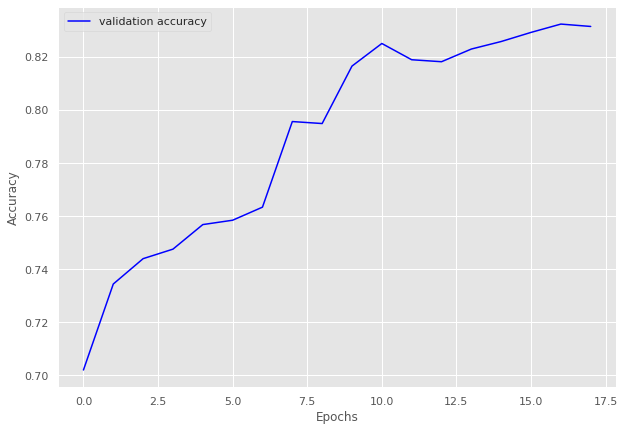

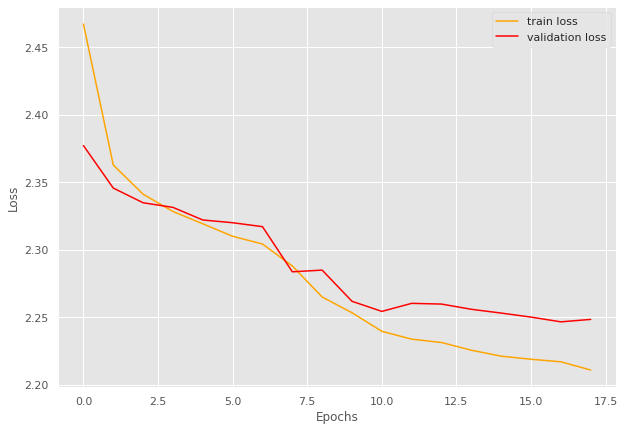

Done training of a coarse model with test accuracy 0.8333635778741937
Coarse label 0 Epoch 1
-------------------------------


100%|██████████| 68/68 [00:23<00:00,  2.87batch/s, loss=1.08]


train loss 1.0755720401511473, validation loss 0.9789612889289856, validation accuracy 0.9230769230769231
Coarse label 0 Epoch 2
-------------------------------


100%|██████████| 68/68 [00:23<00:00,  2.91batch/s, loss=0.954]


train loss 0.9540716865483452, validation loss 0.9744700619152614, validation accuracy 0.9254079254079254
Coarse label 0 Epoch 3
-------------------------------


100%|██████████| 68/68 [00:23<00:00,  2.92batch/s, loss=0.944]


train loss 0.9441118739983615, validation loss 0.9684532284736633, validation accuracy 0.9324009324009324
Coarse label 0 Epoch 4
-------------------------------


100%|██████████| 68/68 [00:23<00:00,  2.87batch/s, loss=0.944]


train loss 0.9440453464494032, validation loss 0.9615943006106785, validation accuracy 0.9417249417249417
Coarse label 0 Epoch 5
-------------------------------


100%|██████████| 68/68 [00:23<00:00,  2.93batch/s, loss=0.934]


train loss 0.9340875569511863, validation loss 0.9580725431442261, validation accuracy 0.9393939393939394
Coarse label 0 Epoch 6
-------------------------------


100%|██████████| 68/68 [00:23<00:00,  2.91batch/s, loss=0.932]


train loss 0.932413951439016, validation loss 0.9529891354697091, validation accuracy 0.9487179487179487
Coarse label 0 Epoch 7
-------------------------------


100%|██████████| 68/68 [00:23<00:00,  2.88batch/s, loss=0.93] 


INFO: Early stopping counter 1 of 5
train loss 0.9298199047060574, validation loss 0.9569330045155117, validation accuracy 0.9463869463869464
Coarse label 0 Epoch 8
-------------------------------


100%|██████████| 68/68 [00:23<00:00,  2.87batch/s, loss=0.933]


INFO: Early stopping counter 2 of 5
train loss 0.932796407271834, validation loss 0.9535416279520307, validation accuracy 0.951048951048951
Coarse label 0 Epoch 9
-------------------------------


100%|██████████| 68/68 [00:23<00:00,  2.93batch/s, loss=0.926]


train loss 0.9258207021390691, validation loss 0.9456339223044259, validation accuracy 0.9557109557109557
Coarse label 0 Epoch 10
-------------------------------


100%|██████████| 68/68 [00:23<00:00,  2.89batch/s, loss=0.925]


INFO: Early stopping counter 3 of 5
train loss 0.9250897730098051, validation loss 0.9497850367001125, validation accuracy 0.9557109557109557
Coarse label 0 Epoch 11
-------------------------------


100%|██████████| 68/68 [00:23<00:00,  2.93batch/s, loss=0.925]


INFO: Early stopping counter 4 of 5
train loss 0.9253266699173871, validation loss 0.9471507242747715, validation accuracy 0.958041958041958
Coarse label 0 Epoch 12
-------------------------------


100%|██████████| 68/68 [00:23<00:00,  2.92batch/s, loss=0.928]


train loss 0.9283877988072002, validation loss 0.9449419294084821, validation accuracy 0.9603729603729604
Coarse label 0 Epoch 13
-------------------------------


100%|██████████| 68/68 [00:23<00:00,  2.91batch/s, loss=0.927]


INFO: Early stopping counter 5 of 5
INFO: Early stopping
Done! Saved model with test accuracy 0.9637811456460313 and loss 0.9412660843036214


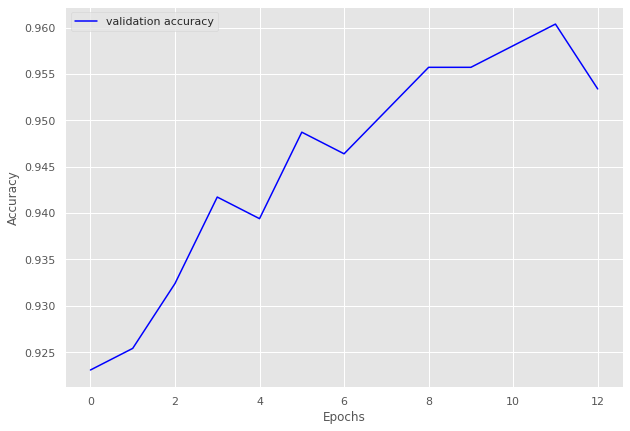

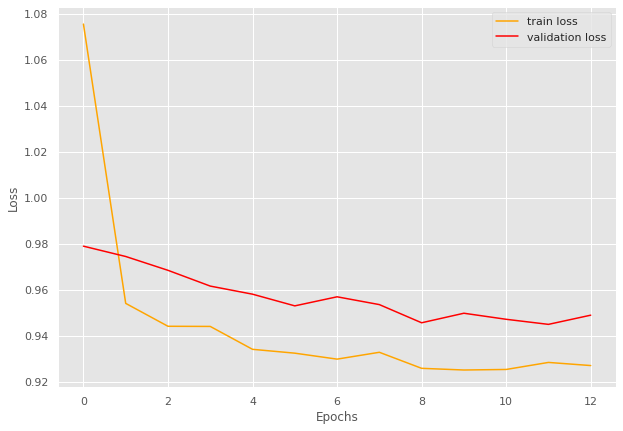

Done training of a fine model with test accuracy 0.9637811456460313
Coarse label 1 Epoch 1
-------------------------------


100%|██████████| 30/30 [00:10<00:00,  2.95batch/s, loss=1.29]


train loss 1.2871238430341085, validation loss 1.1427053610483806, validation accuracy 0.9086021505376344
Coarse label 1 Epoch 2
-------------------------------


100%|██████████| 30/30 [00:10<00:00,  2.93batch/s, loss=1.1] 


train loss 1.095127777258555, validation loss 1.0933994054794312, validation accuracy 0.9516129032258065
Coarse label 1 Epoch 3
-------------------------------


100%|██████████| 30/30 [00:10<00:00,  2.92batch/s, loss=1.07]


INFO: Early stopping counter 1 of 5
train loss 1.0694455901781719, validation loss 1.1021145184834797, validation accuracy 0.9408602150537635
Coarse label 1 Epoch 4
-------------------------------


100%|██████████| 30/30 [00:10<00:00,  2.95batch/s, loss=1.07]


train loss 1.0693026820818583, validation loss 1.0837420622507732, validation accuracy 0.967741935483871
Coarse label 1 Epoch 5
-------------------------------


100%|██████████| 30/30 [00:10<00:00,  2.98batch/s, loss=1.07]


INFO: Early stopping counter 2 of 5
train loss 1.0672324419021606, validation loss 1.0890402793884277, validation accuracy 0.9516129032258065
Coarse label 1 Epoch 6
-------------------------------


100%|██████████| 30/30 [00:10<00:00,  2.93batch/s, loss=1.07]


INFO: Early stopping counter 3 of 5
train loss 1.065133778254191, validation loss 1.1002132495244343, validation accuracy 0.9516129032258065
Coarse label 1 Epoch 7
-------------------------------


100%|██████████| 30/30 [00:10<00:00,  2.87batch/s, loss=1.06]


INFO: Early stopping counter 4 of 5
train loss 1.0577141364415488, validation loss 1.092541257540385, validation accuracy 0.956989247311828
Coarse label 1 Epoch 8
-------------------------------


100%|██████████| 30/30 [00:10<00:00,  3.00batch/s, loss=1.06]


INFO: Early stopping counter 5 of 5
INFO: Early stopping
Done! Saved model with test accuracy 0.9658018867924528 and loss 1.077989353073968


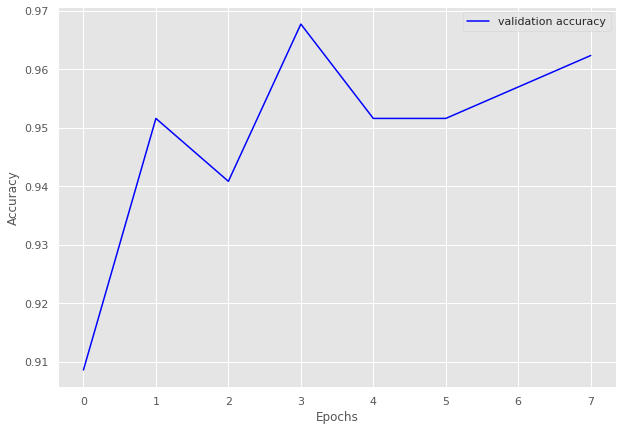

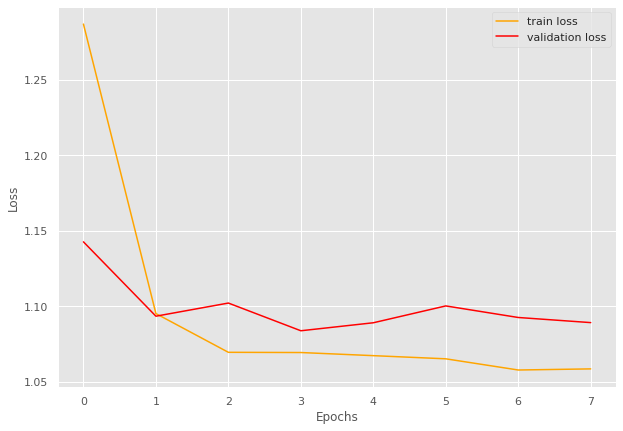

Done training of a fine model with test accuracy 0.9658018867924528
Coarse label 2 Epoch 1
-------------------------------


100%|██████████| 137/137 [00:47<00:00,  2.89batch/s, loss=1.67]


train loss 1.6739394673465813, validation loss 1.544992710862841, validation accuracy 0.9206896551724137
Coarse label 2 Epoch 2
-------------------------------


100%|██████████| 137/137 [00:47<00:00,  2.89batch/s, loss=1.53]


train loss 1.5334405011504235, validation loss 1.5365365828786577, validation accuracy 0.9275862068965517
Coarse label 2 Epoch 3
-------------------------------


100%|██████████| 137/137 [00:47<00:00,  2.88batch/s, loss=1.52]


train loss 1.517003437028314, validation loss 1.5248847348349435, validation accuracy 0.9402298850574713
Coarse label 2 Epoch 4
-------------------------------


100%|██████████| 137/137 [00:47<00:00,  2.89batch/s, loss=1.51]


INFO: Early stopping counter 1 of 5
train loss 1.506429107519832, validation loss 1.5275251439639501, validation accuracy 0.9402298850574713
Coarse label 2 Epoch 5
-------------------------------


100%|██████████| 137/137 [00:47<00:00,  2.89batch/s, loss=1.5] 


train loss 1.5044205858759636, validation loss 1.512669094971248, validation accuracy 0.9540229885057471
Coarse label 2 Epoch 6
-------------------------------


100%|██████████| 137/137 [00:47<00:00,  2.89batch/s, loss=1.5]


train loss 1.5009212955071107, validation loss 1.5095942446163721, validation accuracy 0.9551724137931035
Coarse label 2 Epoch 7
-------------------------------


100%|██████████| 137/137 [00:47<00:00,  2.87batch/s, loss=1.5] 


train loss 1.495553310770188, validation loss 1.5084538630076818, validation accuracy 0.957471264367816
Coarse label 2 Epoch 8
-------------------------------


100%|██████████| 137/137 [00:47<00:00,  2.87batch/s, loss=1.49]


train loss 1.492066450362658, validation loss 1.5035646898405892, validation accuracy 0.9597701149425287
Coarse label 2 Epoch 9
-------------------------------


100%|██████████| 137/137 [00:47<00:00,  2.87batch/s, loss=1.49]


INFO: Early stopping counter 2 of 5
train loss 1.48837783562876, validation loss 1.5170972432409013, validation accuracy 0.9459770114942528
Coarse label 2 Epoch 10
-------------------------------


100%|██████████| 137/137 [00:47<00:00,  2.87batch/s, loss=1.49]


INFO: Early stopping counter 3 of 5
train loss 1.4868793078582652, validation loss 1.511565923690796, validation accuracy 0.9505747126436782
Coarse label 2 Epoch 11
-------------------------------


100%|██████████| 137/137 [00:47<00:00,  2.87batch/s, loss=1.48]


INFO: Early stopping counter 4 of 5
train loss 1.4844021309901327, validation loss 1.5114126290593828, validation accuracy 0.9494252873563218
Coarse label 2 Epoch 12
-------------------------------


100%|██████████| 137/137 [00:48<00:00,  2.85batch/s, loss=1.49]


INFO: Early stopping counter 5 of 5
INFO: Early stopping
Done! Saved model with test accuracy 0.9540098821740783 and loss 1.507805516642909


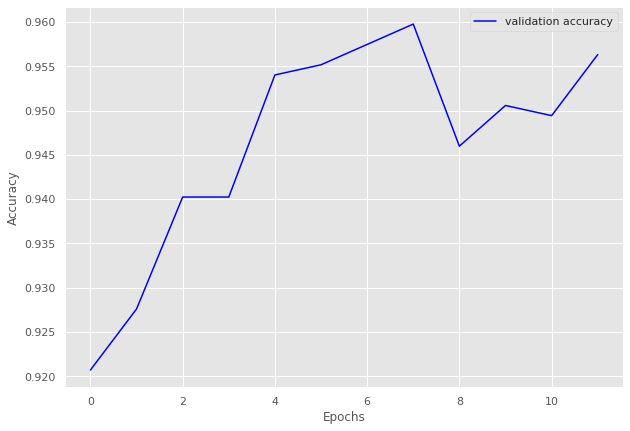

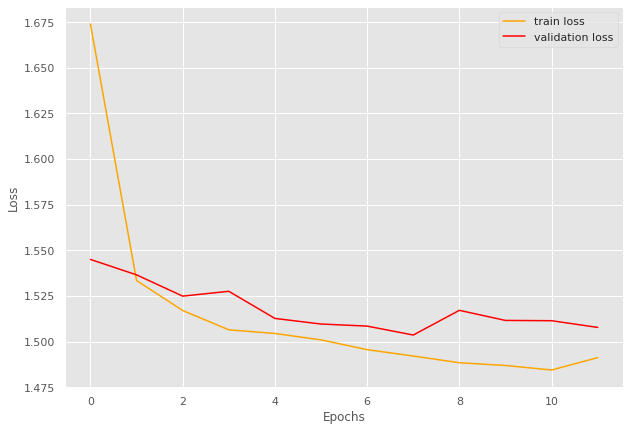

Done training of a fine model with test accuracy 0.9540098821740783
Coarse label 4 Epoch 1
-------------------------------


100%|██████████| 65/65 [00:22<00:00,  2.93batch/s, loss=1.26]


train loss 1.2640435035412128, validation loss 1.138417226927621, validation accuracy 0.9101941747572816
Coarse label 4 Epoch 2
-------------------------------


100%|██████████| 65/65 [00:22<00:00,  2.93batch/s, loss=1.1] 


train loss 1.1047775286894579, validation loss 1.1110856022153581, validation accuracy 0.9344660194174758
Coarse label 4 Epoch 3
-------------------------------


100%|██████████| 65/65 [00:24<00:00,  2.67batch/s, loss=1.08]


train loss 1.0848771186975332, validation loss 1.083928874560765, validation accuracy 0.9660194174757282
Coarse label 4 Epoch 4
-------------------------------


100%|██████████| 65/65 [00:41<00:00,  1.56batch/s, loss=1.08]


INFO: Early stopping counter 1 of 5
train loss 1.077134739435636, validation loss 1.0953642640795027, validation accuracy 0.9514563106796117
Coarse label 4 Epoch 5
-------------------------------


100%|██████████| 65/65 [00:51<00:00,  1.26batch/s, loss=1.07]


INFO: Early stopping counter 2 of 5
train loss 1.0706237462850718, validation loss 1.0908371210098267, validation accuracy 0.9538834951456311
Coarse label 4 Epoch 6
-------------------------------


100%|██████████| 65/65 [00:48<00:00,  1.35batch/s, loss=1.07]


INFO: Early stopping counter 3 of 5
train loss 1.0676440183932965, validation loss 1.0933783224650793, validation accuracy 0.9466019417475728
Coarse label 4 Epoch 7
-------------------------------


100%|██████████| 65/65 [00:47<00:00,  1.37batch/s, loss=1.06]


INFO: Early stopping counter 4 of 5
train loss 1.062421936255235, validation loss 1.0891676800591605, validation accuracy 0.9563106796116505
Coarse label 4 Epoch 8
-------------------------------


100%|██████████| 65/65 [00:22<00:00,  2.93batch/s, loss=1.06]


train loss 1.0647675385841957, validation loss 1.0760318551744734, validation accuracy 0.9635922330097088
Coarse label 4 Epoch 9
-------------------------------


100%|██████████| 65/65 [00:22<00:00,  2.93batch/s, loss=1.06]


INFO: Early stopping counter 5 of 5
INFO: Early stopping
Done! Saved model with test accuracy 0.964851086664878 and loss 1.081972427287344


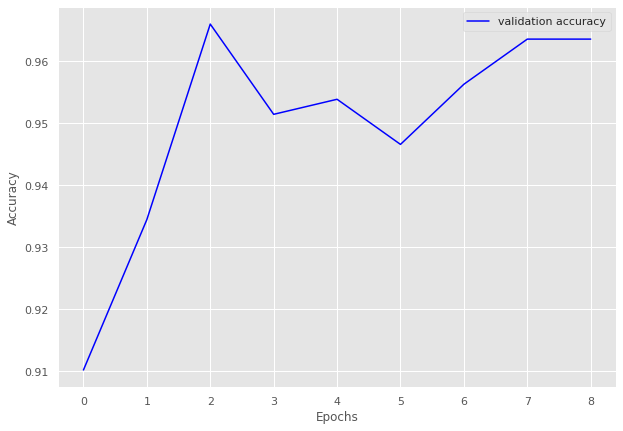

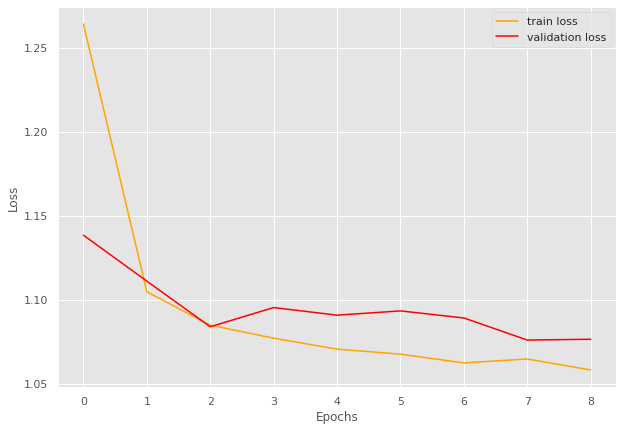

Done training of a fine model with test accuracy 0.964851086664878
Coarse label 5 Epoch 1
-------------------------------


100%|██████████| 25/25 [00:08<00:00,  2.94batch/s, loss=0.389]


train loss 0.3891936779022217, validation loss 0.32705479860305786, validation accuracy 0.9874213836477987
Coarse label 5 Epoch 2
-------------------------------


100%|██████████| 25/25 [00:08<00:00,  2.89batch/s, loss=0.331]


train loss 0.3306277847290039, validation loss 0.32539140184720355, validation accuracy 0.9874213836477987
Coarse label 5 Epoch 3
-------------------------------


100%|██████████| 25/25 [00:08<00:00,  2.91batch/s, loss=0.322]


train loss 0.3222512090206146, validation loss 0.32392017046610516, validation accuracy 0.9811320754716981
Coarse label 5 Epoch 4
-------------------------------


100%|██████████| 25/25 [00:08<00:00,  2.94batch/s, loss=0.322]


INFO: Early stopping counter 1 of 5
train loss 0.321941100358963, validation loss 0.3258125086625417, validation accuracy 0.9874213836477987
Coarse label 5 Epoch 5
-------------------------------


100%|██████████| 25/25 [00:08<00:00,  2.89batch/s, loss=0.321]


INFO: Early stopping counter 2 of 5
train loss 0.32112003326416017, validation loss 0.3277742564678192, validation accuracy 0.9811320754716981
Coarse label 5 Epoch 6
-------------------------------


100%|██████████| 25/25 [00:08<00:00,  2.89batch/s, loss=0.318]


train loss 0.3183166301250458, validation loss 0.3185063103834788, validation accuracy 0.9937106918238994
Coarse label 5 Epoch 7
-------------------------------


100%|██████████| 25/25 [00:08<00:00,  2.95batch/s, loss=0.316]


INFO: Early stopping counter 3 of 5
train loss 0.3161013078689575, validation loss 0.32238351305325824, validation accuracy 0.9811320754716981
Coarse label 5 Epoch 8
-------------------------------


100%|██████████| 25/25 [00:08<00:00,  2.91batch/s, loss=0.316]


train loss 0.315955730676651, validation loss 0.3171439468860626, validation accuracy 0.9937106918238994
Coarse label 5 Epoch 9
-------------------------------


100%|██████████| 25/25 [00:08<00:00,  2.90batch/s, loss=0.315]


INFO: Early stopping counter 4 of 5
train loss 0.3153201425075531, validation loss 0.32149795691172284, validation accuracy 0.9874213836477987
Coarse label 5 Epoch 10
-------------------------------


100%|██████████| 25/25 [00:08<00:00,  2.93batch/s, loss=0.315]


INFO: Early stopping counter 5 of 5
INFO: Early stopping
Done! Saved model with test accuracy 0.9791521890201529 and loss 0.33328699936037476


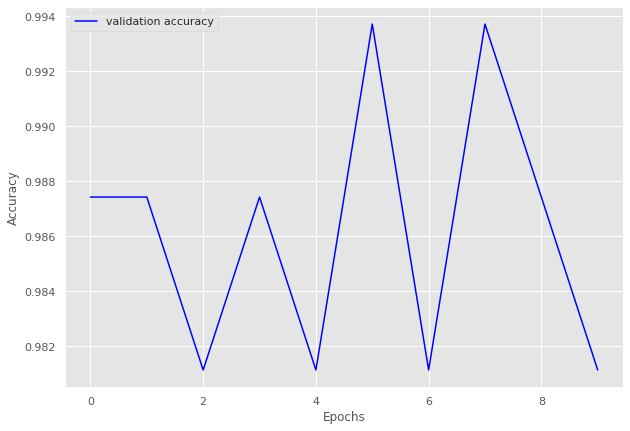

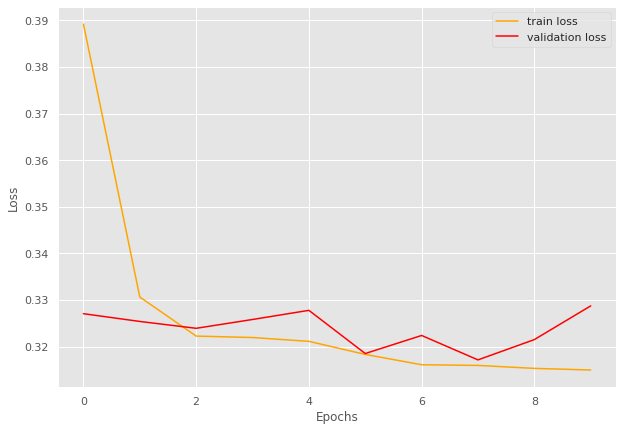

Done training of a fine model with test accuracy 0.9791521890201529
Coarse label 6 Epoch 1
-------------------------------


100%|██████████| 73/73 [00:25<00:00,  2.92batch/s, loss=1.34]


train loss 1.3425009103670513, validation loss 1.2342375665903091, validation accuracy 0.9288793103448276
Coarse label 6 Epoch 2
-------------------------------


100%|██████████| 73/73 [00:25<00:00,  2.91batch/s, loss=1.22]


train loss 1.2215549521250268, validation loss 1.2142543196678162, validation accuracy 0.9482758620689655
Coarse label 6 Epoch 3
-------------------------------


100%|██████████| 73/73 [00:25<00:00,  2.89batch/s, loss=1.21]


train loss 1.2095765006052304, validation loss 1.2111365497112274, validation accuracy 0.9504310344827587
Coarse label 6 Epoch 4
-------------------------------


100%|██████████| 73/73 [00:25<00:00,  2.90batch/s, loss=1.21]


train loss 1.2080784627836045, validation loss 1.2071683704853058, validation accuracy 0.9568965517241379
Coarse label 6 Epoch 5
-------------------------------


100%|██████████| 73/73 [00:25<00:00,  2.90batch/s, loss=1.21]


INFO: Early stopping counter 1 of 5
train loss 1.2067894804967594, validation loss 1.2169802337884903, validation accuracy 0.9461206896551724
Coarse label 6 Epoch 6
-------------------------------


100%|██████████| 73/73 [00:25<00:00,  2.86batch/s, loss=1.2] 


INFO: Early stopping counter 2 of 5
train loss 1.200673075571452, validation loss 1.2086502313613892, validation accuracy 0.9612068965517241
Coarse label 6 Epoch 7
-------------------------------


100%|██████████| 73/73 [00:25<00:00,  2.90batch/s, loss=1.19]


INFO: Early stopping counter 3 of 5
train loss 1.1931402781238294, validation loss 1.2094268798828125, validation accuracy 0.9525862068965517
Coarse label 6 Epoch 8
-------------------------------


100%|██████████| 73/73 [00:27<00:00,  2.68batch/s, loss=1.19]


train loss 1.1907066188446462, validation loss 1.2019251137971878, validation accuracy 0.9633620689655172
Coarse label 6 Epoch 9
-------------------------------


100%|██████████| 73/73 [00:25<00:00,  2.92batch/s, loss=1.19]


train loss 1.18763210348887, validation loss 1.193884715437889, validation accuracy 0.9676724137931034
Coarse label 6 Epoch 10
-------------------------------


100%|██████████| 73/73 [00:25<00:00,  2.88batch/s, loss=1.18]


INFO: Early stopping counter 4 of 5
train loss 1.184216171094816, validation loss 1.1965341866016388, validation accuracy 0.9655172413793104
Coarse label 6 Epoch 11
-------------------------------


100%|██████████| 73/73 [00:24<00:00,  2.93batch/s, loss=1.19]


train loss 1.1856281300113625, validation loss 1.1917866319417953, validation accuracy 0.9719827586206896
Coarse label 6 Epoch 12
-------------------------------


100%|██████████| 73/73 [00:25<00:00,  2.92batch/s, loss=1.19]


INFO: Early stopping counter 5 of 5
INFO: Early stopping
Done! Saved model with test accuracy 0.9548156956004756 and loss 1.2109101848168806


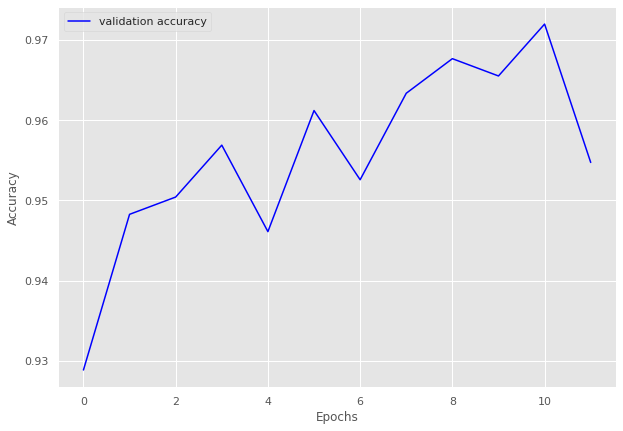

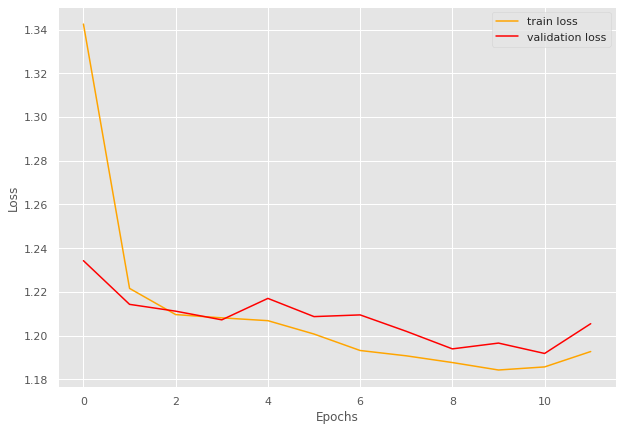

Done training of a fine model with test accuracy 0.9548156956004756
Coarse label 7 Epoch 1
-------------------------------


100%|██████████| 58/58 [00:20<00:00,  2.88batch/s, loss=0.86] 


train loss 0.8595979306204565, validation loss 0.7686377267042795, validation accuracy 0.9752066115702479
Coarse label 7 Epoch 2
-------------------------------


100%|██████████| 58/58 [00:19<00:00,  2.95batch/s, loss=0.772]


INFO: Early stopping counter 1 of 5
train loss 0.7720067583281418, validation loss 0.7694350679715475, validation accuracy 0.9724517906336089
Coarse label 7 Epoch 3
-------------------------------


100%|██████████| 58/58 [00:19<00:00,  2.94batch/s, loss=0.771]


train loss 0.7705698188008934, validation loss 0.7606094578901926, validation accuracy 0.9862258953168044
Coarse label 7 Epoch 4
-------------------------------


100%|██████████| 58/58 [00:19<00:00,  2.93batch/s, loss=0.764]


INFO: Early stopping counter 2 of 5
train loss 0.7642113782208542, validation loss 0.7664075195789337, validation accuracy 0.9807162534435262
Coarse label 7 Epoch 5
-------------------------------


100%|██████████| 58/58 [00:19<00:00,  2.93batch/s, loss=0.759]


INFO: Early stopping counter 3 of 5
train loss 0.7594359034094317, validation loss 0.7650539378325144, validation accuracy 0.977961432506887
Coarse label 7 Epoch 6
-------------------------------


100%|██████████| 58/58 [00:19<00:00,  2.94batch/s, loss=0.755]


INFO: Early stopping counter 4 of 5
train loss 0.7549301766116043, validation loss 0.7621493140856425, validation accuracy 0.9807162534435262
Coarse label 7 Epoch 7
-------------------------------


100%|██████████| 58/58 [00:19<00:00,  2.93batch/s, loss=0.761]


INFO: Early stopping counter 5 of 5
INFO: Early stopping
Done! Saved model with test accuracy 0.9784325637910085 and loss 0.7665038475623498


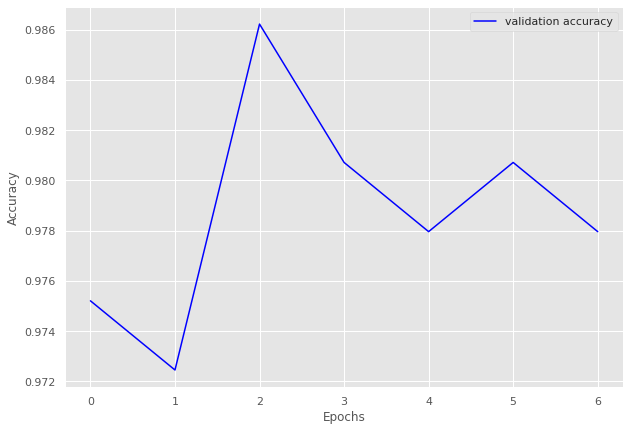

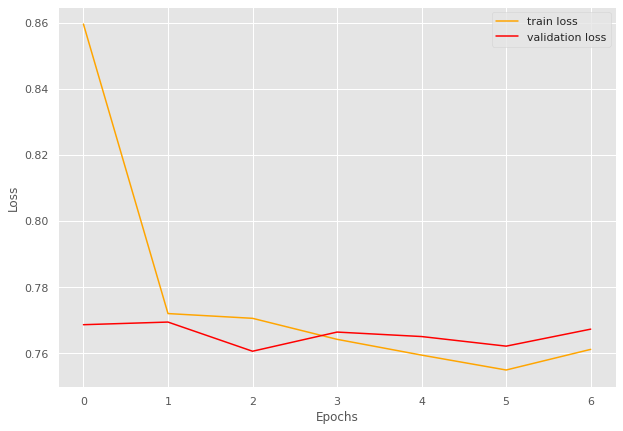

Done training of a fine model with test accuracy 0.9784325637910085
Coarse label 8 Epoch 1
-------------------------------


100%|██████████| 81/81 [00:28<00:00,  2.89batch/s, loss=1.37]


train loss 1.3739752946076569, validation loss 1.2476492077112198, validation accuracy 0.9217221135029354
Coarse label 8 Epoch 2
-------------------------------


100%|██████████| 81/81 [00:28<00:00,  2.88batch/s, loss=1.23]


train loss 1.2320565397356764, validation loss 1.23086616396904, validation accuracy 0.9373776908023483
Coarse label 8 Epoch 3
-------------------------------


100%|██████████| 81/81 [00:27<00:00,  2.90batch/s, loss=1.22]


train loss 1.2212369706895616, validation loss 1.2250846028327942, validation accuracy 0.9412915851272016
Coarse label 8 Epoch 4
-------------------------------


100%|██████████| 81/81 [00:28<00:00,  2.89batch/s, loss=1.21]


train loss 1.209617820786841, validation loss 1.2224431037902832, validation accuracy 0.9412915851272016
Coarse label 8 Epoch 5
-------------------------------


100%|██████████| 81/81 [00:28<00:00,  2.88batch/s, loss=1.21]


train loss 1.208944273583683, validation loss 1.2223312556743622, validation accuracy 0.9432485322896281
Coarse label 8 Epoch 6
-------------------------------


100%|██████████| 81/81 [00:27<00:00,  2.91batch/s, loss=1.2] 


INFO: Early stopping counter 1 of 5
train loss 1.1980517896605127, validation loss 1.2224405705928802, validation accuracy 0.9471624266144814
Coarse label 8 Epoch 7
-------------------------------


100%|██████████| 81/81 [00:27<00:00,  2.90batch/s, loss=1.2] 


train loss 1.197838662583151, validation loss 1.2067261040210724, validation accuracy 0.9608610567514677
Coarse label 8 Epoch 8
-------------------------------


100%|██████████| 81/81 [00:27<00:00,  2.91batch/s, loss=1.19]


INFO: Early stopping counter 2 of 5
train loss 1.1904419999063751, validation loss 1.2119436413049698, validation accuracy 0.9569471624266145
Coarse label 8 Epoch 9
-------------------------------


100%|██████████| 81/81 [00:28<00:00,  2.88batch/s, loss=1.19]


INFO: Early stopping counter 3 of 5
train loss 1.1904694783834764, validation loss 1.2106620222330093, validation accuracy 0.9569471624266145
Coarse label 8 Epoch 10
-------------------------------


100%|██████████| 81/81 [00:27<00:00,  2.91batch/s, loss=1.19]


INFO: Early stopping counter 4 of 5
train loss 1.1899454593658447, validation loss 1.2081920355558395, validation accuracy 0.9549902152641878
Coarse label 8 Epoch 11
-------------------------------


100%|██████████| 81/81 [00:27<00:00,  2.92batch/s, loss=1.19]


INFO: Early stopping counter 5 of 5
INFO: Early stopping
Done! Saved model with test accuracy 0.9474480968858131 and loss 1.218139844397976


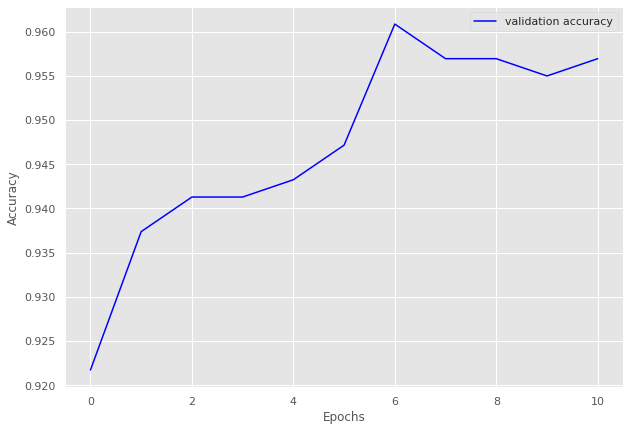

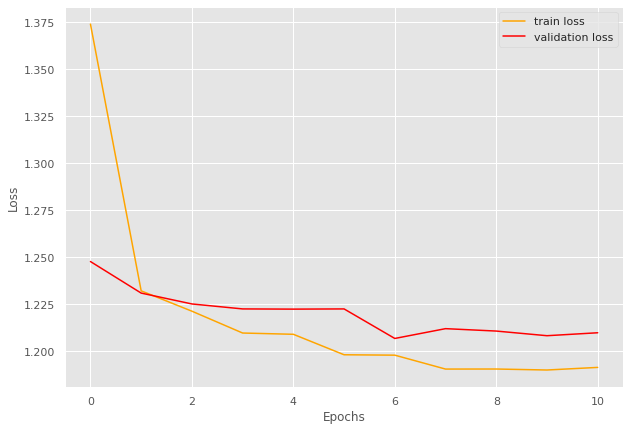

Done training of a fine model with test accuracy 0.9474480968858131
Coarse label 9 Epoch 1
-------------------------------


100%|██████████| 102/102 [00:35<00:00,  2.91batch/s, loss=1.65]


train loss 1.650317619828617, validation loss 1.5850775783712214, validation accuracy 0.8966049382716049
Coarse label 9 Epoch 2
-------------------------------


100%|██████████| 102/102 [00:35<00:00,  2.89batch/s, loss=1.53]


train loss 1.5261219260739345, validation loss 1.5647871711037376, validation accuracy 0.9228395061728395
Coarse label 9 Epoch 3
-------------------------------


100%|██████████| 102/102 [00:35<00:00,  2.90batch/s, loss=1.51]


train loss 1.5078869777567245, validation loss 1.5267025774175471, validation accuracy 0.9459876543209876
Coarse label 9 Epoch 4
-------------------------------


100%|██████████| 102/102 [00:35<00:00,  2.87batch/s, loss=1.5]


INFO: Early stopping counter 1 of 5
train loss 1.5006408551160026, validation loss 1.5302364175969905, validation accuracy 0.9351851851851852
Coarse label 9 Epoch 5
-------------------------------


100%|██████████| 102/102 [00:35<00:00,  2.91batch/s, loss=1.5]


INFO: Early stopping counter 2 of 5
train loss 1.4993663512024225, validation loss 1.5294493328441272, validation accuracy 0.9490740740740741
Coarse label 9 Epoch 6
-------------------------------


100%|██████████| 102/102 [00:35<00:00,  2.86batch/s, loss=1.49]


train loss 1.4898139647409028, validation loss 1.5232885534113103, validation accuracy 0.9537037037037037
Coarse label 9 Epoch 7
-------------------------------


100%|██████████| 102/102 [00:35<00:00,  2.88batch/s, loss=1.49]


train loss 1.4850304851344986, validation loss 1.522836771878329, validation accuracy 0.9490740740740741
Coarse label 9 Epoch 8
-------------------------------


100%|██████████| 102/102 [00:35<00:00,  2.87batch/s, loss=1.48]


train loss 1.4788682928272323, validation loss 1.522108879956332, validation accuracy 0.9645061728395061
Coarse label 9 Epoch 9
-------------------------------


100%|██████████| 102/102 [00:35<00:00,  2.90batch/s, loss=1.48]


train loss 1.4814608868430643, validation loss 1.5080760717391968, validation accuracy 0.9598765432098766
Coarse label 9 Epoch 10
-------------------------------


100%|██████████| 102/102 [00:35<00:00,  2.88batch/s, loss=1.48]


INFO: Early stopping counter 3 of 5
train loss 1.48069480119967, validation loss 1.543853922323747, validation accuracy 0.9506172839506173
Coarse label 9 Epoch 11
-------------------------------


100%|██████████| 102/102 [00:35<00:00,  2.89batch/s, loss=1.48]


INFO: Early stopping counter 4 of 5
train loss 1.4791754075125152, validation loss 1.5081602009859951, validation accuracy 0.9598765432098766
Coarse label 9 Epoch 12
-------------------------------


100%|██████████| 102/102 [00:46<00:00,  2.21batch/s, loss=1.48]


INFO: Early stopping counter 5 of 5
INFO: Early stopping
Done! Saved model with test accuracy 0.9612363387978142 and loss 1.5001898252445718


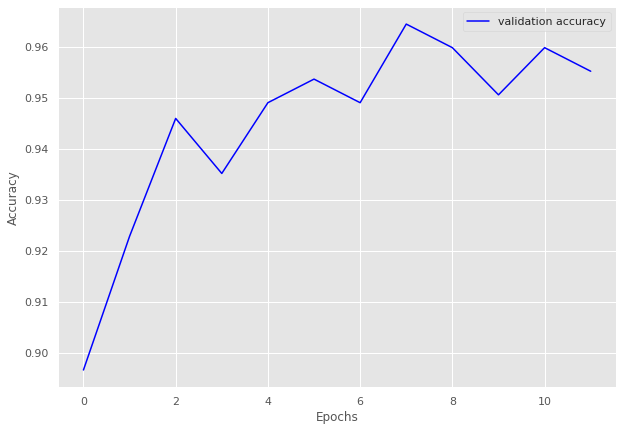

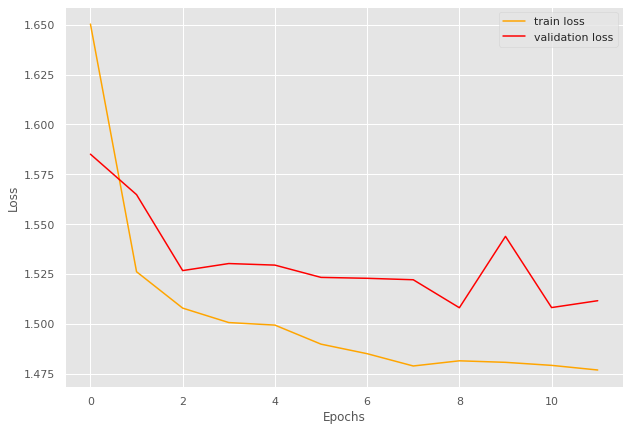

Done training of a fine model with test accuracy 0.9612363387978142
Coarse label 11 Epoch 1
-------------------------------


100%|██████████| 48/48 [00:36<00:00,  1.32batch/s, loss=0.868]


train loss 0.8683060643573602, validation loss 0.7820324182510376, validation accuracy 0.9605263157894737
Coarse label 11 Epoch 2
-------------------------------


100%|██████████| 48/48 [00:38<00:00,  1.26batch/s, loss=0.769]


INFO: Early stopping counter 1 of 5
train loss 0.7691261457900206, validation loss 0.7886232137680054, validation accuracy 0.9539473684210527
Coarse label 11 Epoch 3
-------------------------------


100%|██████████| 48/48 [00:36<00:00,  1.31batch/s, loss=0.759]


train loss 0.7589745658139387, validation loss 0.7726064562797547, validation accuracy 0.9703947368421053
Coarse label 11 Epoch 4
-------------------------------


100%|██████████| 48/48 [00:33<00:00,  1.41batch/s, loss=0.758]


INFO: Early stopping counter 2 of 5
train loss 0.7580398581922054, validation loss 0.7775895833969116, validation accuracy 0.9703947368421053
Coarse label 11 Epoch 5
-------------------------------


100%|██████████| 48/48 [00:16<00:00,  2.92batch/s, loss=0.755]


INFO: Early stopping counter 3 of 5
train loss 0.754759338994821, validation loss 0.7736198544502259, validation accuracy 0.9703947368421053
Coarse label 11 Epoch 6
-------------------------------


100%|██████████| 48/48 [00:16<00:00,  2.91batch/s, loss=0.753]


INFO: Early stopping counter 4 of 5
train loss 0.7527194631596407, validation loss 0.776581597328186, validation accuracy 0.9703947368421053
Coarse label 11 Epoch 7
-------------------------------


100%|██████████| 48/48 [00:16<00:00,  2.93batch/s, loss=0.753]


INFO: Early stopping counter 5 of 5
INFO: Early stopping
Done! Saved model with test accuracy 0.9760869565217392 and loss 0.7666704410856421


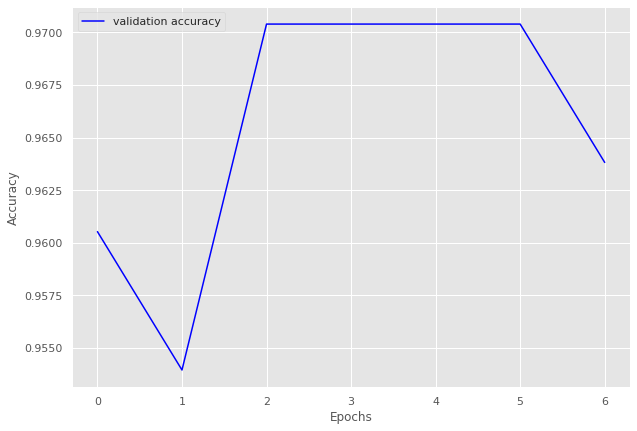

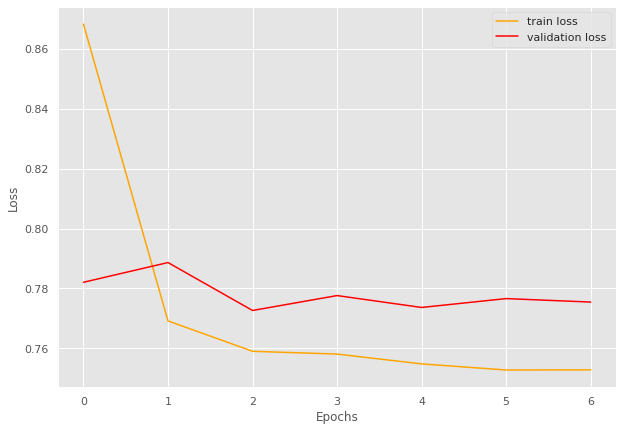

Done training of a fine model with test accuracy 0.9760869565217392
Coarse label 12 Epoch 1
-------------------------------


100%|██████████| 46/46 [00:16<00:00,  2.86batch/s, loss=1.31]


train loss 1.3058521177457727, validation loss 1.137963557243347, validation accuracy 0.9103448275862069
Coarse label 12 Epoch 2
-------------------------------


100%|██████████| 46/46 [00:15<00:00,  2.91batch/s, loss=1.12]


train loss 1.121070094730543, validation loss 1.1300163269042969, validation accuracy 0.903448275862069
Coarse label 12 Epoch 3
-------------------------------


100%|██████████| 46/46 [00:15<00:00,  2.94batch/s, loss=1.09]


train loss 1.0947940790134927, validation loss 1.1298949480056764, validation accuracy 0.9103448275862069
Coarse label 12 Epoch 4
-------------------------------


100%|██████████| 46/46 [00:16<00:00,  2.86batch/s, loss=1.09]


train loss 1.0884533861409063, validation loss 1.0964144706726073, validation accuracy 0.9448275862068966
Coarse label 12 Epoch 5
-------------------------------


100%|██████████| 46/46 [00:15<00:00,  2.97batch/s, loss=1.09]


INFO: Early stopping counter 1 of 5
train loss 1.0852747663207676, validation loss 1.1103792905807495, validation accuracy 0.9275862068965517
Coarse label 12 Epoch 6
-------------------------------


100%|██████████| 46/46 [00:15<00:00,  2.93batch/s, loss=1.08]


INFO: Early stopping counter 2 of 5
train loss 1.0808031066604282, validation loss 1.1100840330123902, validation accuracy 0.9344827586206896
Coarse label 12 Epoch 7
-------------------------------


100%|██████████| 46/46 [00:15<00:00,  2.97batch/s, loss=1.08]


INFO: Early stopping counter 3 of 5
train loss 1.0791372164436008, validation loss 1.121523642539978, validation accuracy 0.9103448275862069
Coarse label 12 Epoch 8
-------------------------------


100%|██████████| 46/46 [00:16<00:00,  2.87batch/s, loss=1.08]


INFO: Early stopping counter 4 of 5
train loss 1.0770688160606052, validation loss 1.1084396123886109, validation accuracy 0.9310344827586207
Coarse label 12 Epoch 9
-------------------------------


100%|██████████| 46/46 [00:15<00:00,  2.97batch/s, loss=1.08]


INFO: Early stopping counter 5 of 5
INFO: Early stopping
Done! Saved model with test accuracy 0.9200757575757575 and loss 1.1230427083514987


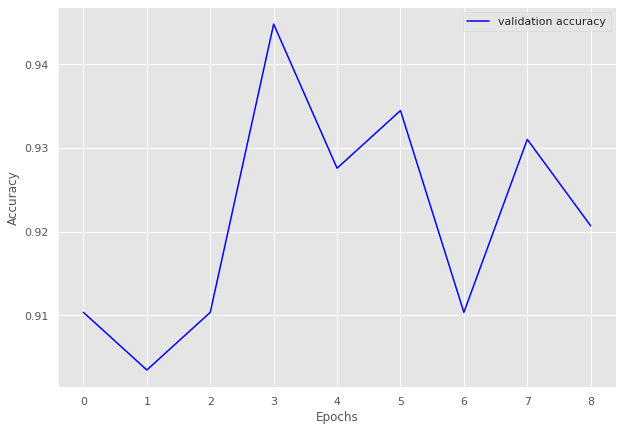

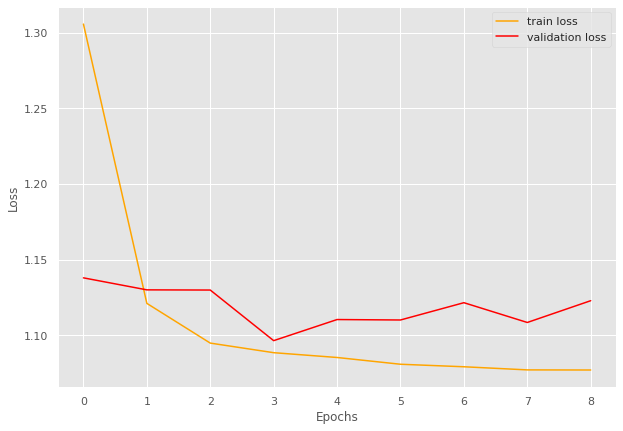

Done training of a fine model with test accuracy 0.9200757575757575
Coarse label 13 Epoch 1
-------------------------------


100%|██████████| 41/41 [00:13<00:00,  2.94batch/s, loss=0.673]


train loss 0.6734087060137492, validation loss 0.602617335319519, validation accuracy 0.9382239382239382
Coarse label 13 Epoch 2
-------------------------------


100%|██████████| 41/41 [00:13<00:00,  2.96batch/s, loss=0.602]


train loss 0.6021257071960263, validation loss 0.5955239176750183, validation accuracy 0.9420849420849421
Coarse label 13 Epoch 3
-------------------------------


100%|██████████| 41/41 [00:13<00:00,  2.93batch/s, loss=0.587]


train loss 0.5873417839771364, validation loss 0.5927362322807312, validation accuracy 0.9459459459459459
Coarse label 13 Epoch 4
-------------------------------


100%|██████████| 41/41 [00:13<00:00,  2.96batch/s, loss=0.579]


train loss 0.5789847330349248, validation loss 0.5908344745635986, validation accuracy 0.9498069498069498
Coarse label 13 Epoch 5
-------------------------------


100%|██████████| 41/41 [00:14<00:00,  2.85batch/s, loss=0.575]


INFO: Early stopping counter 1 of 5
train loss 0.5749923746760298, validation loss 0.5914553523063659, validation accuracy 0.9536679536679536
Coarse label 13 Epoch 6
-------------------------------


100%|██████████| 41/41 [00:13<00:00,  2.94batch/s, loss=0.581]


INFO: Early stopping counter 2 of 5
train loss 0.5809445119485622, validation loss 0.5951779961585999, validation accuracy 0.9420849420849421
Coarse label 13 Epoch 7
-------------------------------


100%|██████████| 41/41 [00:13<00:00,  2.93batch/s, loss=0.572]


INFO: Early stopping counter 3 of 5
train loss 0.5723664847815909, validation loss 0.5944421052932739, validation accuracy 0.9459459459459459
Coarse label 13 Epoch 8
-------------------------------


100%|██████████| 41/41 [00:14<00:00,  2.87batch/s, loss=0.571]


train loss 0.5707922025424678, validation loss 0.5793423414230346, validation accuracy 0.9691119691119691
Coarse label 13 Epoch 9
-------------------------------


100%|██████████| 41/41 [00:14<00:00,  2.89batch/s, loss=0.572]


INFO: Early stopping counter 4 of 5
train loss 0.5715781115904087, validation loss 0.5794004797935486, validation accuracy 0.9652509652509652
Coarse label 13 Epoch 10
-------------------------------


100%|██████████| 41/41 [00:13<00:00,  2.96batch/s, loss=0.569]


INFO: Early stopping counter 5 of 5
INFO: Early stopping
Done! Saved model with test accuracy 0.9594190516873131 and loss 0.5927416827227618


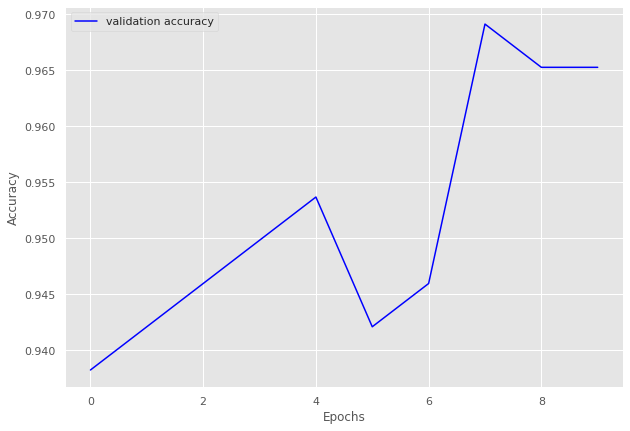

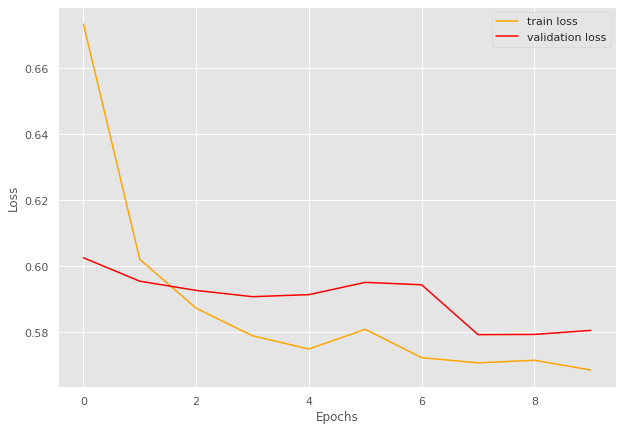

Done training of a fine model with test accuracy 0.9594190516873131
Coarse label 14 Epoch 1
-------------------------------


100%|██████████| 94/94 [00:32<00:00,  2.92batch/s, loss=1.16]


train loss 1.1643258662934, validation loss 1.1016133904457093, validation accuracy 0.9427609427609428
Coarse label 14 Epoch 2
-------------------------------


100%|██████████| 94/94 [00:32<00:00,  2.93batch/s, loss=1.09]


train loss 1.0859888817401642, validation loss 1.093033504486084, validation accuracy 0.9511784511784511
Coarse label 14 Epoch 3
-------------------------------


100%|██████████| 94/94 [00:32<00:00,  2.92batch/s, loss=1.07]


train loss 1.0740186166256032, validation loss 1.0908570528030395, validation accuracy 0.9528619528619529
Coarse label 14 Epoch 4
-------------------------------


100%|██████████| 94/94 [00:32<00:00,  2.90batch/s, loss=1.07]


train loss 1.0656226137851148, validation loss 1.083923065662384, validation accuracy 0.9595959595959596
Coarse label 14 Epoch 5
-------------------------------


100%|██████████| 94/94 [00:32<00:00,  2.90batch/s, loss=1.07]


INFO: Early stopping counter 1 of 5
train loss 1.0658384358629267, validation loss 1.0869028925895692, validation accuracy 0.9579124579124579
Coarse label 14 Epoch 6
-------------------------------


100%|██████████| 94/94 [00:32<00:00,  2.89batch/s, loss=1.06]


INFO: Early stopping counter 2 of 5
train loss 1.0636699744995604, validation loss 1.087170171737671, validation accuracy 0.9579124579124579
Coarse label 14 Epoch 7
-------------------------------


100%|██████████| 94/94 [00:32<00:00,  2.91batch/s, loss=1.06]


train loss 1.0573891616882163, validation loss 1.0832693099975585, validation accuracy 0.9629629629629629
Coarse label 14 Epoch 8
-------------------------------


100%|██████████| 94/94 [00:32<00:00,  2.91batch/s, loss=1.06]


INFO: Early stopping counter 3 of 5
train loss 1.0569423310300137, validation loss 1.0858569025993348, validation accuracy 0.9579124579124579
Coarse label 14 Epoch 9
-------------------------------


100%|██████████| 94/94 [00:32<00:00,  2.87batch/s, loss=1.06]


train loss 1.0555444486597751, validation loss 1.0800537943840027, validation accuracy 0.9629629629629629
Coarse label 14 Epoch 10
-------------------------------


100%|██████████| 94/94 [00:32<00:00,  2.92batch/s, loss=1.05]


INFO: Early stopping counter 4 of 5
train loss 1.054594928913928, validation loss 1.0813206434249878, validation accuracy 0.9629629629629629
Coarse label 14 Epoch 11
-------------------------------


100%|██████████| 94/94 [00:32<00:00,  2.89batch/s, loss=1.06]


INFO: Early stopping counter 5 of 5
INFO: Early stopping
Done! Saved model with test accuracy 0.9657674418604651 and loss 1.0780708917549677


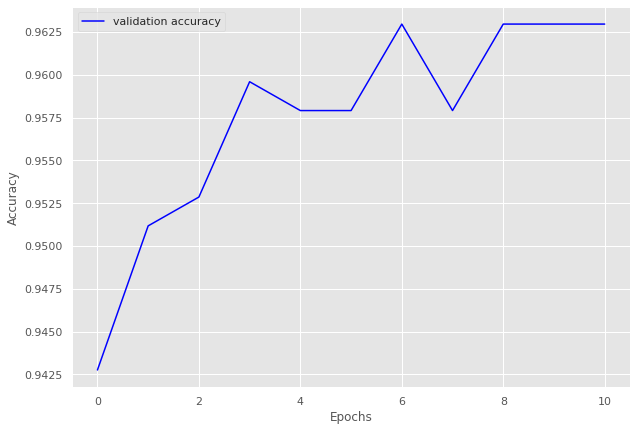

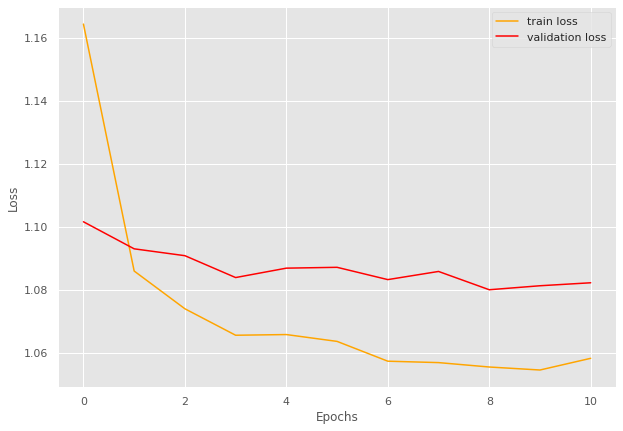

Done training of a fine model with test accuracy 0.9657674418604651
Coarse label 15 Epoch 1
-------------------------------


100%|██████████| 47/47 [00:16<00:00,  2.92batch/s, loss=0.895]


train loss 0.8946324307867821, validation loss 0.7914621353149414, validation accuracy 0.9523809523809523
Coarse label 15 Epoch 2
-------------------------------


100%|██████████| 47/47 [00:15<00:00,  2.96batch/s, loss=0.777]


train loss 0.7767561255617345, validation loss 0.7659798979759216, validation accuracy 0.9795918367346939
Coarse label 15 Epoch 3
-------------------------------


100%|██████████| 47/47 [00:15<00:00,  2.97batch/s, loss=0.764]


INFO: Early stopping counter 1 of 5
train loss 0.7640841933006935, validation loss 0.7684198617935181, validation accuracy 0.9727891156462585
Coarse label 15 Epoch 4
-------------------------------


100%|██████████| 47/47 [00:15<00:00,  2.94batch/s, loss=0.765]


train loss 0.76538599805629, validation loss 0.7596000075340271, validation accuracy 0.9829931972789115
Coarse label 15 Epoch 5
-------------------------------


100%|██████████| 47/47 [00:16<00:00,  2.93batch/s, loss=0.752]


INFO: Early stopping counter 2 of 5
train loss 0.7523225900974679, validation loss 0.7680822372436523, validation accuracy 0.9727891156462585
Coarse label 15 Epoch 6
-------------------------------


100%|██████████| 47/47 [00:15<00:00,  2.95batch/s, loss=0.762]


INFO: Early stopping counter 3 of 5
train loss 0.762499617769363, validation loss 0.7691380739212036, validation accuracy 0.9727891156462585
Coarse label 15 Epoch 7
-------------------------------


100%|██████████| 47/47 [00:15<00:00,  2.95batch/s, loss=0.766]


INFO: Early stopping counter 4 of 5
train loss 0.7655188758322533, validation loss 0.7707523584365845, validation accuracy 0.9727891156462585
Coarse label 15 Epoch 8
-------------------------------


100%|██████████| 47/47 [00:15<00:00,  2.97batch/s, loss=0.751]


INFO: Early stopping counter 5 of 5
INFO: Early stopping
Done! Saved model with test accuracy 0.9608138658628486 and loss 0.7814342564060575


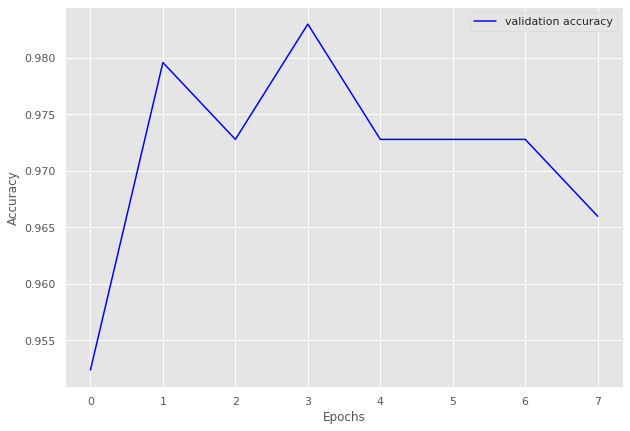

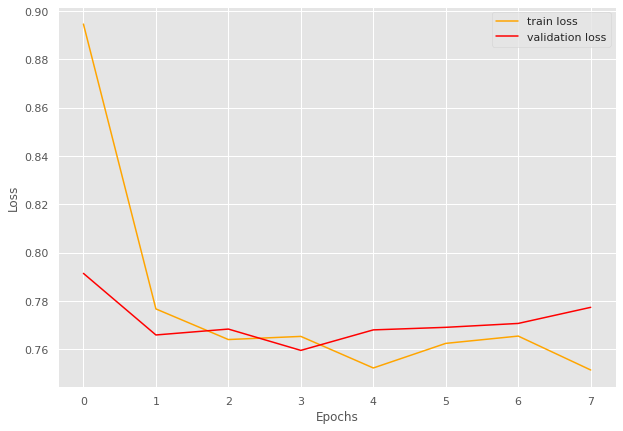

Done training of a fine model with test accuracy 0.9608138658628486
Coarse label 16 Epoch 1
-------------------------------


100%|██████████| 45/45 [00:15<00:00,  2.97batch/s, loss=0.671]


train loss 0.6705397579405042, validation loss 0.5903509140014649, validation accuracy 0.9645390070921985
Coarse label 16 Epoch 2
-------------------------------


100%|██████████| 45/45 [00:15<00:00,  2.94batch/s, loss=0.585]


train loss 0.5851050469610426, validation loss 0.5800487875938416, validation accuracy 0.9716312056737588
Coarse label 16 Epoch 3
-------------------------------


100%|██████████| 45/45 [00:15<00:00,  2.96batch/s, loss=0.578]


INFO: Early stopping counter 1 of 5
train loss 0.5784289770656161, validation loss 0.5881738662719727, validation accuracy 0.9574468085106383
Coarse label 16 Epoch 4
-------------------------------


100%|██████████| 45/45 [00:15<00:00,  2.96batch/s, loss=0.568]


INFO: Early stopping counter 2 of 5
train loss 0.5675869014528062, validation loss 0.602378785610199, validation accuracy 0.9574468085106383
Coarse label 16 Epoch 5
-------------------------------


100%|██████████| 45/45 [00:15<00:00,  2.93batch/s, loss=0.565]


train loss 0.565156090259552, validation loss 0.5787007927894592, validation accuracy 0.975177304964539
Coarse label 16 Epoch 6
-------------------------------


100%|██████████| 45/45 [00:15<00:00,  2.89batch/s, loss=0.567]


INFO: Early stopping counter 3 of 5
train loss 0.5674760553571913, validation loss 0.5849096179008484, validation accuracy 0.9680851063829787
Coarse label 16 Epoch 7
-------------------------------


100%|██████████| 45/45 [00:15<00:00,  2.91batch/s, loss=0.566]


INFO: Early stopping counter 4 of 5
train loss 0.5659765548176235, validation loss 0.5969009041786194, validation accuracy 0.9574468085106383
Coarse label 16 Epoch 8
-------------------------------


100%|██████████| 45/45 [00:15<00:00,  2.96batch/s, loss=0.56] 


train loss 0.5599871105617947, validation loss 0.5782525420188904, validation accuracy 0.9716312056737588
Coarse label 16 Epoch 9
-------------------------------


100%|██████████| 45/45 [00:15<00:00,  2.97batch/s, loss=0.562]


train loss 0.5619469549920824, validation loss 0.5754364132881165, validation accuracy 0.9787234042553191
Coarse label 16 Epoch 10
-------------------------------


100%|██████████| 45/45 [00:15<00:00,  2.97batch/s, loss=0.557]


INFO: Early stopping counter 5 of 5
INFO: Early stopping
Done! Saved model with test accuracy 0.9768445839874411 and loss 0.5737286418676376


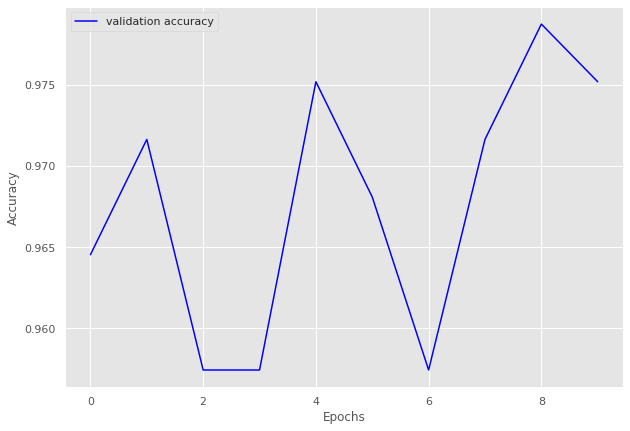

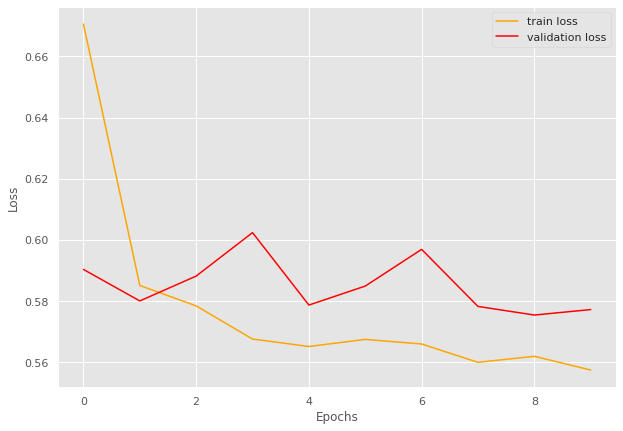

Done training of a fine model with test accuracy 0.9768445839874411
Coarse label 17 Epoch 1
-------------------------------


100%|██████████| 49/49 [00:17<00:00,  2.87batch/s, loss=0.921]


train loss 0.9208779943232633, validation loss 0.840045976638794, validation accuracy 0.8964401294498382
Coarse label 17 Epoch 2
-------------------------------


100%|██████████| 49/49 [00:16<00:00,  2.89batch/s, loss=0.801]


train loss 0.8011456910444765, validation loss 0.8165985584259033, validation accuracy 0.9158576051779935
Coarse label 17 Epoch 3
-------------------------------


100%|██████████| 49/49 [00:16<00:00,  2.94batch/s, loss=0.782]


train loss 0.7816752986032136, validation loss 0.7995572805404663, validation accuracy 0.941747572815534
Coarse label 17 Epoch 4
-------------------------------


100%|██████████| 49/49 [00:16<00:00,  2.93batch/s, loss=0.772]


INFO: Early stopping counter 1 of 5
train loss 0.7720422440645646, validation loss 0.8062071561813354, validation accuracy 0.9352750809061489
Coarse label 17 Epoch 5
-------------------------------


100%|██████████| 49/49 [00:16<00:00,  2.90batch/s, loss=0.764]


INFO: Early stopping counter 2 of 5
train loss 0.7644034660592371, validation loss 0.8074379563331604, validation accuracy 0.9352750809061489
Coarse label 17 Epoch 6
-------------------------------


100%|██████████| 49/49 [00:16<00:00,  2.93batch/s, loss=0.763]


INFO: Early stopping counter 3 of 5
train loss 0.7634264206399723, validation loss 0.8060646772384643, validation accuracy 0.9352750809061489
Coarse label 17 Epoch 7
-------------------------------


100%|██████████| 49/49 [00:16<00:00,  2.96batch/s, loss=0.759]


INFO: Early stopping counter 4 of 5
train loss 0.7586619549868058, validation loss 0.8068396091461182, validation accuracy 0.9352750809061489
Coarse label 17 Epoch 8
-------------------------------


100%|██████████| 49/49 [00:17<00:00,  2.88batch/s, loss=0.759]


INFO: Early stopping counter 5 of 5
INFO: Early stopping
Done! Saved model with test accuracy 0.9606017191977078 and loss 0.7841319753365084


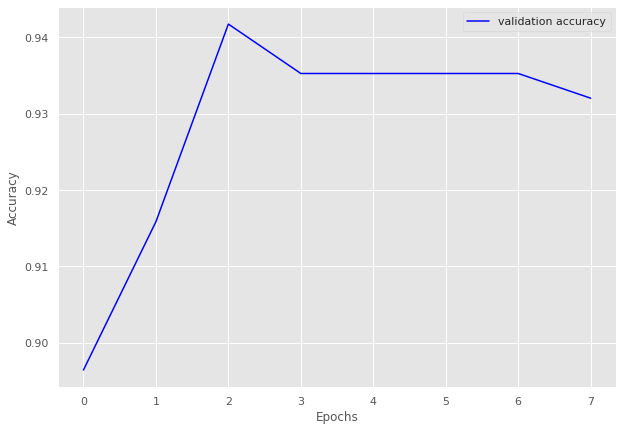

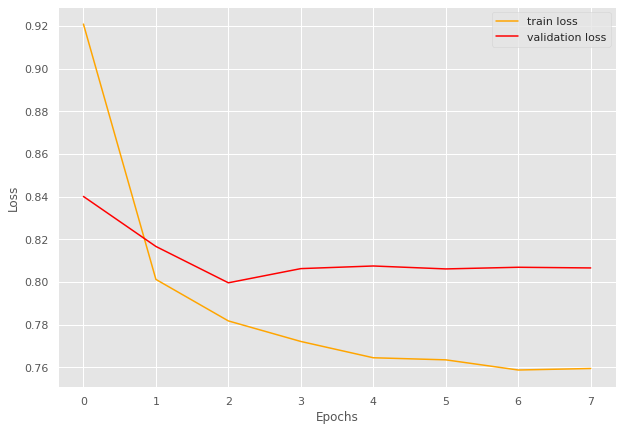

Done training of a fine model with test accuracy 0.9606017191977078
Coarse label 19 Epoch 1
-------------------------------


100%|██████████| 16/16 [00:05<00:00,  3.03batch/s, loss=1.06]


train loss 1.0595433861017227, validation loss 0.8429589569568634, validation accuracy 0.9166666666666666
Coarse label 19 Epoch 2
-------------------------------


100%|██████████| 16/16 [00:05<00:00,  3.06batch/s, loss=0.805]


train loss 0.8045531995594501, validation loss 0.806171178817749, validation accuracy 0.9375
Coarse label 19 Epoch 3
-------------------------------


100%|██████████| 16/16 [00:05<00:00,  2.94batch/s, loss=0.768]


train loss 0.7684287615120411, validation loss 0.8004859685897827, validation accuracy 0.9479166666666666
Coarse label 19 Epoch 4
-------------------------------


100%|██████████| 16/16 [00:05<00:00,  3.07batch/s, loss=0.757]


INFO: Early stopping counter 1 of 5
train loss 0.7566500604152679, validation loss 0.8134639263153076, validation accuracy 0.9270833333333334
Coarse label 19 Epoch 5
-------------------------------


100%|██████████| 16/16 [00:05<00:00,  3.09batch/s, loss=0.752]


train loss 0.7524346336722374, validation loss 0.7692241072654724, validation accuracy 0.9791666666666666
Coarse label 19 Epoch 6
-------------------------------


100%|██████████| 16/16 [00:05<00:00,  3.02batch/s, loss=0.75] 


INFO: Early stopping counter 2 of 5
train loss 0.7495358064770699, validation loss 0.7853061854839325, validation accuracy 0.9583333333333334
Coarse label 19 Epoch 7
-------------------------------


100%|██████████| 16/16 [00:05<00:00,  3.04batch/s, loss=0.755]


INFO: Early stopping counter 3 of 5
train loss 0.7547877952456474, validation loss 0.803071141242981, validation accuracy 0.9375
Coarse label 19 Epoch 8
-------------------------------


100%|██████████| 16/16 [00:05<00:00,  3.03batch/s, loss=0.761]


INFO: Early stopping counter 4 of 5
train loss 0.7614350207149982, validation loss 0.7883266806602478, validation accuracy 0.9583333333333334
Coarse label 19 Epoch 9
-------------------------------


100%|██████████| 16/16 [00:05<00:00,  3.07batch/s, loss=0.761]


INFO: Early stopping counter 5 of 5
INFO: Early stopping
Done! Saved model with test accuracy 0.9457013574660633 and loss 0.795269135917936


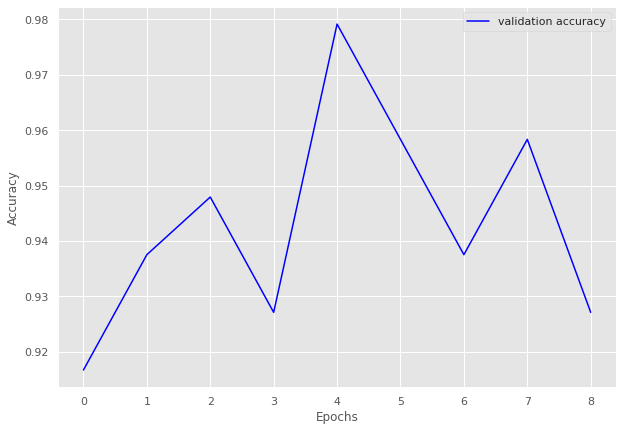

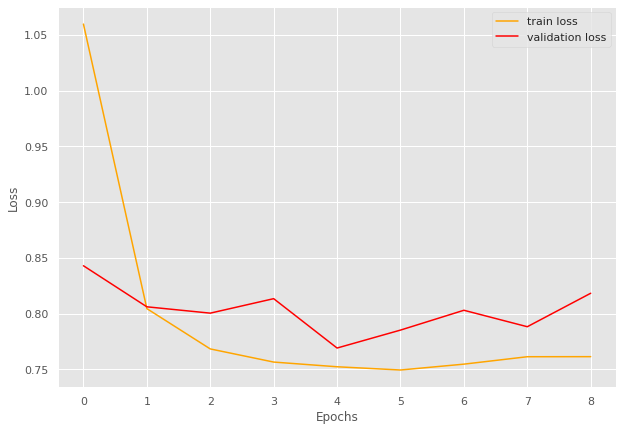

Done training of a fine model with test accuracy 0.9457013574660633
Starting model evaluation...
Evaluating fine model 0
Evaluating fine model 1
Evaluating fine model 2
Evaluating fine model 4
Evaluating fine model 5
Evaluating fine model 6
Evaluating fine model 7
Evaluating fine model 8
Evaluating fine model 9
Evaluating fine model 11
Evaluating fine model 12
Evaluating fine model 13
Evaluating fine model 14
Evaluating fine model 15
Evaluating fine model 16
Evaluating fine model 17
Evaluating fine model 19
overall accuracy  is 0.8173119751884785
Calculating for volume 10
Start training a coarse model
Epoch 1
-------------------------------


100%|██████████| 1052/1052 [06:04<00:00,  2.89batch/s, loss=2.54]


train loss 2.539420395976237, validation loss 2.4673976489475797, validation accuracy 0.6122571001494769
Epoch 2
-------------------------------


100%|██████████| 1052/1052 [06:05<00:00,  2.88batch/s, loss=2.45]


train loss 2.453816224866947, validation loss 2.4389269306546164, validation accuracy 0.6400597907324365
Epoch 3
-------------------------------


100%|██████████| 1052/1052 [07:54<00:00,  2.22batch/s, loss=2.42]


train loss 2.420383527931605, validation loss 2.4139235837118966, validation accuracy 0.6662182361733932
Epoch 4
-------------------------------


100%|██████████| 1052/1052 [06:07<00:00,  2.86batch/s, loss=2.39]


train loss 2.392691824599364, validation loss 2.3988822301228843, validation accuracy 0.6816143497757847
Epoch 5
-------------------------------


100%|██████████| 1052/1052 [06:06<00:00,  2.87batch/s, loss=2.38]


train loss 2.3815265318286736, validation loss 2.3831793944040935, validation accuracy 0.6973094170403588
Epoch 6
-------------------------------


100%|██████████| 1052/1052 [06:07<00:00,  2.86batch/s, loss=2.37]


INFO: Early stopping counter 1 of 5
train loss 2.37458288782903, validation loss 2.3843661353701635, validation accuracy 0.695067264573991
Epoch 7
-------------------------------


100%|██████████| 1052/1052 [08:21<00:00,  2.10batch/s, loss=2.37]


train loss 2.369203009532885, validation loss 2.3826139336540586, validation accuracy 0.6962630792227205
Epoch 8
-------------------------------


100%|██████████| 1052/1052 [06:38<00:00,  2.64batch/s, loss=2.36]


INFO: Early stopping counter 2 of 5
train loss 2.3622287278392924, validation loss 2.3860731215704054, validation accuracy 0.6931240657698057
Epoch 9
-------------------------------


100%|██████████| 1052/1052 [06:14<00:00,  2.81batch/s, loss=2.35]


train loss 2.3471292461279227, validation loss 2.362380397887457, validation accuracy 0.7174887892376681
Epoch 10
-------------------------------


100%|██████████| 1052/1052 [06:05<00:00,  2.88batch/s, loss=2.34]


INFO: Early stopping counter 3 of 5
train loss 2.338672441674729, validation loss 2.364291715621948, validation accuracy 0.7161434977578476
Epoch 11
-------------------------------


100%|██████████| 1052/1052 [07:46<00:00,  2.26batch/s, loss=2.33]


train loss 2.332987452187919, validation loss 2.353374013446626, validation accuracy 0.7269058295964126
Epoch 12
-------------------------------


100%|██████████| 1052/1052 [06:08<00:00,  2.85batch/s, loss=2.33]


INFO: Early stopping counter 4 of 5
train loss 2.3269312089387, validation loss 2.361817019326346, validation accuracy 0.7180866965620328
Epoch 13
-------------------------------


100%|██████████| 1052/1052 [06:04<00:00,  2.89batch/s, loss=2.32]


train loss 2.3180019685524047, validation loss 2.3429326806749615, validation accuracy 0.7369207772795217
Epoch 14
-------------------------------


100%|██████████| 1052/1052 [06:05<00:00,  2.88batch/s, loss=2.31]


INFO: Early stopping counter 5 of 5
INFO: Early stopping
Done! Saved model with test accuracy 0.8144084992658825 and loss 2.2641640338213636


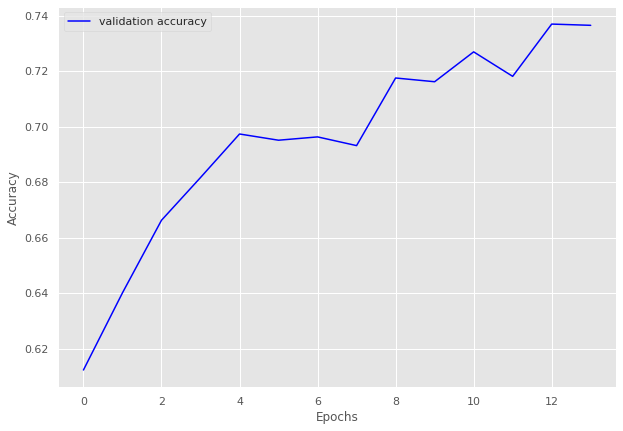

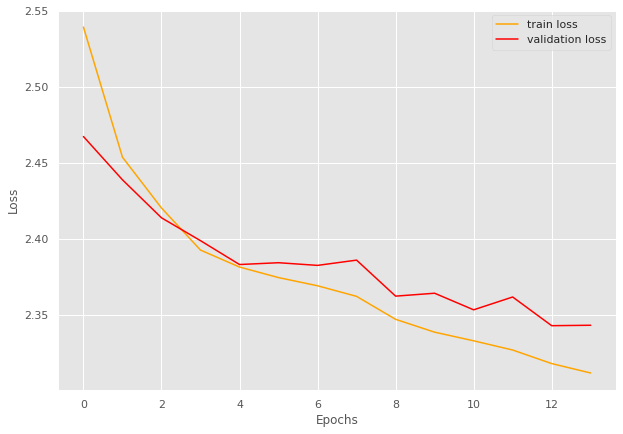

Done training of a coarse model with test accuracy 0.8144084992658825
Coarse label 0 Epoch 1
-------------------------------


100%|██████████| 67/67 [00:22<00:00,  2.93batch/s, loss=1.14]


train loss 1.1358293535104438, validation loss 1.0489911947931563, validation accuracy 0.8594847775175644
Coarse label 0 Epoch 2
-------------------------------


100%|██████████| 67/67 [00:22<00:00,  2.94batch/s, loss=1.02]


train loss 1.0173404465860396, validation loss 1.037325986794063, validation accuracy 0.8665105386416861
Coarse label 0 Epoch 3
-------------------------------


100%|██████████| 67/67 [00:23<00:00,  2.90batch/s, loss=0.994]


train loss 0.9938428072787043, validation loss 1.0156216961996896, validation accuracy 0.8875878220140515
Coarse label 0 Epoch 4
-------------------------------


100%|██████████| 67/67 [00:23<00:00,  2.91batch/s, loss=0.986]


train loss 0.9861750255769758, validation loss 1.0137353369167872, validation accuracy 0.892271662763466
Coarse label 0 Epoch 5
-------------------------------


100%|██████████| 67/67 [00:22<00:00,  2.93batch/s, loss=0.987]


INFO: Early stopping counter 1 of 5
train loss 0.9873118195960771, validation loss 1.0237771102360316, validation accuracy 0.8852459016393442
Coarse label 0 Epoch 6
-------------------------------


100%|██████████| 67/67 [00:22<00:00,  2.92batch/s, loss=0.983]


INFO: Early stopping counter 2 of 5
train loss 0.9829550598984333, validation loss 1.0233679924692427, validation accuracy 0.8805620608899297
Coarse label 0 Epoch 7
-------------------------------


100%|██████████| 67/67 [00:22<00:00,  2.94batch/s, loss=0.977]


INFO: Early stopping counter 3 of 5
train loss 0.9768186433991389, validation loss 1.0230125103678023, validation accuracy 0.8852459016393442
Coarse label 0 Epoch 8
-------------------------------


100%|██████████| 67/67 [00:40<00:00,  1.64batch/s, loss=0.974]


INFO: Early stopping counter 4 of 5
train loss 0.974001219913141, validation loss 1.0197624479021346, validation accuracy 0.882903981264637
Coarse label 0 Epoch 9
-------------------------------


100%|██████████| 67/67 [00:44<00:00,  1.50batch/s, loss=0.967]


train loss 0.9665984804950544, validation loss 1.0111575211797441, validation accuracy 0.8969555035128806
Coarse label 0 Epoch 10
-------------------------------


100%|██████████| 67/67 [00:52<00:00,  1.28batch/s, loss=0.964]


INFO: Early stopping counter 5 of 5
INFO: Early stopping
Done! Saved model with test accuracy 0.9535062933470332 and loss 0.9506466242133594


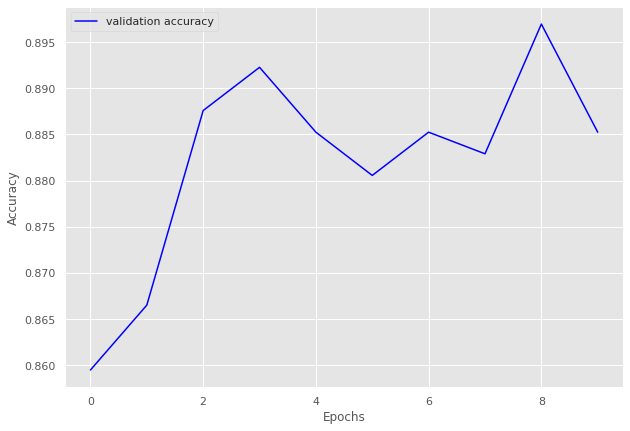

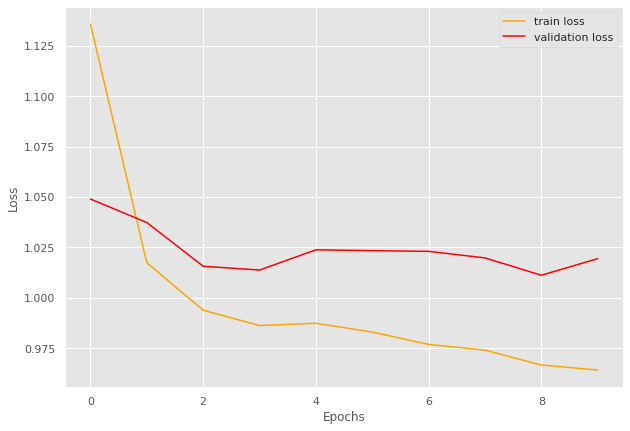

Done training of a fine model with test accuracy 0.9535062933470332
Coarse label 1 Epoch 1
-------------------------------


100%|██████████| 33/33 [00:25<00:00,  1.27batch/s, loss=1.39]


train loss 1.3944665916038281, validation loss 1.2961593866348267, validation accuracy 0.7714285714285715
Coarse label 1 Epoch 2
-------------------------------


100%|██████████| 33/33 [00:18<00:00,  1.74batch/s, loss=1.22]


train loss 1.2213796052065762, validation loss 1.2629165947437286, validation accuracy 0.7857142857142857
Coarse label 1 Epoch 3
-------------------------------


100%|██████████| 33/33 [00:11<00:00,  2.90batch/s, loss=1.17]


INFO: Early stopping counter 1 of 5
train loss 1.1736053445122459, validation loss 1.268256515264511, validation accuracy 0.7952380952380952
Coarse label 1 Epoch 4
-------------------------------


100%|██████████| 33/33 [00:11<00:00,  2.83batch/s, loss=1.15]


INFO: Early stopping counter 2 of 5
train loss 1.1465343562039463, validation loss 1.2668722867965698, validation accuracy 0.7952380952380952
Coarse label 1 Epoch 5
-------------------------------


100%|██████████| 33/33 [00:11<00:00,  2.93batch/s, loss=1.12]


INFO: Early stopping counter 3 of 5
train loss 1.1242071679144194, validation loss 1.2660523056983948, validation accuracy 0.7904761904761904
Coarse label 1 Epoch 6
-------------------------------


100%|██████████| 33/33 [00:11<00:00,  2.94batch/s, loss=1.11]


train loss 1.109369321302934, validation loss 1.2609995305538177, validation accuracy 0.7857142857142857
Coarse label 1 Epoch 7
-------------------------------


100%|██████████| 33/33 [00:11<00:00,  2.93batch/s, loss=1.1] 


INFO: Early stopping counter 4 of 5
train loss 1.1002426291957046, validation loss 1.283399224281311, validation accuracy 0.7714285714285715
Coarse label 1 Epoch 8
-------------------------------


100%|██████████| 33/33 [00:11<00:00,  2.88batch/s, loss=1.09]


INFO: Early stopping counter 5 of 5
INFO: Early stopping
Done! Saved model with test accuracy 0.9457547169811321 and loss 1.0988758405049641


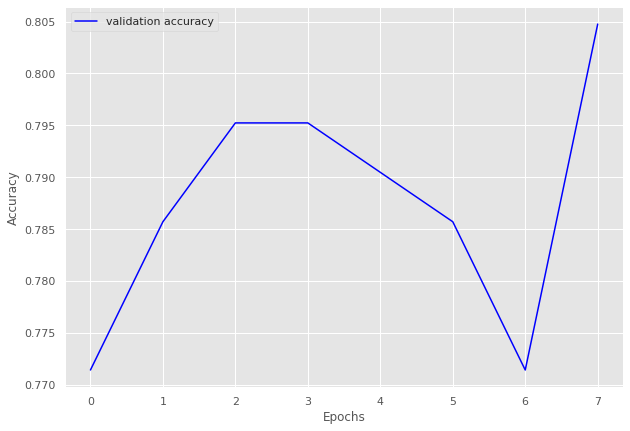

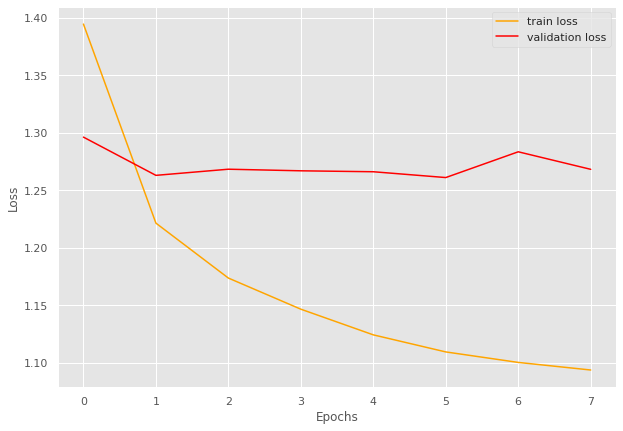

Done training of a fine model with test accuracy 0.9457547169811321
Coarse label 2 Epoch 1
-------------------------------


100%|██████████| 135/135 [00:46<00:00,  2.90batch/s, loss=1.73]


train loss 1.72910912655018, validation loss 1.6153451119150435, validation accuracy 0.8504027617951668
Coarse label 2 Epoch 2
-------------------------------


100%|██████████| 135/135 [00:46<00:00,  2.90batch/s, loss=1.6]


train loss 1.5977564811706544, validation loss 1.5939170633043562, validation accuracy 0.8711162255466053
Coarse label 2 Epoch 3
-------------------------------


100%|██████████| 135/135 [00:47<00:00,  2.87batch/s, loss=1.58]


INFO: Early stopping counter 1 of 5
train loss 1.5791761963455766, validation loss 1.5970671943255834, validation accuracy 0.8619102416570771
Coarse label 2 Epoch 4
-------------------------------


100%|██████████| 135/135 [00:47<00:00,  2.87batch/s, loss=1.57]


INFO: Early stopping counter 2 of 5
train loss 1.5710271411471897, validation loss 1.5973528453281947, validation accuracy 0.8619102416570771
Coarse label 2 Epoch 5
-------------------------------


100%|██████████| 135/135 [00:46<00:00,  2.87batch/s, loss=1.56]


INFO: Early stopping counter 3 of 5
train loss 1.5614265185815317, validation loss 1.609906358378274, validation accuracy 0.85385500575374
Coarse label 2 Epoch 6
-------------------------------


100%|██████████| 135/135 [00:46<00:00,  2.89batch/s, loss=1.56]


train loss 1.5561300418995045, validation loss 1.590836192880358, validation accuracy 0.8711162255466053
Coarse label 2 Epoch 7
-------------------------------


100%|██████████| 135/135 [00:47<00:00,  2.87batch/s, loss=1.55]


train loss 1.5498610125647652, validation loss 1.589973475251879, validation accuracy 0.8722669735327964
Coarse label 2 Epoch 8
-------------------------------


100%|██████████| 135/135 [00:47<00:00,  2.86batch/s, loss=1.55]


INFO: Early stopping counter 4 of 5
train loss 1.5486490585185864, validation loss 1.5923588020460946, validation accuracy 0.8688147295742232
Coarse label 2 Epoch 9
-------------------------------


100%|██████████| 135/135 [00:46<00:00,  2.90batch/s, loss=1.55]


INFO: Early stopping counter 5 of 5
INFO: Early stopping
Done! Saved model with test accuracy 0.9343722285569492 and loss 1.5283878859012359


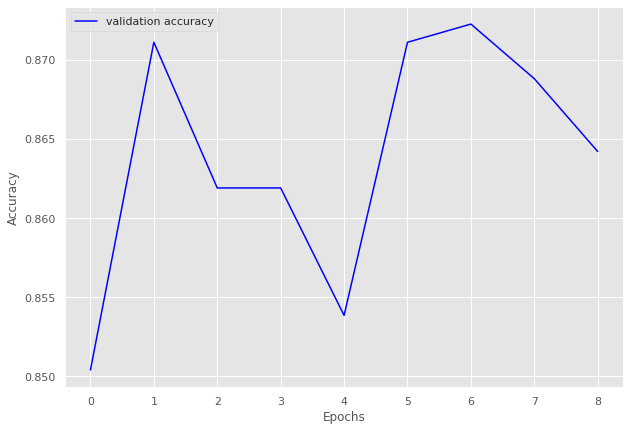

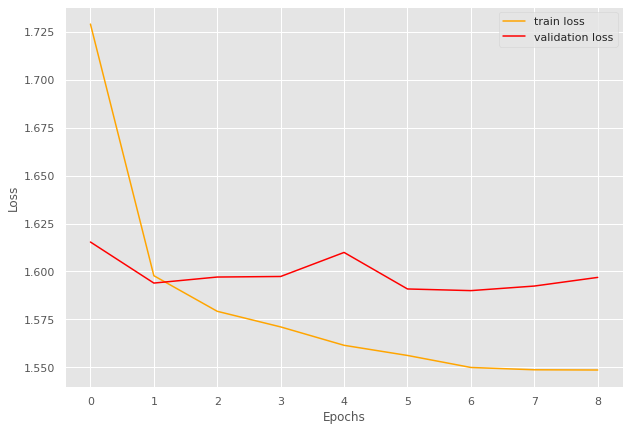

Done training of a fine model with test accuracy 0.9343722285569492
Coarse label 4 Epoch 1
-------------------------------


100%|██████████| 65/65 [00:22<00:00,  2.92batch/s, loss=1.31]


train loss 1.3111264540598944, validation loss 1.1830621446881975, validation accuracy 0.8673218673218673
Coarse label 4 Epoch 2
-------------------------------


100%|██████████| 65/65 [00:22<00:00,  2.92batch/s, loss=1.18]


train loss 1.1756372213363648, validation loss 1.1696013723100935, validation accuracy 0.8771498771498771
Coarse label 4 Epoch 3
-------------------------------


100%|██████████| 65/65 [00:22<00:00,  2.92batch/s, loss=1.14]


train loss 1.144477312381451, validation loss 1.1561367852347237, validation accuracy 0.9017199017199017
Coarse label 4 Epoch 4
-------------------------------


100%|██████████| 65/65 [00:22<00:00,  2.90batch/s, loss=1.13]


train loss 1.1308013475858247, validation loss 1.1539433343069894, validation accuracy 0.8992628992628993
Coarse label 4 Epoch 5
-------------------------------


100%|██████████| 65/65 [00:22<00:00,  2.91batch/s, loss=1.12]


INFO: Early stopping counter 1 of 5
train loss 1.1244348214222835, validation loss 1.1690750803266252, validation accuracy 0.8697788697788698
Coarse label 4 Epoch 6
-------------------------------


100%|██████████| 65/65 [00:22<00:00,  2.86batch/s, loss=1.11]


INFO: Early stopping counter 2 of 5
train loss 1.1143337818292471, validation loss 1.1653722524642944, validation accuracy 0.8869778869778869
Coarse label 4 Epoch 7
-------------------------------


100%|██████████| 65/65 [00:22<00:00,  2.90batch/s, loss=1.11]


INFO: Early stopping counter 3 of 5
train loss 1.1133998504051796, validation loss 1.1645149333136422, validation accuracy 0.8796068796068796
Coarse label 4 Epoch 8
-------------------------------


100%|██████████| 65/65 [00:22<00:00,  2.92batch/s, loss=1.1] 


INFO: Early stopping counter 4 of 5
train loss 1.1030109148759109, validation loss 1.1661767618996757, validation accuracy 0.8796068796068796
Coarse label 4 Epoch 9
-------------------------------


100%|██████████| 65/65 [00:22<00:00,  2.92batch/s, loss=1.1] 


INFO: Early stopping counter 5 of 5
INFO: Early stopping
Done! Saved model with test accuracy 0.94311778910652 and loss 1.0999597452454648


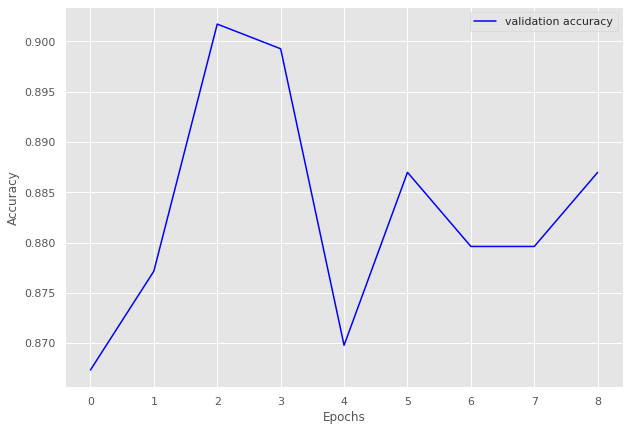

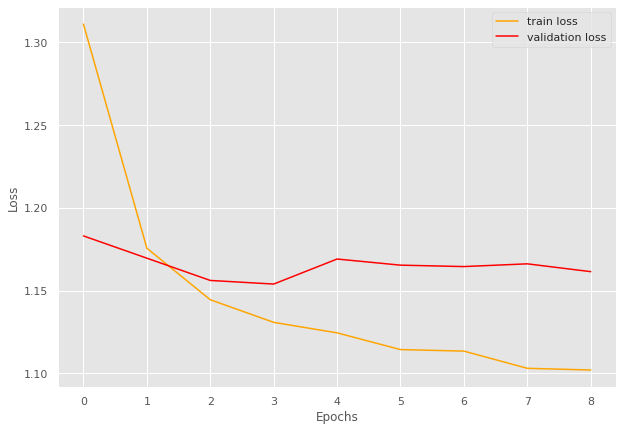

Done training of a fine model with test accuracy 0.94311778910652
Coarse label 5 Epoch 1
-------------------------------


100%|██████████| 25/25 [00:08<00:00,  2.86batch/s, loss=0.441]


train loss 0.44135809421539307, validation loss 0.3681254784266154, validation accuracy 0.9487179487179487
Coarse label 5 Epoch 2
-------------------------------


100%|██████████| 25/25 [00:08<00:00,  2.97batch/s, loss=0.364]


INFO: Early stopping counter 1 of 5
train loss 0.3641063141822815, validation loss 0.3747983475526174, validation accuracy 0.9423076923076923
Coarse label 5 Epoch 3
-------------------------------


100%|██████████| 25/25 [00:08<00:00,  2.89batch/s, loss=0.352]


INFO: Early stopping counter 2 of 5
train loss 0.351961989402771, validation loss 0.37644943594932556, validation accuracy 0.9423076923076923
Coarse label 5 Epoch 4
-------------------------------


100%|██████████| 25/25 [00:08<00:00,  3.00batch/s, loss=0.35] 


INFO: Early stopping counter 3 of 5
train loss 0.3498908269405365, validation loss 0.40135207772254944, validation accuracy 0.9230769230769231
Coarse label 5 Epoch 5
-------------------------------


100%|██████████| 25/25 [00:08<00:00,  2.87batch/s, loss=0.338]


INFO: Early stopping counter 4 of 5
train loss 0.33845868706703186, validation loss 0.38669390479723614, validation accuracy 0.9230769230769231
Coarse label 5 Epoch 6
-------------------------------


100%|██████████| 25/25 [00:08<00:00,  2.91batch/s, loss=0.337]


INFO: Early stopping counter 5 of 5
INFO: Early stopping
Done! Saved model with test accuracy 0.9701181375955524 and loss 0.3431785858195761


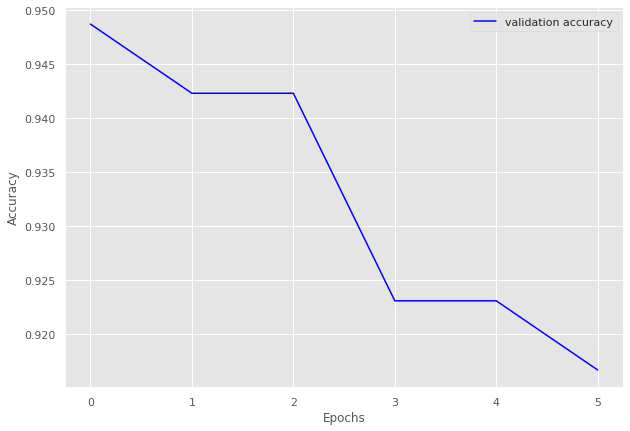

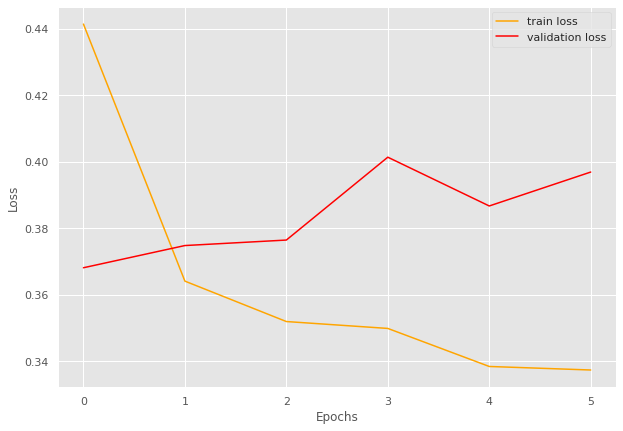

Done training of a fine model with test accuracy 0.9701181375955524
Coarse label 6 Epoch 1
-------------------------------


100%|██████████| 74/74 [00:25<00:00,  2.88batch/s, loss=1.43]


train loss 1.4274356397422585, validation loss 1.3237571205411638, validation accuracy 0.8430493273542601
Coarse label 6 Epoch 2
-------------------------------


100%|██████████| 74/74 [00:26<00:00,  2.83batch/s, loss=1.3] 


train loss 1.3032696166554012, validation loss 1.3050082240785872, validation accuracy 0.8632286995515696
Coarse label 6 Epoch 3
-------------------------------


100%|██████████| 74/74 [00:25<00:00,  2.89batch/s, loss=1.29]


train loss 1.286179534486822, validation loss 1.3004958629608154, validation accuracy 0.8632286995515696
Coarse label 6 Epoch 4
-------------------------------


100%|██████████| 74/74 [00:26<00:00,  2.84batch/s, loss=1.27]


train loss 1.2709575714291752, validation loss 1.2997643436704363, validation accuracy 0.8699551569506726
Coarse label 6 Epoch 5
-------------------------------


100%|██████████| 74/74 [00:25<00:00,  2.86batch/s, loss=1.26]


train loss 1.262636880616884, validation loss 1.2954854454313005, validation accuracy 0.8677130044843049
Coarse label 6 Epoch 6
-------------------------------


100%|██████████| 74/74 [00:25<00:00,  2.90batch/s, loss=1.25]


INFO: Early stopping counter 1 of 5
train loss 1.2520171564978522, validation loss 1.3136683702468872, validation accuracy 0.852017937219731
Coarse label 6 Epoch 7
-------------------------------


100%|██████████| 74/74 [00:25<00:00,  2.90batch/s, loss=1.25]


train loss 1.251477230239559, validation loss 1.2922965799059187, validation accuracy 0.8699551569506726
Coarse label 6 Epoch 8
-------------------------------


100%|██████████| 74/74 [00:25<00:00,  2.91batch/s, loss=1.24]


INFO: Early stopping counter 2 of 5
train loss 1.2368175371273145, validation loss 1.296126195362636, validation accuracy 0.8677130044843049
Coarse label 6 Epoch 9
-------------------------------


100%|██████████| 74/74 [00:25<00:00,  2.91batch/s, loss=1.24]


train loss 1.2387435033514693, validation loss 1.2870144503457206, validation accuracy 0.8766816143497758
Coarse label 6 Epoch 10
-------------------------------


100%|██████████| 74/74 [00:25<00:00,  2.88batch/s, loss=1.23]


INFO: Early stopping counter 3 of 5
train loss 1.229342338201162, validation loss 1.2890079362051827, validation accuracy 0.8789237668161435
Coarse label 6 Epoch 11
-------------------------------


100%|██████████| 74/74 [00:25<00:00,  2.87batch/s, loss=1.23]


INFO: Early stopping counter 4 of 5
train loss 1.2266645705377734, validation loss 1.2913850205285209, validation accuracy 0.874439461883408
Coarse label 6 Epoch 12
-------------------------------


100%|██████████| 74/74 [00:25<00:00,  2.88batch/s, loss=1.22]


INFO: Early stopping counter 5 of 5
INFO: Early stopping
Done! Saved model with test accuracy 0.9533888228299643 and loss 1.2133663874683958


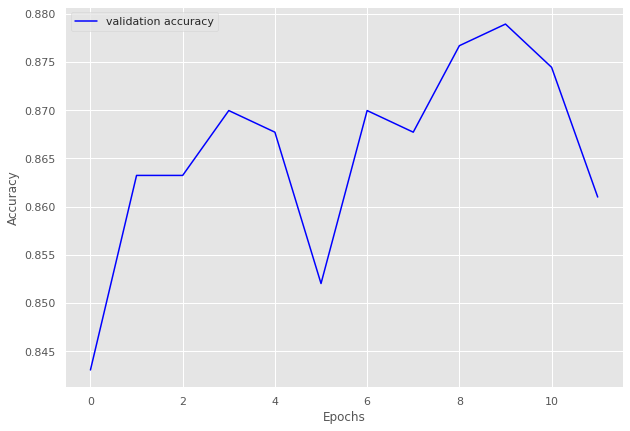

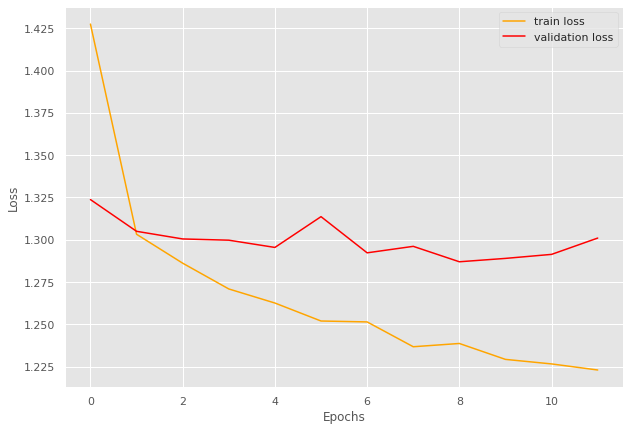

Done training of a fine model with test accuracy 0.9533888228299643
Coarse label 7 Epoch 1
-------------------------------


100%|██████████| 56/56 [00:19<00:00,  2.91batch/s, loss=0.904]


train loss 0.9043363056012562, validation loss 0.8335293630758921, validation accuracy 0.9150141643059491
Coarse label 7 Epoch 2
-------------------------------


100%|██████████| 56/56 [00:33<00:00,  1.66batch/s, loss=0.814]


train loss 0.8144502437540463, validation loss 0.8320158819357554, validation accuracy 0.9206798866855525
Coarse label 7 Epoch 3
-------------------------------


100%|██████████| 56/56 [00:39<00:00,  1.41batch/s, loss=0.8]  


INFO: Early stopping counter 1 of 5
train loss 0.8000642412475177, validation loss 0.8390679558118185, validation accuracy 0.9093484419263456
Coarse label 7 Epoch 4
-------------------------------


100%|██████████| 56/56 [00:48<00:00,  1.16batch/s, loss=0.793]


INFO: Early stopping counter 2 of 5
train loss 0.7930064329079219, validation loss 0.8343541224797567, validation accuracy 0.9178470254957507
Coarse label 7 Epoch 5
-------------------------------


100%|██████████| 56/56 [00:41<00:00,  1.36batch/s, loss=0.792]


train loss 0.7916285289185387, validation loss 0.8285441001256307, validation accuracy 0.9235127478753541
Coarse label 7 Epoch 6
-------------------------------


100%|██████████| 56/56 [00:38<00:00,  1.44batch/s, loss=0.785]


train loss 0.7854624507682664, validation loss 0.8264989058176676, validation accuracy 0.9235127478753541
Coarse label 7 Epoch 7
-------------------------------


100%|██████████| 56/56 [00:19<00:00,  2.82batch/s, loss=0.781]


INFO: Early stopping counter 3 of 5
train loss 0.7808364267860141, validation loss 0.8296645780404409, validation accuracy 0.9263456090651558
Coarse label 7 Epoch 8
-------------------------------


100%|██████████| 56/56 [00:19<00:00,  2.90batch/s, loss=0.78] 


INFO: Early stopping counter 4 of 5
train loss 0.7800909408501217, validation loss 0.8284156322479248, validation accuracy 0.9235127478753541
Coarse label 7 Epoch 9
-------------------------------


100%|██████████| 56/56 [00:19<00:00,  2.93batch/s, loss=0.779]


INFO: Early stopping counter 5 of 5
INFO: Early stopping
Done! Saved model with test accuracy 0.9708383961117861 and loss 0.7733812171679276


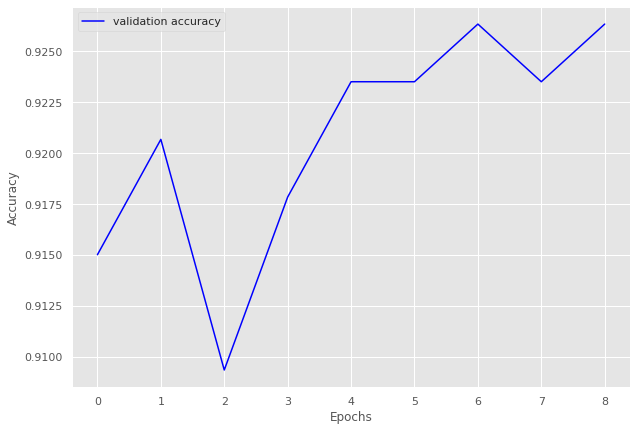

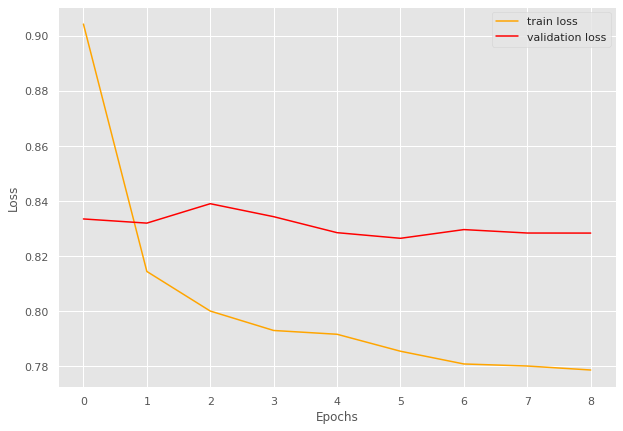

Done training of a fine model with test accuracy 0.9708383961117861
Coarse label 8 Epoch 1
-------------------------------


100%|██████████| 82/82 [00:28<00:00,  2.87batch/s, loss=1.44]


train loss 1.437502416168771, validation loss 1.3297581225633621, validation accuracy 0.8326530612244898
Coarse label 8 Epoch 2
-------------------------------


100%|██████████| 82/82 [00:28<00:00,  2.90batch/s, loss=1.31]


train loss 1.3100899835912192, validation loss 1.3042186200618744, validation accuracy 0.8530612244897959
Coarse label 8 Epoch 3
-------------------------------


100%|██████████| 82/82 [00:28<00:00,  2.88batch/s, loss=1.29]


INFO: Early stopping counter 1 of 5
train loss 1.2859564161882169, validation loss 1.3062007129192352, validation accuracy 0.8571428571428571
Coarse label 8 Epoch 4
-------------------------------


100%|██████████| 82/82 [00:28<00:00,  2.86batch/s, loss=1.28]


INFO: Early stopping counter 2 of 5
train loss 1.275248127739604, validation loss 1.3109716325998306, validation accuracy 0.8510204081632653
Coarse label 8 Epoch 5
-------------------------------


100%|██████████| 82/82 [00:28<00:00,  2.87batch/s, loss=1.27]


train loss 1.2663998502056772, validation loss 1.298134446144104, validation accuracy 0.8612244897959184
Coarse label 8 Epoch 6
-------------------------------


100%|██████████| 82/82 [00:28<00:00,  2.88batch/s, loss=1.27]


INFO: Early stopping counter 3 of 5
train loss 1.2663531303405762, validation loss 1.3048840463161469, validation accuracy 0.8591836734693877
Coarse label 8 Epoch 7
-------------------------------


100%|██████████| 82/82 [00:28<00:00,  2.90batch/s, loss=1.26]


train loss 1.2593329069091053, validation loss 1.2973695695400238, validation accuracy 0.8653061224489796
Coarse label 8 Epoch 8
-------------------------------


100%|██████████| 82/82 [00:28<00:00,  2.90batch/s, loss=1.25]


train loss 1.2517599100019874, validation loss 1.2904417514801025, validation accuracy 0.8755102040816326
Coarse label 8 Epoch 9
-------------------------------


100%|██████████| 82/82 [00:28<00:00,  2.90batch/s, loss=1.24]


INFO: Early stopping counter 4 of 5
train loss 1.2443882837528135, validation loss 1.2996788322925568, validation accuracy 0.8693877551020408
Coarse label 8 Epoch 10
-------------------------------


100%|██████████| 82/82 [00:28<00:00,  2.84batch/s, loss=1.24]


INFO: Early stopping counter 5 of 5
INFO: Early stopping
Done! Saved model with test accuracy 0.9435553633217993 and loss 1.2231189388118378


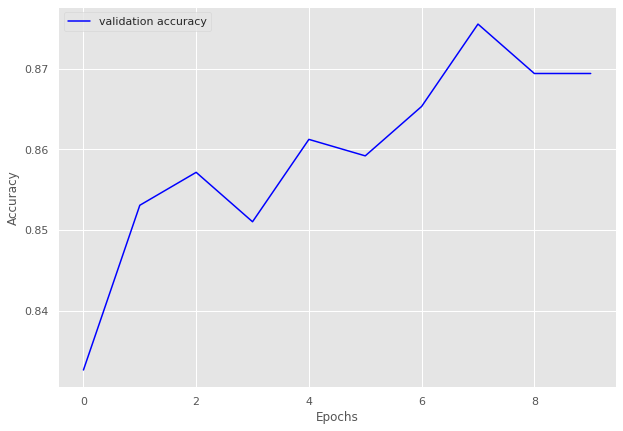

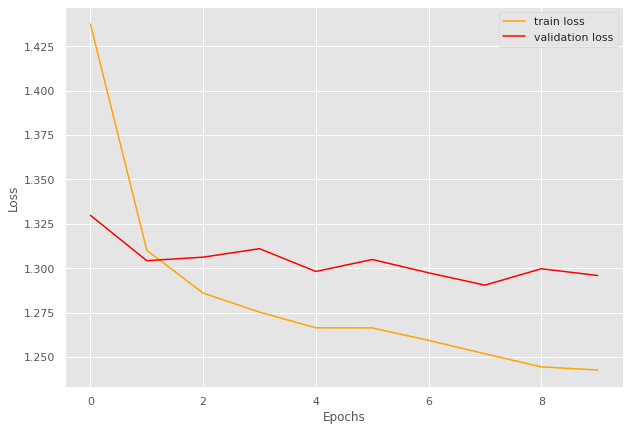

Done training of a fine model with test accuracy 0.9435553633217993
Coarse label 9 Epoch 1
-------------------------------


100%|██████████| 103/103 [00:35<00:00,  2.90batch/s, loss=1.74]


train loss 1.7357248901163491, validation loss 1.6438945856961338, validation accuracy 0.8259587020648967
Coarse label 9 Epoch 2
-------------------------------


100%|██████████| 103/103 [00:35<00:00,  2.88batch/s, loss=1.62]


train loss 1.6221248038764138, validation loss 1.6343676068566062, validation accuracy 0.831858407079646
Coarse label 9 Epoch 3
-------------------------------


100%|██████████| 103/103 [00:35<00:00,  2.91batch/s, loss=1.6] 


train loss 1.5996031263499584, validation loss 1.6114524494517932, validation accuracy 0.8495575221238938
Coarse label 9 Epoch 4
-------------------------------


100%|██████████| 103/103 [00:35<00:00,  2.92batch/s, loss=1.59]


INFO: Early stopping counter 1 of 5
train loss 1.5862782811655582, validation loss 1.6150093295357444, validation accuracy 0.8436578171091446
Coarse label 9 Epoch 5
-------------------------------


100%|██████████| 103/103 [00:35<00:00,  2.89batch/s, loss=1.58]


INFO: Early stopping counter 2 of 5
train loss 1.5797161801347455, validation loss 1.614637385715138, validation accuracy 0.8451327433628318
Coarse label 9 Epoch 6
-------------------------------


100%|██████████| 103/103 [00:35<00:00,  2.91batch/s, loss=1.57]


INFO: Early stopping counter 3 of 5
train loss 1.5656407840043596, validation loss 1.6281255158511074, validation accuracy 0.831858407079646
Coarse label 9 Epoch 7
-------------------------------


100%|██████████| 103/103 [00:35<00:00,  2.89batch/s, loss=1.56]


train loss 1.5636756894657913, validation loss 1.600726994601163, validation accuracy 0.8569321533923304
Coarse label 9 Epoch 8
-------------------------------


100%|██████████| 103/103 [00:36<00:00,  2.85batch/s, loss=1.55]


INFO: Early stopping counter 4 of 5
train loss 1.5541208507945237, validation loss 1.6119980595328591, validation accuracy 0.8480825958702065
Coarse label 9 Epoch 9
-------------------------------


100%|██████████| 103/103 [00:35<00:00,  2.92batch/s, loss=1.55]


INFO: Early stopping counter 5 of 5
INFO: Early stopping
Done! Saved model with test accuracy 0.9380122950819673 and loss 1.5248721980530282


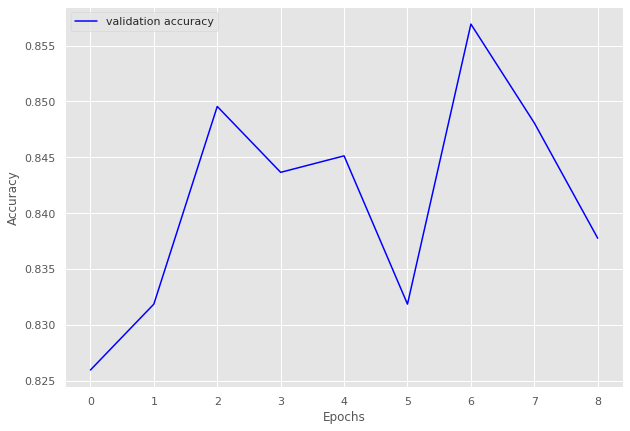

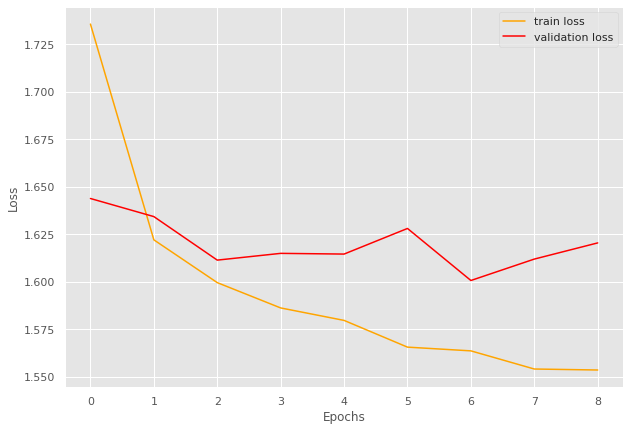

Done training of a fine model with test accuracy 0.9380122950819673
Coarse label 11 Epoch 1
-------------------------------


100%|██████████| 48/48 [00:16<00:00,  2.85batch/s, loss=0.927]


train loss 0.9269633367657661, validation loss 0.861155116558075, validation accuracy 0.8856209150326797
Coarse label 11 Epoch 2
-------------------------------


100%|██████████| 48/48 [00:16<00:00,  2.89batch/s, loss=0.831]


train loss 0.8308690972626209, validation loss 0.8560301542282105, validation accuracy 0.8856209150326797
Coarse label 11 Epoch 3
-------------------------------


100%|██████████| 48/48 [00:19<00:00,  2.53batch/s, loss=0.812]


train loss 0.8121995416780313, validation loss 0.8444320678710937, validation accuracy 0.8954248366013072
Coarse label 11 Epoch 4
-------------------------------


100%|██████████| 48/48 [00:16<00:00,  2.85batch/s, loss=0.798]


INFO: Early stopping counter 1 of 5
train loss 0.7976445158322653, validation loss 0.8534075856208801, validation accuracy 0.8856209150326797
Coarse label 11 Epoch 5
-------------------------------


100%|██████████| 48/48 [00:16<00:00,  2.93batch/s, loss=0.791]


INFO: Early stopping counter 2 of 5
train loss 0.790500375131766, validation loss 0.8499547362327575, validation accuracy 0.8954248366013072
Coarse label 11 Epoch 6
-------------------------------


100%|██████████| 48/48 [00:16<00:00,  2.92batch/s, loss=0.787]


train loss 0.7870328811307749, validation loss 0.8272066354751587, validation accuracy 0.9183006535947712
Coarse label 11 Epoch 7
-------------------------------


100%|██████████| 48/48 [00:16<00:00,  2.91batch/s, loss=0.785]


INFO: Early stopping counter 3 of 5
train loss 0.7848622314631939, validation loss 0.8526110053062439, validation accuracy 0.8954248366013072
Coarse label 11 Epoch 8
-------------------------------


100%|██████████| 48/48 [00:16<00:00,  2.92batch/s, loss=0.782]


INFO: Early stopping counter 4 of 5
train loss 0.7818614989519119, validation loss 0.8628188490867614, validation accuracy 0.8823529411764706
Coarse label 11 Epoch 9
-------------------------------


100%|██████████| 48/48 [00:16<00:00,  2.91batch/s, loss=0.781]


INFO: Early stopping counter 5 of 5
INFO: Early stopping
Done! Saved model with test accuracy 0.9731884057971014 and loss 0.7706457782875408


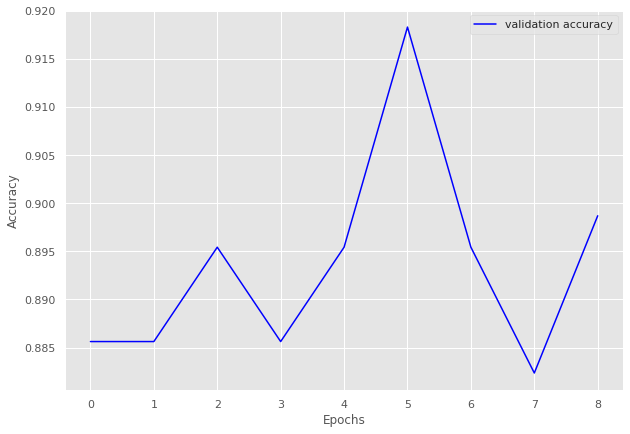

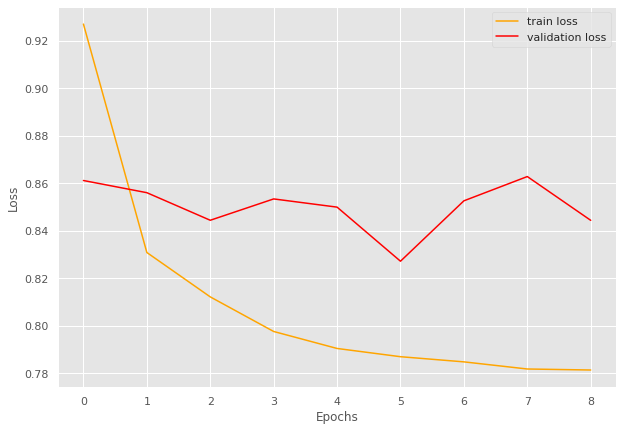

Done training of a fine model with test accuracy 0.9731884057971014
Coarse label 12 Epoch 1
-------------------------------


100%|██████████| 48/48 [00:16<00:00,  2.92batch/s, loss=1.39]


train loss 1.3861926545699437, validation loss 1.2378238916397095, validation accuracy 0.8032258064516129
Coarse label 12 Epoch 2
-------------------------------


100%|██████████| 48/48 [00:16<00:00,  2.93batch/s, loss=1.22]


INFO: Early stopping counter 1 of 5
train loss 1.2178663983941078, validation loss 1.2407759189605714, validation accuracy 0.8096774193548387
Coarse label 12 Epoch 3
-------------------------------


100%|██████████| 48/48 [00:16<00:00,  2.90batch/s, loss=1.19]


train loss 1.1851329108079274, validation loss 1.2354315757751464, validation accuracy 0.8032258064516129
Coarse label 12 Epoch 4
-------------------------------


100%|██████████| 48/48 [00:16<00:00,  2.90batch/s, loss=1.16]


train loss 1.164734813074271, validation loss 1.2336034297943115, validation accuracy 0.8032258064516129
Coarse label 12 Epoch 5
-------------------------------


100%|██████████| 48/48 [00:16<00:00,  2.93batch/s, loss=1.15]


INFO: Early stopping counter 2 of 5
train loss 1.150077981253465, validation loss 1.2399109840393066, validation accuracy 0.8064516129032258
Coarse label 12 Epoch 6
-------------------------------


100%|██████████| 48/48 [00:16<00:00,  2.91batch/s, loss=1.14]


train loss 1.141549011071523, validation loss 1.224479579925537, validation accuracy 0.8129032258064516
Coarse label 12 Epoch 7
-------------------------------


100%|██████████| 48/48 [00:16<00:00,  2.89batch/s, loss=1.13]


train loss 1.1274355898300807, validation loss 1.2234572649002076, validation accuracy 0.8225806451612904
Coarse label 12 Epoch 8
-------------------------------


100%|██████████| 48/48 [00:16<00:00,  2.94batch/s, loss=1.12]


train loss 1.1155931080381076, validation loss 1.2225352287292481, validation accuracy 0.8225806451612904
Coarse label 12 Epoch 9
-------------------------------


100%|██████████| 48/48 [00:16<00:00,  2.90batch/s, loss=1.12]


train loss 1.120221885542075, validation loss 1.2007892847061157, validation accuracy 0.8548387096774194
Coarse label 12 Epoch 10
-------------------------------


100%|██████████| 48/48 [00:16<00:00,  2.89batch/s, loss=1.11]


INFO: Early stopping counter 3 of 5
train loss 1.1131235112746556, validation loss 1.2199952125549316, validation accuracy 0.8258064516129032
Coarse label 12 Epoch 11
-------------------------------


100%|██████████| 48/48 [00:16<00:00,  2.87batch/s, loss=1.11]


INFO: Early stopping counter 4 of 5
train loss 1.1066783890128136, validation loss 1.211773657798767, validation accuracy 0.8290322580645161
Coarse label 12 Epoch 12
-------------------------------


100%|██████████| 48/48 [00:16<00:00,  2.92batch/s, loss=1.11]


INFO: Early stopping counter 5 of 5
INFO: Early stopping
Done! Saved model with test accuracy 0.9215909090909091 and loss 1.1224437810125805


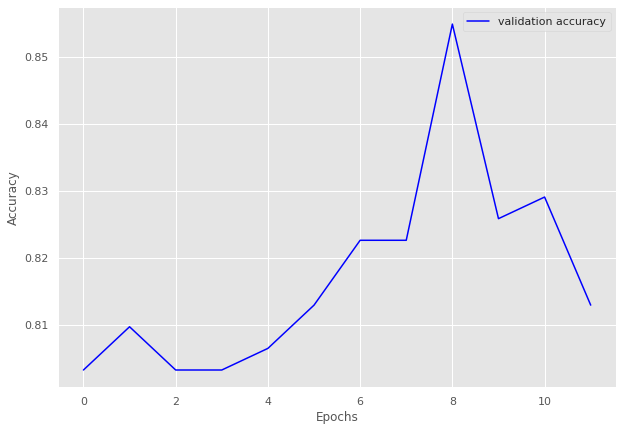

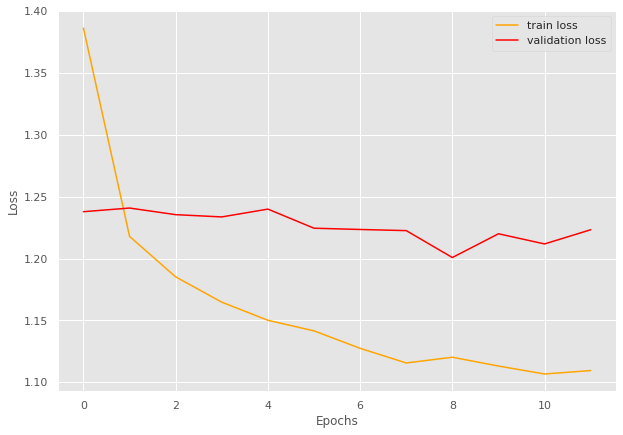

Done training of a fine model with test accuracy 0.9215909090909091
Coarse label 13 Epoch 1
-------------------------------


100%|██████████| 40/40 [00:13<00:00,  2.92batch/s, loss=0.725]


train loss 0.7250970721244812, validation loss 0.6284298896789551, validation accuracy 0.9262295081967213
Coarse label 13 Epoch 2
-------------------------------


100%|██████████| 40/40 [00:13<00:00,  2.86batch/s, loss=0.637]


INFO: Early stopping counter 1 of 5
train loss 0.6374925553798676, validation loss 0.628590002655983, validation accuracy 0.9221311475409836
Coarse label 13 Epoch 3
-------------------------------


100%|██████████| 40/40 [00:13<00:00,  2.92batch/s, loss=0.61] 


train loss 0.6097452059388161, validation loss 0.6179708689451218, validation accuracy 0.9344262295081968
Coarse label 13 Epoch 4
-------------------------------


100%|██████████| 40/40 [00:13<00:00,  2.90batch/s, loss=0.593]


INFO: Early stopping counter 2 of 5
train loss 0.5927492886781692, validation loss 0.6272891461849213, validation accuracy 0.9262295081967213
Coarse label 13 Epoch 5
-------------------------------


100%|██████████| 40/40 [00:13<00:00,  2.95batch/s, loss=0.59] 


INFO: Early stopping counter 3 of 5
train loss 0.5901717603206634, validation loss 0.6241964101791382, validation accuracy 0.9180327868852459
Coarse label 13 Epoch 6
-------------------------------


100%|██████████| 40/40 [00:13<00:00,  2.95batch/s, loss=0.586]


INFO: Early stopping counter 4 of 5
train loss 0.5858561366796493, validation loss 0.6418227404356003, validation accuracy 0.9057377049180327
Coarse label 13 Epoch 7
-------------------------------


100%|██████████| 40/40 [00:13<00:00,  2.95batch/s, loss=0.589]


INFO: Early stopping counter 5 of 5
INFO: Early stopping
Done! Saved model with test accuracy 0.9427595044852627 and loss 0.6085832215644218


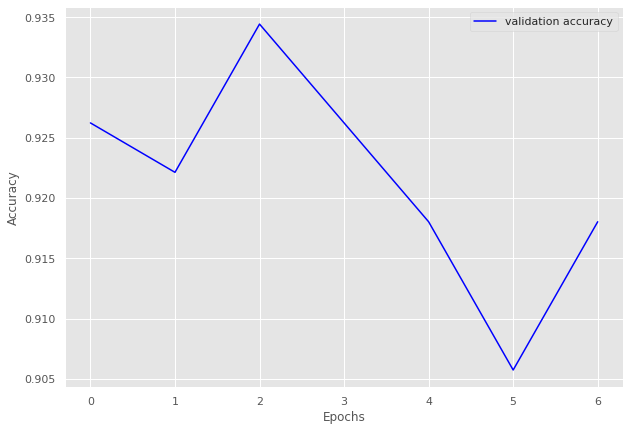

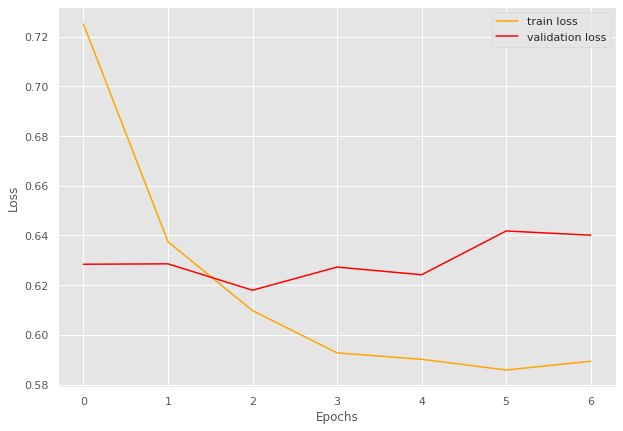

Done training of a fine model with test accuracy 0.9427595044852627
Coarse label 14 Epoch 1
-------------------------------


100%|██████████| 91/91 [00:32<00:00,  2.83batch/s, loss=1.23]


train loss 1.2263470534439926, validation loss 1.1467305024464924, validation accuracy 0.8977072310405644
Coarse label 14 Epoch 2
-------------------------------


100%|██████████| 91/91 [00:31<00:00,  2.92batch/s, loss=1.13]


train loss 1.1328820566554645, validation loss 1.1238359212875366, validation accuracy 0.9171075837742504
Coarse label 14 Epoch 3
-------------------------------


100%|██████████| 91/91 [00:31<00:00,  2.87batch/s, loss=1.12]


INFO: Early stopping counter 1 of 5
train loss 1.1231361771677877, validation loss 1.1290591955184937, validation accuracy 0.9153439153439153
Coarse label 14 Epoch 4
-------------------------------


100%|██████████| 91/91 [00:31<00:00,  2.89batch/s, loss=1.11]


train loss 1.1118837477086665, validation loss 1.1173692676756117, validation accuracy 0.9259259259259259
Coarse label 14 Epoch 5
-------------------------------


100%|██████████| 91/91 [00:31<00:00,  2.92batch/s, loss=1.11]


INFO: Early stopping counter 2 of 5
train loss 1.1093244801510822, validation loss 1.1190584633085463, validation accuracy 0.927689594356261
Coarse label 14 Epoch 6
-------------------------------


100%|██████████| 91/91 [00:31<00:00,  2.89batch/s, loss=1.1] 


INFO: Early stopping counter 3 of 5
train loss 1.104099316911383, validation loss 1.122113002671136, validation accuracy 0.9206349206349206
Coarse label 14 Epoch 7
-------------------------------


100%|██████████| 91/91 [00:31<00:00,  2.93batch/s, loss=1.1] 


INFO: Early stopping counter 4 of 5
train loss 1.100033319913424, validation loss 1.1322463750839233, validation accuracy 0.9065255731922398
Coarse label 14 Epoch 8
-------------------------------


100%|██████████| 91/91 [00:31<00:00,  2.85batch/s, loss=1.1] 


INFO: Early stopping counter 5 of 5
INFO: Early stopping
Done! Saved model with test accuracy 0.9640930232558139 and loss 1.0801626018115453


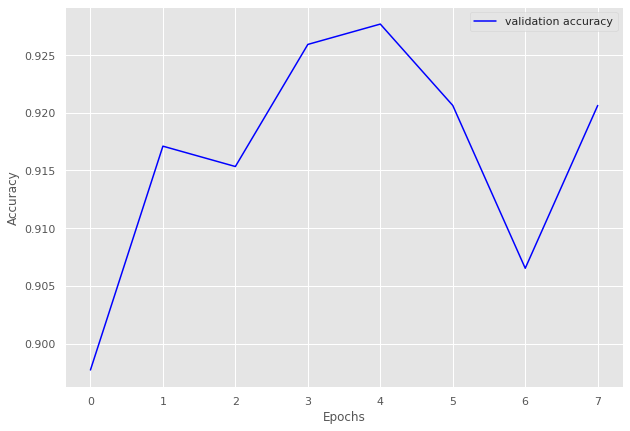

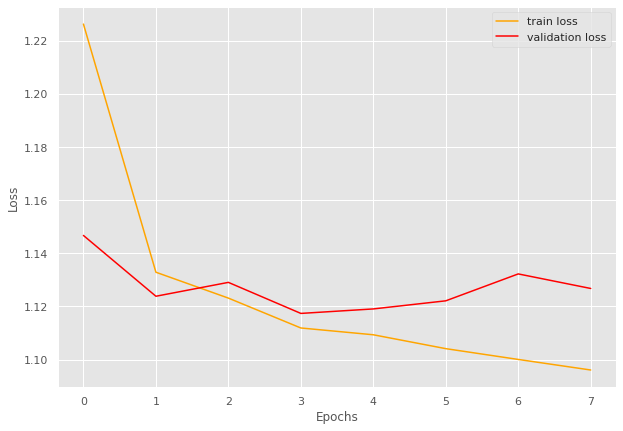

Done training of a fine model with test accuracy 0.9640930232558139
Coarse label 15 Epoch 1
-------------------------------


100%|██████████| 47/47 [00:16<00:00,  2.90batch/s, loss=0.948]


train loss 0.9482120414997669, validation loss 0.8655690908432007, validation accuracy 0.886986301369863
Coarse label 15 Epoch 2
-------------------------------


100%|██████████| 47/47 [00:16<00:00,  2.91batch/s, loss=0.828]


INFO: Early stopping counter 1 of 5
train loss 0.8284956254857652, validation loss 0.8728037238121032, validation accuracy 0.8801369863013698
Coarse label 15 Epoch 3
-------------------------------


100%|██████████| 47/47 [00:15<00:00,  2.97batch/s, loss=0.804]


INFO: Early stopping counter 2 of 5
train loss 0.8039410520107189, validation loss 0.8660878539085388, validation accuracy 0.8835616438356164
Coarse label 15 Epoch 4
-------------------------------


100%|██████████| 47/47 [00:15<00:00,  2.95batch/s, loss=0.801]


train loss 0.8005083951544254, validation loss 0.8634753346443176, validation accuracy 0.8904109589041096
Coarse label 15 Epoch 5
-------------------------------


100%|██████████| 47/47 [00:16<00:00,  2.89batch/s, loss=0.789]


INFO: Early stopping counter 3 of 5
train loss 0.7890690729973164, validation loss 0.8736398577690124, validation accuracy 0.8801369863013698
Coarse label 15 Epoch 6
-------------------------------


100%|██████████| 47/47 [00:16<00:00,  2.89batch/s, loss=0.786]


train loss 0.7860717380300482, validation loss 0.850822103023529, validation accuracy 0.9075342465753424
Coarse label 15 Epoch 7
-------------------------------


100%|██████████| 47/47 [00:15<00:00,  2.94batch/s, loss=0.778]


INFO: Early stopping counter 4 of 5
train loss 0.7776620768486185, validation loss 0.8579588413238526, validation accuracy 0.9006849315068494
Coarse label 15 Epoch 8
-------------------------------


100%|██████████| 47/47 [00:16<00:00,  2.90batch/s, loss=0.777]


train loss 0.7772713633293801, validation loss 0.8496157050132751, validation accuracy 0.8972602739726028
Coarse label 15 Epoch 9
-------------------------------


100%|██████████| 47/47 [00:16<00:00,  2.92batch/s, loss=0.781]


INFO: Early stopping counter 5 of 5
INFO: Early stopping
Done! Saved model with test accuracy 0.9642049736247174 and loss 0.7779737114906311


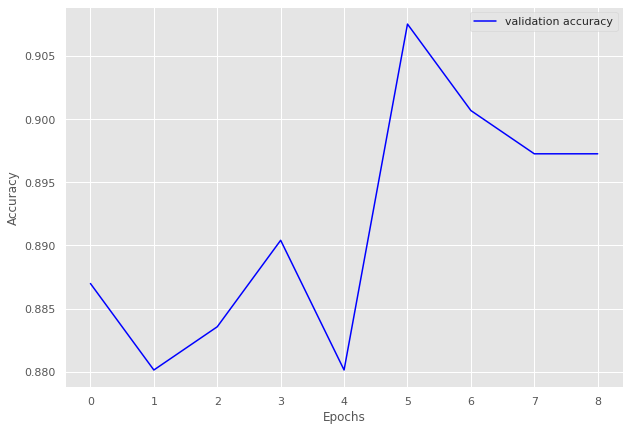

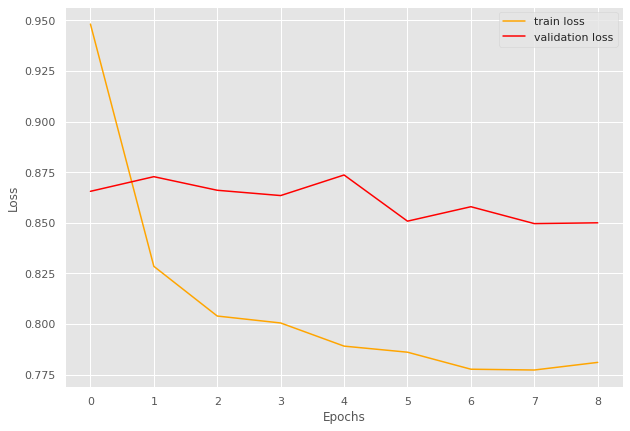

Done training of a fine model with test accuracy 0.9642049736247174
Coarse label 16 Epoch 1
-------------------------------


100%|██████████| 44/44 [00:15<00:00,  2.89batch/s, loss=0.719]


train loss 0.7185403636910699, validation loss 0.6517611980438233, validation accuracy 0.9021739130434783
Coarse label 16 Epoch 2
-------------------------------


100%|██████████| 44/44 [00:15<00:00,  2.89batch/s, loss=0.62] 


train loss 0.6203599355437539, validation loss 0.64910728931427, validation accuracy 0.8913043478260869
Coarse label 16 Epoch 3
-------------------------------


100%|██████████| 44/44 [00:15<00:00,  2.92batch/s, loss=0.599]


INFO: Early stopping counter 1 of 5
train loss 0.5987124375321649, validation loss 0.6510627031326294, validation accuracy 0.8985507246376812
Coarse label 16 Epoch 4
-------------------------------


100%|██████████| 44/44 [00:15<00:00,  2.90batch/s, loss=0.59] 


train loss 0.5901277593590997, validation loss 0.6322124600410461, validation accuracy 0.9239130434782609
Coarse label 16 Epoch 5
-------------------------------


100%|██████████| 44/44 [00:14<00:00,  2.94batch/s, loss=0.586]


INFO: Early stopping counter 2 of 5
train loss 0.5858244584365324, validation loss 0.6380793213844299, validation accuracy 0.9094202898550725
Coarse label 16 Epoch 6
-------------------------------


100%|██████████| 44/44 [00:14<00:00,  2.96batch/s, loss=0.584]


INFO: Early stopping counter 3 of 5
train loss 0.5840166265314276, validation loss 0.6362576723098755, validation accuracy 0.9094202898550725
Coarse label 16 Epoch 7
-------------------------------


100%|██████████| 44/44 [00:15<00:00,  2.89batch/s, loss=0.581]


train loss 0.5811027478088032, validation loss 0.6314459085464478, validation accuracy 0.9166666666666666
Coarse label 16 Epoch 8
-------------------------------


100%|██████████| 44/44 [00:15<00:00,  2.92batch/s, loss=0.577]


INFO: Early stopping counter 4 of 5
train loss 0.5773647373372858, validation loss 0.6516083598136901, validation accuracy 0.894927536231884
Coarse label 16 Epoch 9
-------------------------------


100%|██████████| 44/44 [00:14<00:00,  2.96batch/s, loss=0.574]


INFO: Early stopping counter 5 of 5
INFO: Early stopping
Done! Saved model with test accuracy 0.9733124018838305 and loss 0.578972402215004


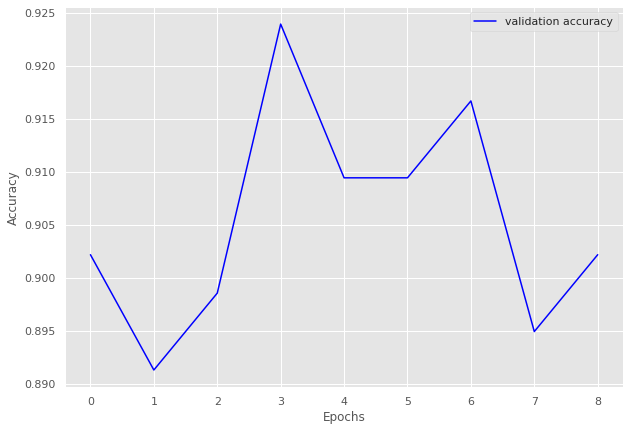

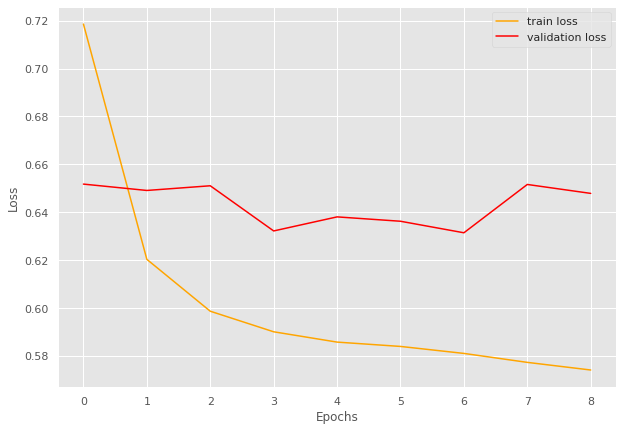

Done training of a fine model with test accuracy 0.9733124018838305
Coarse label 17 Epoch 1
-------------------------------


100%|██████████| 49/49 [00:17<00:00,  2.86batch/s, loss=0.992]


train loss 0.991918071192138, validation loss 0.8942402482032776, validation accuracy 0.8459016393442623
Coarse label 17 Epoch 2
-------------------------------


100%|██████████| 49/49 [00:16<00:00,  2.95batch/s, loss=0.855]


train loss 0.8554709249613236, validation loss 0.8917590022087097, validation accuracy 0.8426229508196721
Coarse label 17 Epoch 3
-------------------------------


100%|██████████| 49/49 [00:16<00:00,  2.90batch/s, loss=0.825]


train loss 0.8246135614356216, validation loss 0.8818650960922241, validation accuracy 0.8491803278688524
Coarse label 17 Epoch 4
-------------------------------


100%|██████████| 49/49 [00:16<00:00,  2.89batch/s, loss=0.805]


train loss 0.804657054190733, validation loss 0.8642876029014588, validation accuracy 0.8786885245901639
Coarse label 17 Epoch 5
-------------------------------


100%|██████████| 49/49 [00:16<00:00,  2.95batch/s, loss=0.801]


train loss 0.8007633114347652, validation loss 0.8629191398620606, validation accuracy 0.8852459016393442
Coarse label 17 Epoch 6
-------------------------------


100%|██████████| 49/49 [00:16<00:00,  2.95batch/s, loss=0.795]


INFO: Early stopping counter 1 of 5
train loss 0.7954966669179955, validation loss 0.8672390222549439, validation accuracy 0.8721311475409836
Coarse label 17 Epoch 7
-------------------------------


100%|██████████| 49/49 [00:17<00:00,  2.87batch/s, loss=0.787]


INFO: Early stopping counter 2 of 5
train loss 0.7874715522843965, validation loss 0.8677188873291015, validation accuracy 0.8754098360655738
Coarse label 17 Epoch 8
-------------------------------


100%|██████████| 49/49 [00:16<00:00,  2.90batch/s, loss=0.783]


INFO: Early stopping counter 3 of 5
train loss 0.7832436975167723, validation loss 0.8702149868011475, validation accuracy 0.8721311475409836
Coarse label 17 Epoch 9
-------------------------------


100%|██████████| 49/49 [00:16<00:00,  2.90batch/s, loss=0.794]


train loss 0.7943494915962219, validation loss 0.850405478477478, validation accuracy 0.8950819672131147
Coarse label 17 Epoch 10
-------------------------------


100%|██████████| 49/49 [00:16<00:00,  2.94batch/s, loss=0.807]


INFO: Early stopping counter 4 of 5
train loss 0.8067202774845824, validation loss 0.8765129804611206, validation accuracy 0.8622950819672132
Coarse label 17 Epoch 11
-------------------------------


100%|██████████| 49/49 [00:16<00:00,  2.94batch/s, loss=0.79] 


INFO: Early stopping counter 5 of 5
INFO: Early stopping
Done! Saved model with test accuracy 0.9469914040114613 and loss 0.7959086136384443


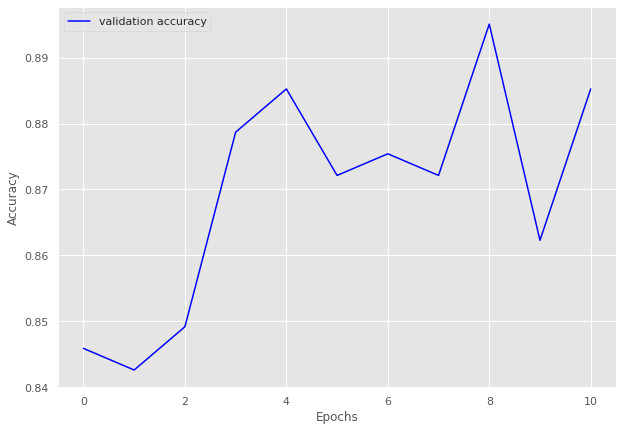

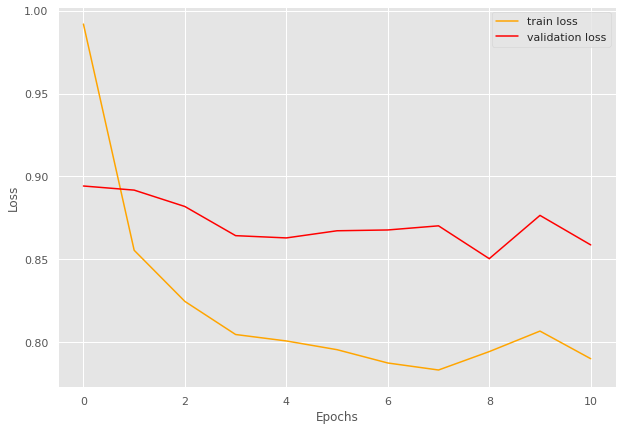

Done training of a fine model with test accuracy 0.9469914040114613
Coarse label 19 Epoch 1
-------------------------------


100%|██████████| 19/19 [00:06<00:00,  3.05batch/s, loss=1.14]


train loss 1.135501670209985, validation loss 1.0365142524242401, validation accuracy 0.671875
Coarse label 19 Epoch 2
-------------------------------


100%|██████████| 19/19 [00:06<00:00,  3.04batch/s, loss=0.932]


INFO: Early stopping counter 1 of 5
train loss 0.9315238877346641, validation loss 1.0367786288261414, validation accuracy 0.6953125
Coarse label 19 Epoch 3
-------------------------------


100%|██████████| 19/19 [00:06<00:00,  2.99batch/s, loss=0.85] 


train loss 0.8502010107040405, validation loss 1.0283679366111755, validation accuracy 0.703125
Coarse label 19 Epoch 4
-------------------------------


100%|██████████| 19/19 [00:06<00:00,  2.98batch/s, loss=0.829]


train loss 0.8285544765622992, validation loss 1.0077043175697327, validation accuracy 0.7421875
Coarse label 19 Epoch 5
-------------------------------


100%|██████████| 19/19 [00:06<00:00,  2.97batch/s, loss=0.806]


INFO: Early stopping counter 2 of 5
train loss 0.805624500701302, validation loss 1.0350810885429382, validation accuracy 0.703125
Coarse label 19 Epoch 6
-------------------------------


100%|██████████| 19/19 [00:06<00:00,  2.95batch/s, loss=0.791]


train loss 0.7907681088698538, validation loss 1.0047043859958649, validation accuracy 0.734375
Coarse label 19 Epoch 7
-------------------------------


100%|██████████| 19/19 [00:06<00:00,  2.97batch/s, loss=0.786]


train loss 0.7859635760909632, validation loss 0.998081624507904, validation accuracy 0.734375
Coarse label 19 Epoch 8
-------------------------------


100%|██████████| 19/19 [00:06<00:00,  3.00batch/s, loss=0.775]


INFO: Early stopping counter 3 of 5
train loss 0.7751579880714417, validation loss 1.0145723223686218, validation accuracy 0.71875
Coarse label 19 Epoch 9
-------------------------------


100%|██████████| 19/19 [00:06<00:00,  2.94batch/s, loss=0.768]


INFO: Early stopping counter 4 of 5
train loss 0.7683538449437994, validation loss 1.0352379381656647, validation accuracy 0.6875
Coarse label 19 Epoch 10
-------------------------------


100%|██████████| 19/19 [00:06<00:00,  3.00batch/s, loss=0.769]


INFO: Early stopping counter 5 of 5
INFO: Early stopping
Done! Saved model with test accuracy 0.9468325791855203 and loss 0.7963951826095581


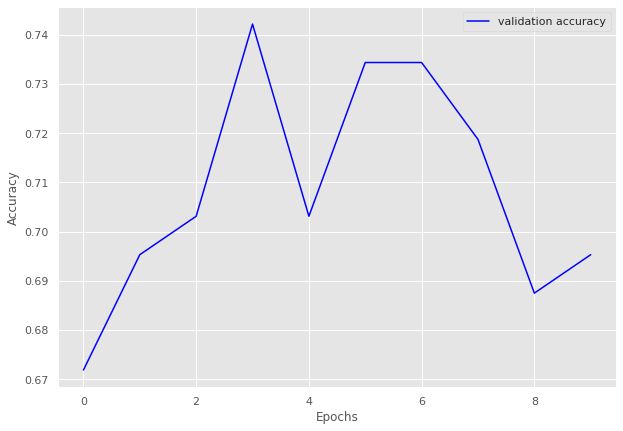

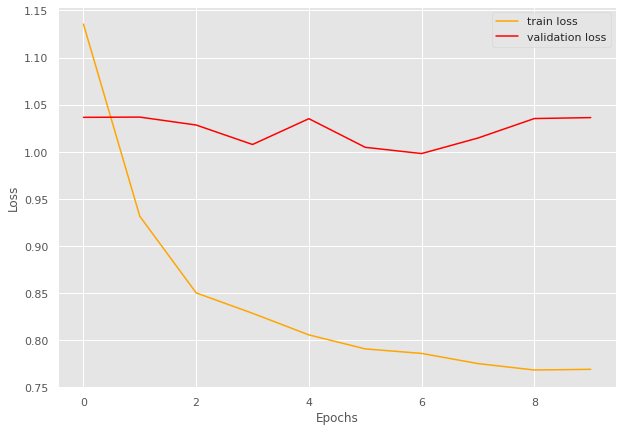

Done training of a fine model with test accuracy 0.9468325791855203
Starting model evaluation...
Evaluating fine model 0
Evaluating fine model 1
Evaluating fine model 2
Evaluating fine model 4
Evaluating fine model 5
Evaluating fine model 6
Evaluating fine model 7
Evaluating fine model 8
Evaluating fine model 9
Evaluating fine model 11
Evaluating fine model 12
Evaluating fine model 13
Evaluating fine model 14
Evaluating fine model 15
Evaluating fine model 16
Evaluating fine model 17
Evaluating fine model 19
overall accuracy  is 0.7990992625831037
Calculating for volume 20
Start training a coarse model
Epoch 1
-------------------------------


100%|██████████| 1052/1052 [06:13<00:00,  2.82batch/s, loss=2.61]


train loss 2.614604782922186, validation loss 2.542912953240531, validation accuracy 0.5360239162929746
Epoch 2
-------------------------------


100%|██████████| 1052/1052 [07:25<00:00,  2.36batch/s, loss=2.52]


train loss 2.520631340746644, validation loss 2.5077397528148833, validation accuracy 0.5704035874439461
Epoch 3
-------------------------------


100%|██████████| 1052/1052 [06:04<00:00,  2.89batch/s, loss=2.5]


INFO: Early stopping counter 1 of 5
train loss 2.4994871906454574, validation loss 2.514212878545125, validation accuracy 0.5651718983557549
Epoch 4
-------------------------------


100%|██████████| 1052/1052 [06:05<00:00,  2.88batch/s, loss=2.48]


train loss 2.477305172287466, validation loss 2.481853805269514, validation accuracy 0.5967115097159941
Epoch 5
-------------------------------


100%|██████████| 1052/1052 [07:59<00:00,  2.20batch/s, loss=2.46]


train loss 2.4577050109326612, validation loss 2.465481322152274, validation accuracy 0.6128550074738416
Epoch 6
-------------------------------


100%|██████████| 1052/1052 [06:05<00:00,  2.88batch/s, loss=2.45]


train loss 2.449557775780275, validation loss 2.464435995192755, validation accuracy 0.615695067264574
Epoch 7
-------------------------------


100%|██████████| 1052/1052 [06:08<00:00,  2.86batch/s, loss=2.44]


train loss 2.441497322044445, validation loss 2.460290275301252, validation accuracy 0.617339312406577
Epoch 8
-------------------------------


100%|██████████| 1052/1052 [06:06<00:00,  2.87batch/s, loss=2.43]


train loss 2.4327178302826535, validation loss 2.45539041473752, validation accuracy 0.623916292974589
Epoch 9
-------------------------------


100%|██████████| 1052/1052 [06:05<00:00,  2.88batch/s, loss=2.43]


train loss 2.425011020649522, validation loss 2.445464799517677, validation accuracy 0.634678624813154
Epoch 10
-------------------------------


100%|██████████| 1052/1052 [07:54<00:00,  2.22batch/s, loss=2.42]


train loss 2.421053299885739, validation loss 2.4454436461130777, validation accuracy 0.6342301943198804
Epoch 11
-------------------------------


100%|██████████| 1052/1052 [06:05<00:00,  2.87batch/s, loss=2.41]


INFO: Early stopping counter 2 of 5
train loss 2.4147172379856325, validation loss 2.448938746679397, validation accuracy 0.6300448430493274
Epoch 12
-------------------------------


100%|██████████| 1052/1052 [06:05<00:00,  2.88batch/s, loss=2.41]


train loss 2.4089991926240377, validation loss 2.437274458294823, validation accuracy 0.6414050822122571
Epoch 13
-------------------------------


100%|██████████| 1052/1052 [07:55<00:00,  2.21batch/s, loss=2.4]


train loss 2.402969732030716, validation loss 2.4298267409915018, validation accuracy 0.650373692077728
Epoch 14
-------------------------------


100%|██████████| 1052/1052 [06:06<00:00,  2.87batch/s, loss=2.4]


INFO: Early stopping counter 3 of 5
train loss 2.3964724701620326, validation loss 2.43262916292463, validation accuracy 0.6458893871449926
Epoch 15
-------------------------------


100%|██████████| 1052/1052 [06:08<00:00,  2.86batch/s, loss=2.4]


INFO: Early stopping counter 4 of 5
train loss 2.3981756839915374, validation loss 2.4321508248647055, validation accuracy 0.6469357249626307
Epoch 16
-------------------------------


100%|██████████| 1052/1052 [06:04<00:00,  2.88batch/s, loss=2.39]


INFO: Early stopping counter 5 of 5
INFO: Early stopping
Done! Saved model with test accuracy 0.8003035452100896 and loss 2.2783621280505186


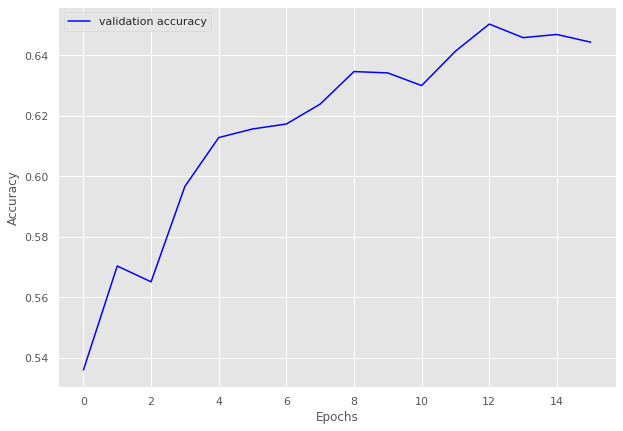

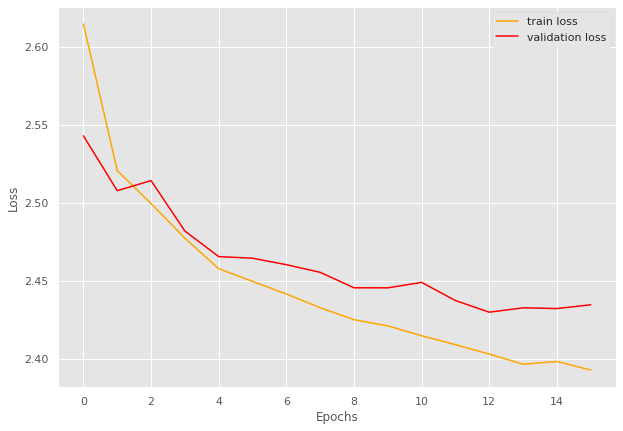

Done training of a coarse model with test accuracy 0.8003035452100896
Coarse label 0 Epoch 1
-------------------------------


100%|██████████| 65/65 [00:22<00:00,  2.90batch/s, loss=1.19]


train loss 1.1941687657282902, validation loss 1.120994942528861, validation accuracy 0.7957244655581948
Coarse label 0 Epoch 2
-------------------------------


100%|██████████| 65/65 [00:22<00:00,  2.92batch/s, loss=1.07]


INFO: Early stopping counter 1 of 5
train loss 1.0687760298068707, validation loss 1.122489401272365, validation accuracy 0.7909738717339667
Coarse label 0 Epoch 3
-------------------------------


100%|██████████| 65/65 [00:22<00:00,  2.89batch/s, loss=1.05]


INFO: Early stopping counter 2 of 5
train loss 1.0522706196858334, validation loss 1.122049161366054, validation accuracy 0.7814726840855107
Coarse label 0 Epoch 4
-------------------------------


100%|██████████| 65/65 [00:22<00:00,  2.88batch/s, loss=1.03]


train loss 1.0314259740022513, validation loss 1.113674862044198, validation accuracy 0.7957244655581948
Coarse label 0 Epoch 5
-------------------------------


100%|██████████| 65/65 [00:22<00:00,  2.87batch/s, loss=1.02] 


INFO: Early stopping counter 3 of 5
train loss 1.0194117839519794, validation loss 1.1175861528941564, validation accuracy 0.7885985748218527
Coarse label 0 Epoch 6
-------------------------------


100%|██████████| 65/65 [00:22<00:00,  2.84batch/s, loss=1.01] 


INFO: Early stopping counter 4 of 5
train loss 1.0117372824595525, validation loss 1.1164155006408691, validation accuracy 0.8004750593824228
Coarse label 0 Epoch 7
-------------------------------


100%|██████████| 65/65 [00:22<00:00,  2.91batch/s, loss=1.01]


INFO: Early stopping counter 5 of 5
INFO: Early stopping
Done! Saved model with test accuracy 0.9401489853583355 and loss 0.9649097772895313


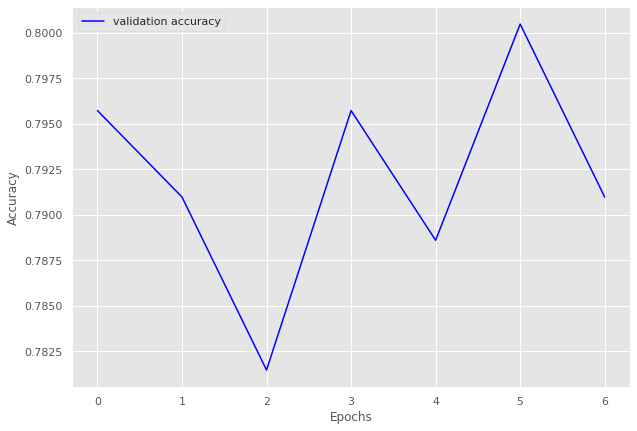

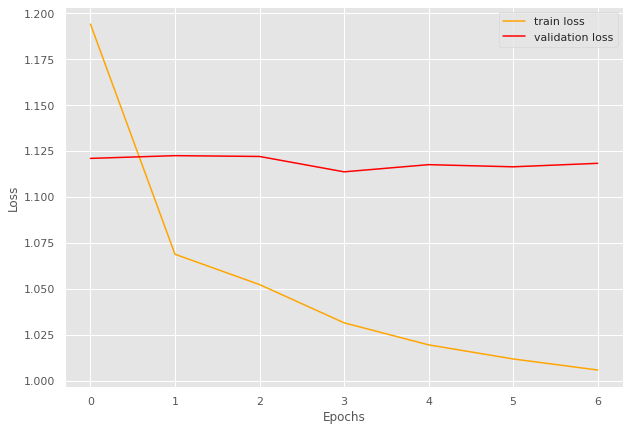

Done training of a fine model with test accuracy 0.9401489853583355
Coarse label 1 Epoch 1
-------------------------------


100%|██████████| 36/36 [00:12<00:00,  2.90batch/s, loss=1.47]


train loss 1.4729056623246934, validation loss 1.4016648530960083, validation accuracy 0.6333333333333333
Coarse label 1 Epoch 2
-------------------------------


100%|██████████| 36/36 [00:12<00:00,  2.90batch/s, loss=1.32]


train loss 1.324235972430971, validation loss 1.3907920122146606, validation accuracy 0.6416666666666667
Coarse label 1 Epoch 3
-------------------------------


100%|██████████| 36/36 [00:12<00:00,  2.89batch/s, loss=1.26]


train loss 1.2629268798563216, validation loss 1.369933933019638, validation accuracy 0.6583333333333333
Coarse label 1 Epoch 4
-------------------------------


100%|██████████| 36/36 [00:12<00:00,  2.85batch/s, loss=1.22]


INFO: Early stopping counter 1 of 5
train loss 1.2202382187048595, validation loss 1.3790936470031738, validation accuracy 0.6583333333333333
Coarse label 1 Epoch 5
-------------------------------


100%|██████████| 36/36 [00:12<00:00,  2.85batch/s, loss=1.2] 


INFO: Early stopping counter 2 of 5
train loss 1.1958115299542744, validation loss 1.3999066352844238, validation accuracy 0.6291666666666667
Coarse label 1 Epoch 6
-------------------------------


100%|██████████| 36/36 [00:12<00:00,  2.87batch/s, loss=1.18]


INFO: Early stopping counter 3 of 5
train loss 1.175102839867274, validation loss 1.3848052620887756, validation accuracy 0.65
Coarse label 1 Epoch 7
-------------------------------


100%|██████████| 36/36 [00:12<00:00,  2.86batch/s, loss=1.16]


INFO: Early stopping counter 4 of 5
train loss 1.1591436763604481, validation loss 1.395010620355606, validation accuracy 0.6333333333333333
Coarse label 1 Epoch 8
-------------------------------


100%|██████████| 36/36 [00:14<00:00,  2.45batch/s, loss=1.14]


INFO: Early stopping counter 5 of 5
INFO: Early stopping
Done! Saved model with test accuracy 0.9357311320754716 and loss 1.1106131959844519


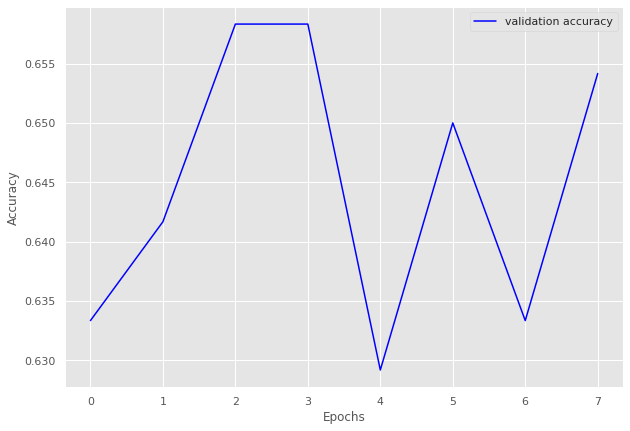

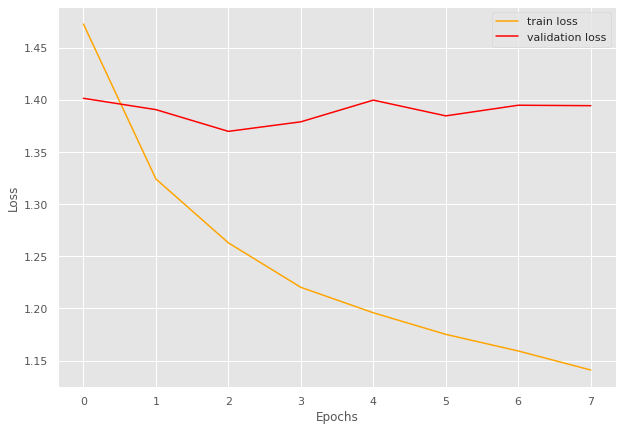

Done training of a fine model with test accuracy 0.9357311320754716
Coarse label 2 Epoch 1
-------------------------------


100%|██████████| 133/133 [01:26<00:00,  1.54batch/s, loss=1.81]


train loss 1.8139198543433857, validation loss 1.739645711013249, validation accuracy 0.7739234449760766
Coarse label 2 Epoch 2
-------------------------------


100%|██████████| 133/133 [01:38<00:00,  1.36batch/s, loss=1.67]


train loss 1.665611724208172, validation loss 1.7316410626683916, validation accuracy 0.777511961722488
Coarse label 2 Epoch 3
-------------------------------


100%|██████████| 133/133 [00:46<00:00,  2.86batch/s, loss=1.65]


train loss 1.6492038517069996, validation loss 1.7088939036641801, validation accuracy 0.80622009569378
Coarse label 2 Epoch 4
-------------------------------


100%|██████████| 133/133 [00:45<00:00,  2.89batch/s, loss=1.63]


INFO: Early stopping counter 1 of 5
train loss 1.629592242097496, validation loss 1.7108853629657201, validation accuracy 0.8026315789473685
Coarse label 2 Epoch 5
-------------------------------


100%|██████████| 133/133 [00:45<00:00,  2.89batch/s, loss=1.63]


INFO: Early stopping counter 2 of 5
train loss 1.6287933328097923, validation loss 1.7166099292891366, validation accuracy 0.7942583732057417
Coarse label 2 Epoch 6
-------------------------------


100%|██████████| 133/133 [00:46<00:00,  2.87batch/s, loss=1.62]


INFO: Early stopping counter 3 of 5
train loss 1.6180897135483592, validation loss 1.7180249861308508, validation accuracy 0.7918660287081339
Coarse label 2 Epoch 7
-------------------------------


100%|██████████| 133/133 [00:46<00:00,  2.87batch/s, loss=1.61]


INFO: Early stopping counter 4 of 5
train loss 1.6130106269865108, validation loss 1.7171580621174403, validation accuracy 0.7930622009569378
Coarse label 2 Epoch 8
-------------------------------


100%|██████████| 133/133 [00:46<00:00,  2.87batch/s, loss=1.61]


train loss 1.605187828379466, validation loss 1.707800737449101, validation accuracy 0.8074162679425837
Coarse label 2 Epoch 9
-------------------------------


100%|██████████| 133/133 [00:46<00:00,  2.83batch/s, loss=1.6]


INFO: Early stopping counter 5 of 5
INFO: Early stopping
Done! Saved model with test accuracy 0.9287976688204739 and loss 1.534486638922845


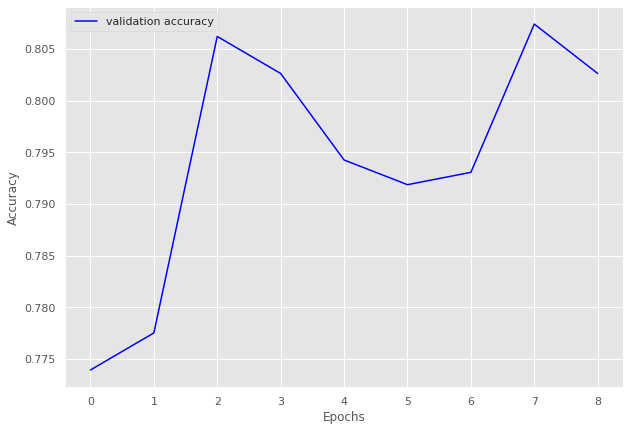

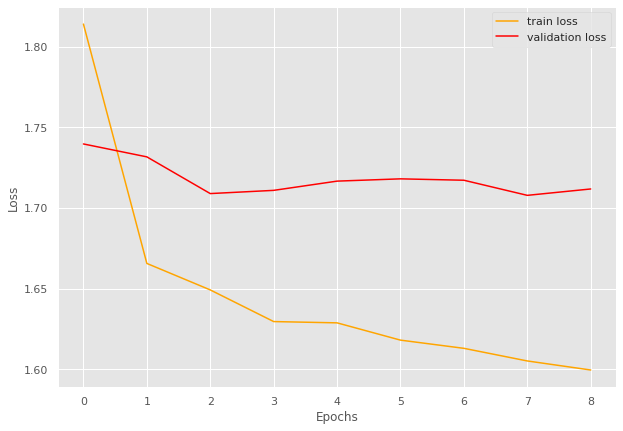

Done training of a fine model with test accuracy 0.9287976688204739
Coarse label 4 Epoch 1
-------------------------------


100%|██████████| 66/66 [00:22<00:00,  2.90batch/s, loss=1.4] 


train loss 1.3955440882480505, validation loss 1.3054568426949638, validation accuracy 0.7482352941176471
Coarse label 4 Epoch 2
-------------------------------


100%|██████████| 66/66 [00:22<00:00,  2.90batch/s, loss=1.26]


train loss 1.2556447946664058, validation loss 1.2895534038543701, validation accuracy 0.7552941176470588
Coarse label 4 Epoch 3
-------------------------------


100%|██████████| 66/66 [00:23<00:00,  2.86batch/s, loss=1.22]


train loss 1.219814414327795, validation loss 1.278998783656529, validation accuracy 0.7764705882352941
Coarse label 4 Epoch 4
-------------------------------


100%|██████████| 66/66 [00:22<00:00,  2.94batch/s, loss=1.19]


train loss 1.187877149292917, validation loss 1.2690703528267997, validation accuracy 0.788235294117647
Coarse label 4 Epoch 5
-------------------------------


100%|██████████| 66/66 [00:22<00:00,  2.94batch/s, loss=1.17]


INFO: Early stopping counter 1 of 5
train loss 1.1734356049335364, validation loss 1.283650176865714, validation accuracy 0.7647058823529411
Coarse label 4 Epoch 6
-------------------------------


100%|██████████| 66/66 [00:22<00:00,  2.88batch/s, loss=1.16]


train loss 1.162429448330041, validation loss 1.2676598685128349, validation accuracy 0.7835294117647059
Coarse label 4 Epoch 7
-------------------------------


100%|██████████| 66/66 [00:22<00:00,  2.93batch/s, loss=1.15]


INFO: Early stopping counter 2 of 5
train loss 1.1476068677324238, validation loss 1.2789626973015922, validation accuracy 0.7717647058823529
Coarse label 4 Epoch 8
-------------------------------


100%|██████████| 66/66 [00:22<00:00,  2.95batch/s, loss=1.14]


train loss 1.1424566489277463, validation loss 1.2671316521508353, validation accuracy 0.7788235294117647
Coarse label 4 Epoch 9
-------------------------------


100%|██████████| 66/66 [00:22<00:00,  2.92batch/s, loss=1.14]


INFO: Early stopping counter 3 of 5
train loss 1.140138105912642, validation loss 1.2751240730285645, validation accuracy 0.7764705882352941
Coarse label 4 Epoch 10
-------------------------------


100%|██████████| 66/66 [00:22<00:00,  2.93batch/s, loss=1.13]


INFO: Early stopping counter 4 of 5
train loss 1.1313851818893894, validation loss 1.2695425237928117, validation accuracy 0.7788235294117647
Coarse label 4 Epoch 11
-------------------------------


100%|██████████| 66/66 [00:22<00:00,  2.93batch/s, loss=1.13]


INFO: Early stopping counter 5 of 5
INFO: Early stopping
Done! Saved model with test accuracy 0.9329219211161792 and loss 1.1125317306841833


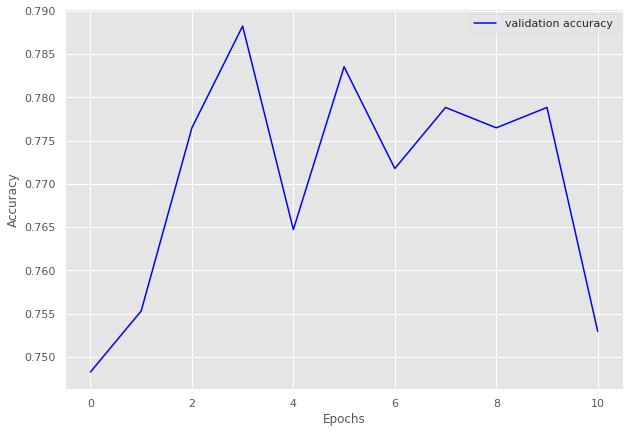

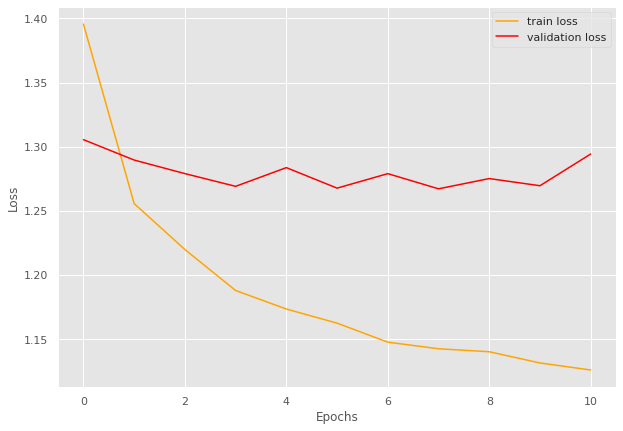

Done training of a fine model with test accuracy 0.9329219211161792
Coarse label 5 Epoch 1
-------------------------------


100%|██████████| 25/25 [00:08<00:00,  2.96batch/s, loss=0.47] 


train loss 0.46961182594299317, validation loss 0.43370184302330017, validation accuracy 0.896551724137931
Coarse label 5 Epoch 2
-------------------------------


100%|██████████| 25/25 [00:08<00:00,  2.86batch/s, loss=0.383]


INFO: Early stopping counter 1 of 5
train loss 0.38324217915534975, validation loss 0.4603147010008494, validation accuracy 0.8827586206896552
Coarse label 5 Epoch 3
-------------------------------


100%|██████████| 25/25 [00:08<00:00,  2.92batch/s, loss=0.363]


INFO: Early stopping counter 2 of 5
train loss 0.3633550703525543, validation loss 0.43992305795351666, validation accuracy 0.896551724137931
Coarse label 5 Epoch 4
-------------------------------


100%|██████████| 25/25 [00:08<00:00,  2.88batch/s, loss=0.347]


INFO: Early stopping counter 3 of 5
train loss 0.3468480134010315, validation loss 0.46176297465960187, validation accuracy 0.903448275862069
Coarse label 5 Epoch 5
-------------------------------


100%|██████████| 25/25 [00:08<00:00,  2.89batch/s, loss=0.34] 


INFO: Early stopping counter 4 of 5
train loss 0.34014594554901123, validation loss 0.49645040432612103, validation accuracy 0.8896551724137931
Coarse label 5 Epoch 6
-------------------------------


100%|██████████| 25/25 [00:08<00:00,  2.93batch/s, loss=0.333]


INFO: Early stopping counter 5 of 5
INFO: Early stopping
Done! Saved model with test accuracy 0.9687282835302293 and loss 0.3409888226052989


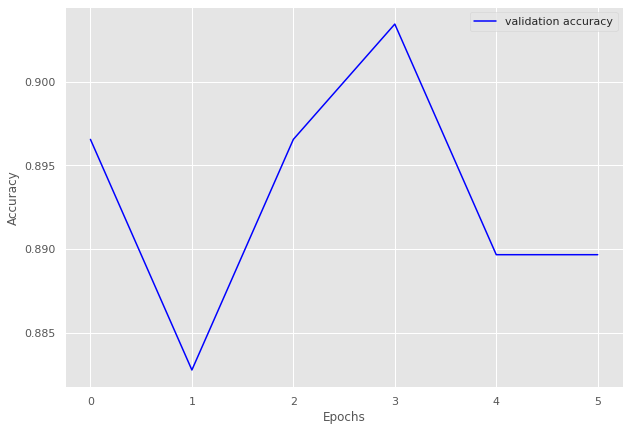

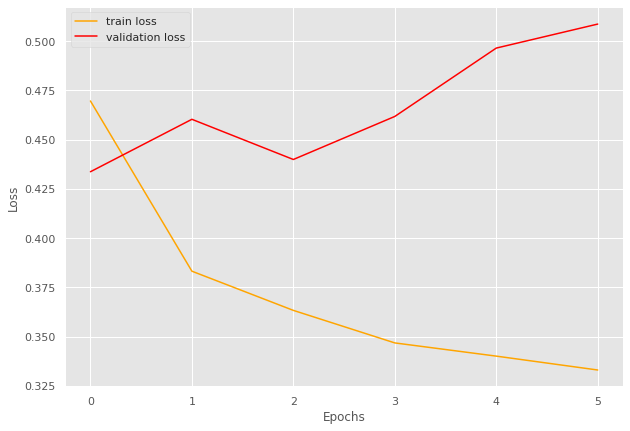

Done training of a fine model with test accuracy 0.9687282835302293
Coarse label 6 Epoch 1
-------------------------------


100%|██████████| 74/74 [00:25<00:00,  2.90batch/s, loss=1.49]


train loss 1.4901016354560852, validation loss 1.4887125343084335, validation accuracy 0.7176724137931034
Coarse label 6 Epoch 2
-------------------------------


100%|██████████| 74/74 [00:25<00:00,  2.89batch/s, loss=1.38]


train loss 1.3805949720176491, validation loss 1.485623225569725, validation accuracy 0.728448275862069
Coarse label 6 Epoch 3
-------------------------------


100%|██████████| 74/74 [00:26<00:00,  2.84batch/s, loss=1.35]


train loss 1.3463758020787626, validation loss 1.4628713876008987, validation accuracy 0.7456896551724138
Coarse label 6 Epoch 4
-------------------------------


100%|██████████| 74/74 [00:25<00:00,  2.87batch/s, loss=1.33]


train loss 1.3275870229746844, validation loss 1.4532682299613953, validation accuracy 0.7478448275862069
Coarse label 6 Epoch 5
-------------------------------


100%|██████████| 74/74 [00:25<00:00,  2.91batch/s, loss=1.32]


INFO: Early stopping counter 1 of 5
train loss 1.3212573189993162, validation loss 1.4605110585689545, validation accuracy 0.7543103448275862
Coarse label 6 Epoch 6
-------------------------------


100%|██████████| 74/74 [00:25<00:00,  2.86batch/s, loss=1.3] 


INFO: Early stopping counter 2 of 5
train loss 1.3043066408183124, validation loss 1.4712741374969482, validation accuracy 0.7413793103448276
Coarse label 6 Epoch 7
-------------------------------


100%|██████████| 74/74 [00:25<00:00,  2.89batch/s, loss=1.29]


train loss 1.290880575373366, validation loss 1.4480770081281662, validation accuracy 0.7586206896551724
Coarse label 6 Epoch 8
-------------------------------


100%|██████████| 74/74 [00:25<00:00,  2.91batch/s, loss=1.29]


INFO: Early stopping counter 3 of 5
train loss 1.286103825311403, validation loss 1.4590020924806595, validation accuracy 0.75
Coarse label 6 Epoch 9
-------------------------------


100%|██████████| 74/74 [00:25<00:00,  2.87batch/s, loss=1.28]


INFO: Early stopping counter 4 of 5
train loss 1.2797807068438143, validation loss 1.4729240387678146, validation accuracy 0.7413793103448276
Coarse label 6 Epoch 10
-------------------------------


100%|██████████| 74/74 [00:25<00:00,  2.86batch/s, loss=1.27]


INFO: Early stopping counter 5 of 5
INFO: Early stopping
Done! Saved model with test accuracy 0.9410225921521997 and loss 1.225005491213365


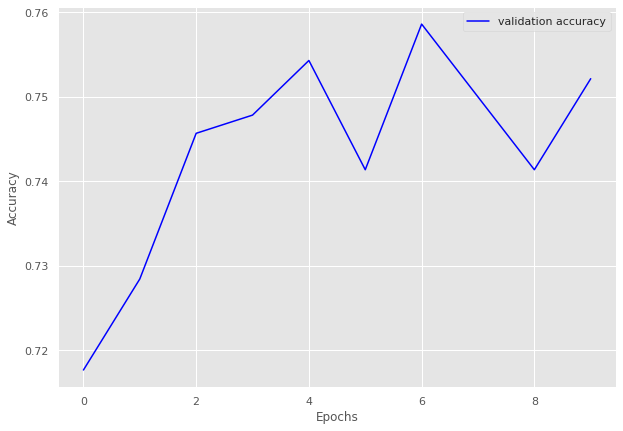

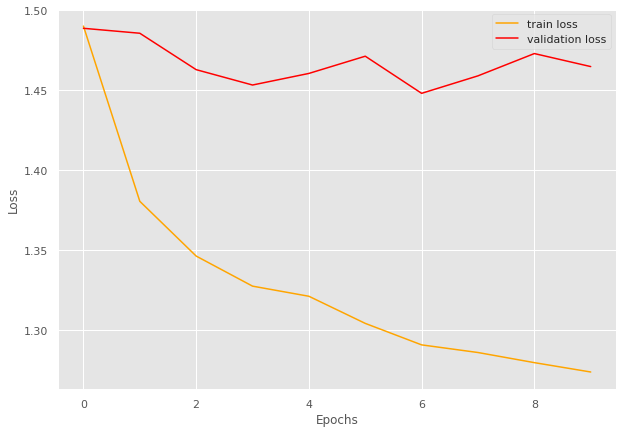

Done training of a fine model with test accuracy 0.9410225921521997
Coarse label 7 Epoch 1
-------------------------------


100%|██████████| 55/55 [00:18<00:00,  2.91batch/s, loss=0.953]


train loss 0.9527991771697998, validation loss 0.9227946499983469, validation accuracy 0.819672131147541
Coarse label 7 Epoch 2
-------------------------------


100%|██████████| 55/55 [00:19<00:00,  2.87batch/s, loss=0.866]


train loss 0.8661410927772522, validation loss 0.9191611011823019, validation accuracy 0.8306010928961749
Coarse label 7 Epoch 3
-------------------------------


100%|██████████| 55/55 [00:19<00:00,  2.87batch/s, loss=0.844]


train loss 0.8444581389427185, validation loss 0.9060850044091543, validation accuracy 0.8442622950819673
Coarse label 7 Epoch 4
-------------------------------


100%|██████████| 55/55 [00:19<00:00,  2.89batch/s, loss=0.828]


INFO: Early stopping counter 1 of 5
train loss 0.8284233212471008, validation loss 0.9309069017569224, validation accuracy 0.8169398907103825
Coarse label 7 Epoch 5
-------------------------------


100%|██████████| 55/55 [00:19<00:00,  2.88batch/s, loss=0.821]


INFO: Early stopping counter 2 of 5
train loss 0.8205236814238809, validation loss 0.9338032305240631, validation accuracy 0.8087431693989071
Coarse label 7 Epoch 6
-------------------------------


100%|██████████| 55/55 [00:18<00:00,  2.91batch/s, loss=0.817]


INFO: Early stopping counter 3 of 5
train loss 0.8166421673514627, validation loss 0.9305323561032613, validation accuracy 0.8224043715846995
Coarse label 7 Epoch 7
-------------------------------


100%|██████████| 55/55 [00:19<00:00,  2.86batch/s, loss=0.81] 


INFO: Early stopping counter 4 of 5
train loss 0.8099212874065745, validation loss 0.931735614935557, validation accuracy 0.8142076502732241
Coarse label 7 Epoch 8
-------------------------------


100%|██████████| 55/55 [00:19<00:00,  2.87batch/s, loss=0.803]


INFO: Early stopping counter 5 of 5
INFO: Early stopping
Done! Saved model with test accuracy 0.968408262454435 and loss 0.7754830591953717


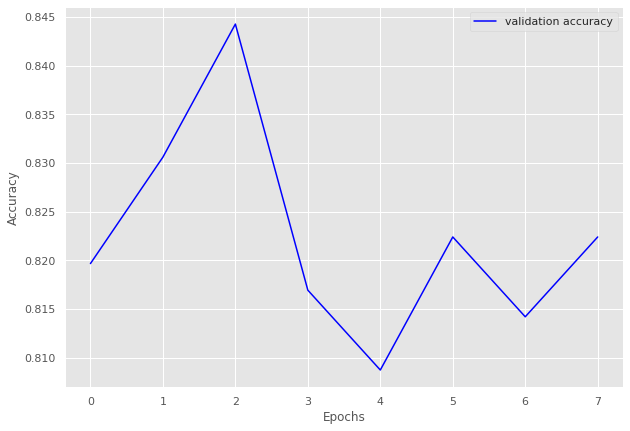

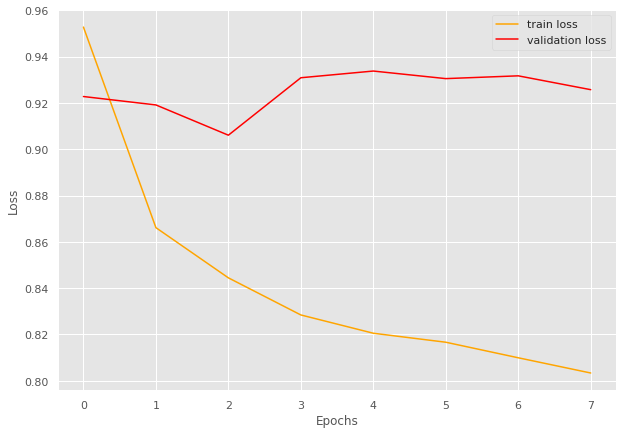

Done training of a fine model with test accuracy 0.968408262454435
Coarse label 8 Epoch 1
-------------------------------


100%|██████████| 81/81 [00:28<00:00,  2.88batch/s, loss=1.51]


train loss 1.5141528565206646, validation loss 1.4071438759565353, validation accuracy 0.7584830339321357
Coarse label 8 Epoch 2
-------------------------------


100%|██████████| 81/81 [00:27<00:00,  2.91batch/s, loss=1.38]


train loss 1.3753678695655163, validation loss 1.4051597714424133, validation accuracy 0.7564870259481038
Coarse label 8 Epoch 3
-------------------------------


100%|██████████| 81/81 [00:27<00:00,  2.90batch/s, loss=1.34]


INFO: Early stopping counter 1 of 5
train loss 1.3408625729290056, validation loss 1.4082713276147842, validation accuracy 0.7584830339321357
Coarse label 8 Epoch 4
-------------------------------


100%|██████████| 81/81 [00:28<00:00,  2.89batch/s, loss=1.33]


train loss 1.3277199945332092, validation loss 1.3870362639427185, validation accuracy 0.7744510978043913
Coarse label 8 Epoch 5
-------------------------------


100%|██████████| 81/81 [00:28<00:00,  2.85batch/s, loss=1.32]


INFO: Early stopping counter 2 of 5
train loss 1.320729497038288, validation loss 1.4155016243457794, validation accuracy 0.7405189620758483
Coarse label 8 Epoch 6
-------------------------------


100%|██████████| 81/81 [00:28<00:00,  2.87batch/s, loss=1.31]


INFO: Early stopping counter 3 of 5
train loss 1.3149869368400102, validation loss 1.3935202956199646, validation accuracy 0.7724550898203593
Coarse label 8 Epoch 7
-------------------------------


100%|██████████| 81/81 [00:27<00:00,  2.90batch/s, loss=1.3] 


INFO: Early stopping counter 4 of 5
train loss 1.2978500451570676, validation loss 1.4030426442623138, validation accuracy 0.7584830339321357
Coarse label 8 Epoch 8
-------------------------------


100%|██████████| 81/81 [00:27<00:00,  2.92batch/s, loss=1.29]


INFO: Early stopping counter 5 of 5
INFO: Early stopping
Done! Saved model with test accuracy 0.9290657439446367 and loss 1.237022244766967


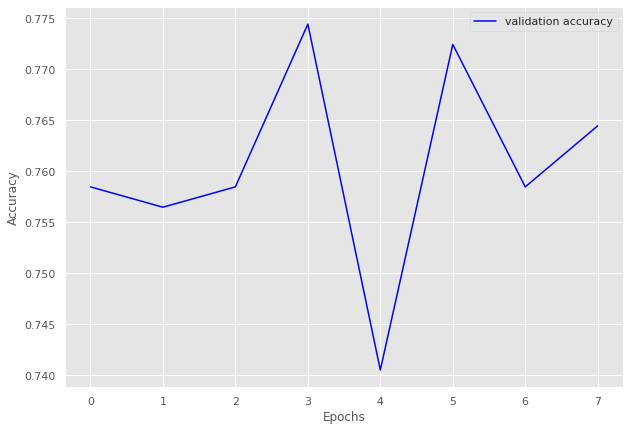

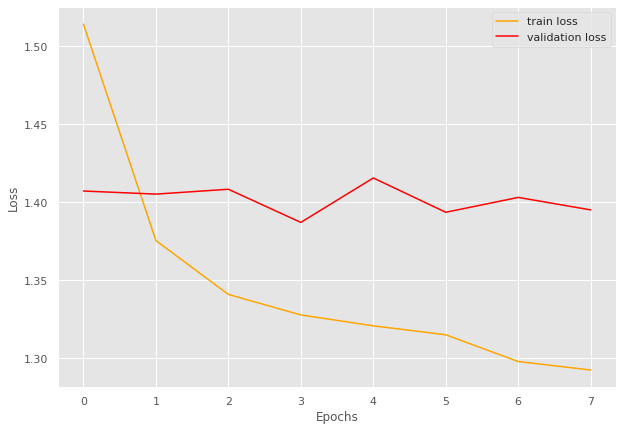

Done training of a fine model with test accuracy 0.9290657439446367
Coarse label 9 Epoch 1
-------------------------------


100%|██████████| 103/103 [00:35<00:00,  2.88batch/s, loss=1.82]


train loss 1.8225323933999515, validation loss 1.726918556473472, validation accuracy 0.7334293948126801
Coarse label 9 Epoch 2
-------------------------------


100%|██████████| 103/103 [00:35<00:00,  2.89batch/s, loss=1.7]


train loss 1.6989206353437554, validation loss 1.7130339795892888, validation accuracy 0.7406340057636888
Coarse label 9 Epoch 3
-------------------------------


100%|██████████| 103/103 [00:35<00:00,  2.87batch/s, loss=1.67]


train loss 1.673467246074121, validation loss 1.7090531479228626, validation accuracy 0.7478386167146974
Coarse label 9 Epoch 4
-------------------------------


100%|██████████| 103/103 [00:36<00:00,  2.84batch/s, loss=1.66]


INFO: Early stopping counter 1 of 5
train loss 1.6559989394493473, validation loss 1.7163387970490889, validation accuracy 0.7406340057636888
Coarse label 9 Epoch 5
-------------------------------


100%|██████████| 103/103 [00:35<00:00,  2.90batch/s, loss=1.64]


train loss 1.6421594793356737, validation loss 1.7046444090929898, validation accuracy 0.7492795389048992
Coarse label 9 Epoch 6
-------------------------------


100%|██████████| 103/103 [00:35<00:00,  2.87batch/s, loss=1.63]


INFO: Early stopping counter 2 of 5
train loss 1.6339183316647428, validation loss 1.7171659794720737, validation accuracy 0.7406340057636888
Coarse label 9 Epoch 7
-------------------------------


100%|██████████| 103/103 [00:35<00:00,  2.88batch/s, loss=1.62]


INFO: Early stopping counter 3 of 5
train loss 1.621552198835947, validation loss 1.708295757120306, validation accuracy 0.7521613832853026
Coarse label 9 Epoch 8
-------------------------------


100%|██████████| 103/103 [00:36<00:00,  2.86batch/s, loss=1.61]


train loss 1.610242431603589, validation loss 1.6970746083693071, validation accuracy 0.7622478386167147
Coarse label 9 Epoch 9
-------------------------------


100%|██████████| 103/103 [00:35<00:00,  2.89batch/s, loss=1.6]


INFO: Early stopping counter 4 of 5
train loss 1.603580450548709, validation loss 1.7064173004843972, validation accuracy 0.7449567723342939
Coarse label 9 Epoch 10
-------------------------------


100%|██████████| 103/103 [00:59<00:00,  1.75batch/s, loss=1.6] 


INFO: Early stopping counter 5 of 5
INFO: Early stopping
Done! Saved model with test accuracy 0.9375 and loss 1.52577394635781


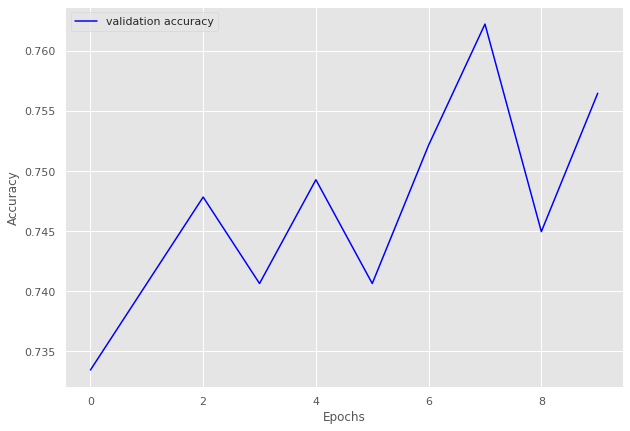

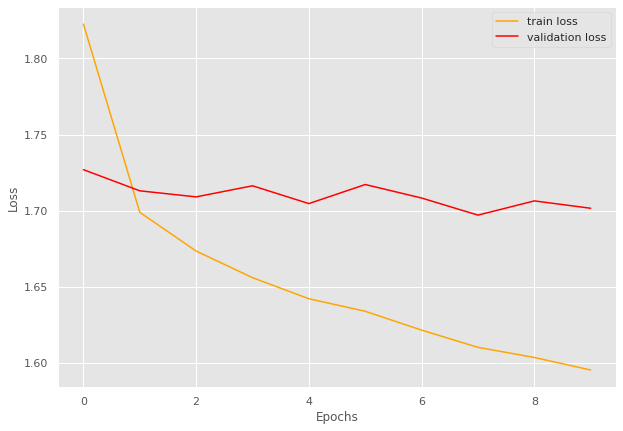

Done training of a fine model with test accuracy 0.9375
Coarse label 11 Epoch 1
-------------------------------


100%|██████████| 48/48 [00:37<00:00,  1.29batch/s, loss=0.984]


train loss 0.9838322487970194, validation loss 0.9625518202781678, validation accuracy 0.7923875432525952
Coarse label 11 Epoch 2
-------------------------------


100%|██████████| 48/48 [00:36<00:00,  1.31batch/s, loss=0.872]


train loss 0.8718590475618839, validation loss 0.9602499008178711, validation accuracy 0.7958477508650519
Coarse label 11 Epoch 3
-------------------------------


100%|██████████| 48/48 [00:26<00:00,  1.84batch/s, loss=0.841]


train loss 0.8413589385648569, validation loss 0.9478676557540894, validation accuracy 0.8062283737024222
Coarse label 11 Epoch 4
-------------------------------


100%|██████████| 48/48 [00:17<00:00,  2.81batch/s, loss=0.825]


INFO: Early stopping counter 1 of 5
train loss 0.825409951309363, validation loss 0.9573571801185607, validation accuracy 0.8096885813148789
Coarse label 11 Epoch 5
-------------------------------


100%|██████████| 48/48 [00:16<00:00,  2.88batch/s, loss=0.813]


INFO: Early stopping counter 2 of 5
train loss 0.8125460209945837, validation loss 0.9518712520599365, validation accuracy 0.8062283737024222
Coarse label 11 Epoch 6
-------------------------------


100%|██████████| 48/48 [00:16<00:00,  2.88batch/s, loss=0.805]


INFO: Early stopping counter 3 of 5
train loss 0.8048285332818826, validation loss 0.9616268038749695, validation accuracy 0.8027681660899654
Coarse label 11 Epoch 7
-------------------------------


100%|██████████| 48/48 [00:16<00:00,  2.86batch/s, loss=0.799]


INFO: Early stopping counter 4 of 5
train loss 0.7990046677490076, validation loss 0.9566959500312805, validation accuracy 0.8096885813148789
Coarse label 11 Epoch 8
-------------------------------


100%|██████████| 48/48 [00:16<00:00,  2.92batch/s, loss=0.795]


INFO: Early stopping counter 5 of 5
INFO: Early stopping
Done! Saved model with test accuracy 0.9728260869565217 and loss 0.7694040347229351


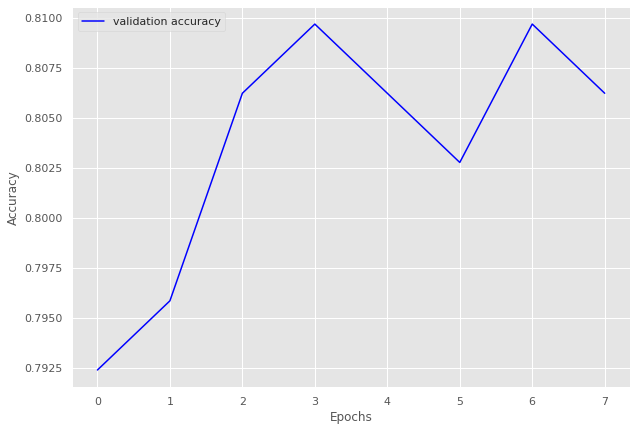

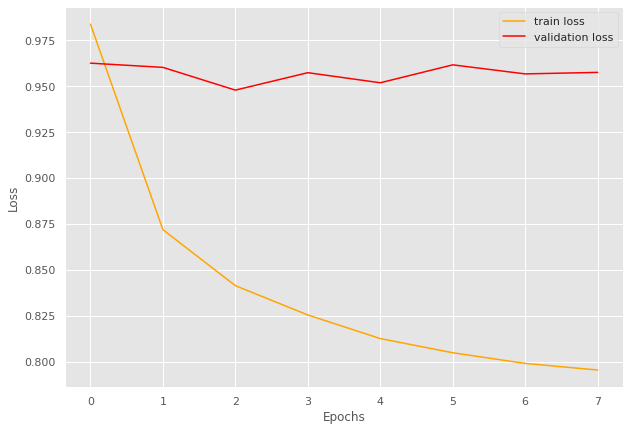

Done training of a fine model with test accuracy 0.9728260869565217
Coarse label 12 Epoch 1
-------------------------------


100%|██████████| 50/50 [00:17<00:00,  2.87batch/s, loss=1.45]


train loss 1.4481417870521545, validation loss 1.3411618709564208, validation accuracy 0.7075471698113207
Coarse label 12 Epoch 2
-------------------------------


100%|██████████| 50/50 [00:17<00:00,  2.89batch/s, loss=1.29]


train loss 1.2852889680862427, validation loss 1.3314603090286254, validation accuracy 0.7075471698113207
Coarse label 12 Epoch 3
-------------------------------


100%|██████████| 50/50 [00:17<00:00,  2.92batch/s, loss=1.24]


train loss 1.243345971107483, validation loss 1.3157257795333863, validation accuracy 0.720125786163522
Coarse label 12 Epoch 4
-------------------------------


100%|██████████| 50/50 [00:17<00:00,  2.87batch/s, loss=1.21]


train loss 1.208172264099121, validation loss 1.3131158351898193, validation accuracy 0.7295597484276729
Coarse label 12 Epoch 5
-------------------------------


100%|██████████| 50/50 [00:17<00:00,  2.89batch/s, loss=1.19]


INFO: Early stopping counter 1 of 5
train loss 1.1917510414123536, validation loss 1.3227654695510864, validation accuracy 0.7138364779874213
Coarse label 12 Epoch 6
-------------------------------


100%|██████████| 50/50 [00:17<00:00,  2.89batch/s, loss=1.17]


train loss 1.1667546343803405, validation loss 1.3100213050842284, validation accuracy 0.7295597484276729
Coarse label 12 Epoch 7
-------------------------------


100%|██████████| 50/50 [00:17<00:00,  2.93batch/s, loss=1.15]


INFO: Early stopping counter 2 of 5
train loss 1.1507311797142028, validation loss 1.3295939683914184, validation accuracy 0.710691823899371
Coarse label 12 Epoch 8
-------------------------------


100%|██████████| 50/50 [00:17<00:00,  2.91batch/s, loss=1.14]


INFO: Early stopping counter 3 of 5
train loss 1.13750648021698, validation loss 1.329032063484192, validation accuracy 0.710691823899371
Coarse label 12 Epoch 9
-------------------------------


100%|██████████| 50/50 [00:17<00:00,  2.86batch/s, loss=1.14]


INFO: Early stopping counter 4 of 5
train loss 1.137537064552307, validation loss 1.3400891542434692, validation accuracy 0.7044025157232704
Coarse label 12 Epoch 10
-------------------------------


100%|██████████| 50/50 [00:17<00:00,  2.91batch/s, loss=1.13]


INFO: Early stopping counter 5 of 5
INFO: Early stopping
Done! Saved model with test accuracy 0.9272727272727272 and loss 1.1161657231194633


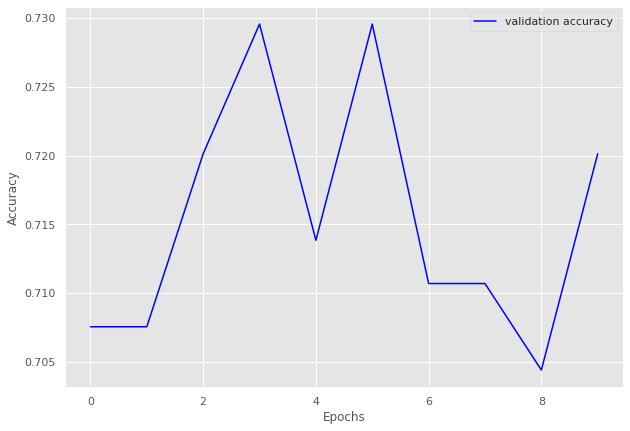

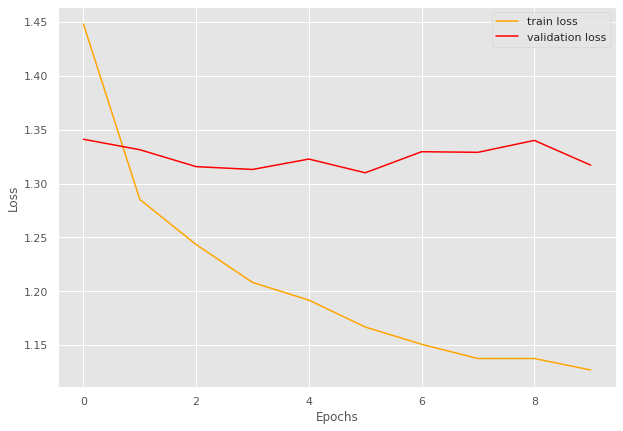

Done training of a fine model with test accuracy 0.9272727272727272
Coarse label 13 Epoch 1
-------------------------------


100%|██████████| 39/39 [00:13<00:00,  2.87batch/s, loss=0.765]


train loss 0.7654412266535636, validation loss 0.6944659948348999, validation accuracy 0.8528138528138528
Coarse label 13 Epoch 2
-------------------------------


100%|██████████| 39/39 [00:13<00:00,  2.89batch/s, loss=0.664]


train loss 0.6635651756555606, validation loss 0.6844481229782104, validation accuracy 0.8614718614718615
Coarse label 13 Epoch 3
-------------------------------


100%|██████████| 39/39 [00:13<00:00,  2.87batch/s, loss=0.638]


INFO: Early stopping counter 1 of 5
train loss 0.638215381365556, validation loss 0.6929410398006439, validation accuracy 0.8484848484848485
Coarse label 13 Epoch 4
-------------------------------


100%|██████████| 39/39 [00:13<00:00,  2.94batch/s, loss=0.616]


train loss 0.6162904424545093, validation loss 0.6812004745006561, validation accuracy 0.8658008658008658
Coarse label 13 Epoch 5
-------------------------------


100%|██████████| 39/39 [00:13<00:00,  2.93batch/s, loss=0.606]


train loss 0.6062979453649276, validation loss 0.6802132278680801, validation accuracy 0.8701298701298701
Coarse label 13 Epoch 6
-------------------------------


100%|██████████| 39/39 [00:13<00:00,  2.92batch/s, loss=0.603]


INFO: Early stopping counter 2 of 5
train loss 0.6033824758651929, validation loss 0.7019929587841034, validation accuracy 0.8398268398268398
Coarse label 13 Epoch 7
-------------------------------


100%|██████████| 39/39 [00:13<00:00,  2.87batch/s, loss=0.596]


train loss 0.5957623215822073, validation loss 0.6751576662063599, validation accuracy 0.8744588744588745
Coarse label 13 Epoch 8
-------------------------------


100%|██████████| 39/39 [00:13<00:00,  2.89batch/s, loss=0.589]


train loss 0.5886173202441289, validation loss 0.6736371666193008, validation accuracy 0.8744588744588745
Coarse label 13 Epoch 9
-------------------------------


100%|██████████| 39/39 [00:13<00:00,  2.92batch/s, loss=0.583]


INFO: Early stopping counter 3 of 5
train loss 0.5831784162765894, validation loss 0.6842203289270401, validation accuracy 0.8658008658008658
Coarse label 13 Epoch 10
-------------------------------


100%|██████████| 39/39 [00:13<00:00,  2.94batch/s, loss=0.584]


train loss 0.5840172691222949, validation loss 0.6622660309076309, validation accuracy 0.8831168831168831
Coarse label 13 Epoch 11
-------------------------------


100%|██████████| 39/39 [00:13<00:00,  2.90batch/s, loss=0.587]


INFO: Early stopping counter 4 of 5
train loss 0.5872791180243859, validation loss 0.6772948205471039, validation accuracy 0.8744588744588745
Coarse label 13 Epoch 12
-------------------------------


100%|██████████| 39/39 [00:13<00:00,  2.92batch/s, loss=0.586]


INFO: Early stopping counter 5 of 5
INFO: Early stopping
Done! Saved model with test accuracy 0.9384878257155062 and loss 0.6094376750894495


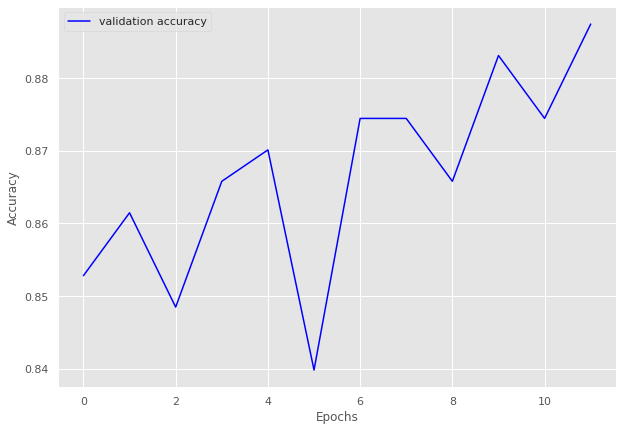

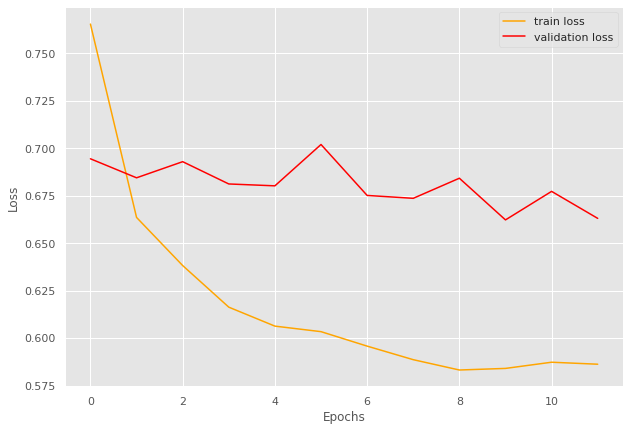

Done training of a fine model with test accuracy 0.9384878257155062
Coarse label 14 Epoch 1
-------------------------------


100%|██████████| 88/88 [00:30<00:00,  2.89batch/s, loss=1.28]


train loss 1.278686286373572, validation loss 1.2237387895584106, validation accuracy 0.8149466192170819
Coarse label 14 Epoch 2
-------------------------------


100%|██████████| 88/88 [00:32<00:00,  2.71batch/s, loss=1.19]


INFO: Early stopping counter 1 of 5
train loss 1.1876881935379722, validation loss 1.2250017060173883, validation accuracy 0.8131672597864769
Coarse label 14 Epoch 3
-------------------------------


100%|██████████| 88/88 [00:30<00:00,  2.89batch/s, loss=1.17]


INFO: Early stopping counter 2 of 5
train loss 1.16885736042803, validation loss 1.2348099549611409, validation accuracy 0.802491103202847
Coarse label 14 Epoch 4
-------------------------------


100%|██████████| 88/88 [00:30<00:00,  2.92batch/s, loss=1.15]


INFO: Early stopping counter 3 of 5
train loss 1.1542115252126346, validation loss 1.22539132171207, validation accuracy 0.8113879003558719
Coarse label 14 Epoch 5
-------------------------------


100%|██████████| 88/88 [00:30<00:00,  2.92batch/s, loss=1.15]


train loss 1.150310451334173, validation loss 1.211335712009006, validation accuracy 0.8309608540925267
Coarse label 14 Epoch 6
-------------------------------


100%|██████████| 88/88 [00:30<00:00,  2.86batch/s, loss=1.14]


INFO: Early stopping counter 4 of 5
train loss 1.1372548924251036, validation loss 1.218907528453403, validation accuracy 0.8185053380782918
Coarse label 14 Epoch 7
-------------------------------


100%|██████████| 88/88 [00:30<00:00,  2.92batch/s, loss=1.14]


INFO: Early stopping counter 5 of 5
INFO: Early stopping
Done! Saved model with test accuracy 0.9601860465116279 and loss 1.0844609226499284


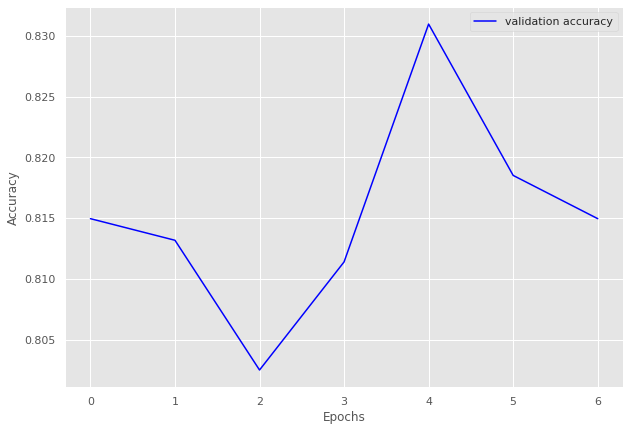

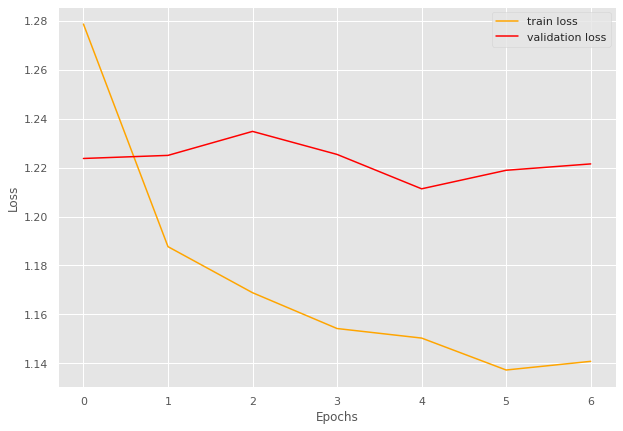

Done training of a fine model with test accuracy 0.9601860465116279
Coarse label 15 Epoch 1
-------------------------------


100%|██████████| 47/47 [00:16<00:00,  2.93batch/s, loss=1.02]


train loss 1.0152456608224423, validation loss 0.9513085722923279, validation accuracy 0.8098591549295775
Coarse label 15 Epoch 2
-------------------------------


100%|██████████| 47/47 [00:16<00:00,  2.93batch/s, loss=0.886]


train loss 0.886074607676648, validation loss 0.9453684568405152, validation accuracy 0.823943661971831
Coarse label 15 Epoch 3
-------------------------------


100%|██████████| 47/47 [00:16<00:00,  2.87batch/s, loss=0.854]


INFO: Early stopping counter 1 of 5
train loss 0.8542547847362275, validation loss 0.9532107830047607, validation accuracy 0.8133802816901409
Coarse label 15 Epoch 4
-------------------------------


100%|██████████| 47/47 [00:16<00:00,  2.91batch/s, loss=0.831]


INFO: Early stopping counter 2 of 5
train loss 0.8309096174037203, validation loss 0.9562204360961915, validation accuracy 0.8274647887323944
Coarse label 15 Epoch 5
-------------------------------


100%|██████████| 47/47 [00:16<00:00,  2.89batch/s, loss=0.826]


INFO: Early stopping counter 3 of 5
train loss 0.8257985990098182, validation loss 0.9535945296287537, validation accuracy 0.823943661971831
Coarse label 15 Epoch 6
-------------------------------


100%|██████████| 47/47 [00:16<00:00,  2.92batch/s, loss=0.812]


INFO: Early stopping counter 4 of 5
train loss 0.8118097427043509, validation loss 0.9496670246124268, validation accuracy 0.8133802816901409
Coarse label 15 Epoch 7
-------------------------------


100%|██████████| 47/47 [00:16<00:00,  2.91batch/s, loss=0.804]


INFO: Early stopping counter 5 of 5
INFO: Early stopping
Done! Saved model with test accuracy 0.948756593820648 and loss 0.7932954104173751


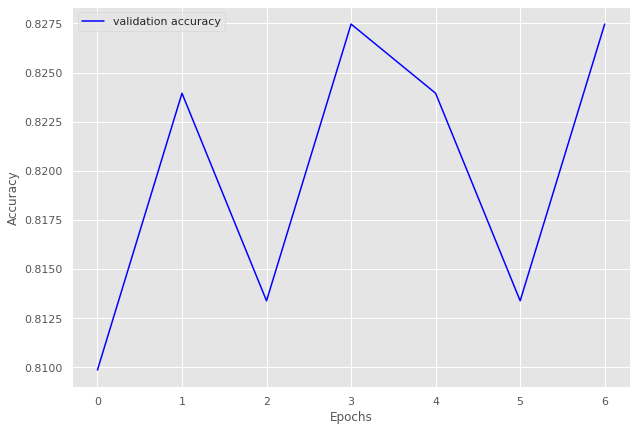

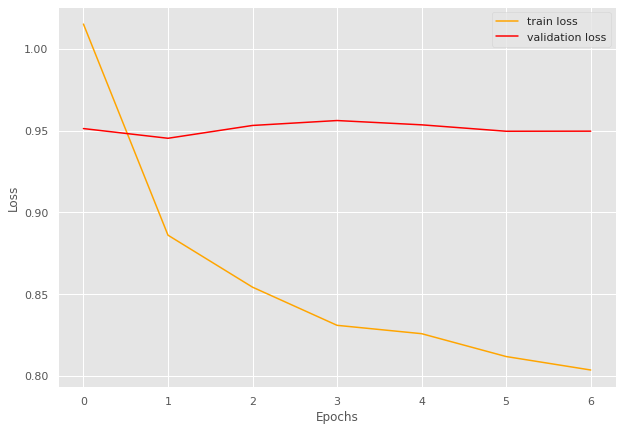

Done training of a fine model with test accuracy 0.948756593820648
Coarse label 16 Epoch 1
-------------------------------


100%|██████████| 44/44 [00:14<00:00,  2.98batch/s, loss=0.757]


train loss 0.7573631758039648, validation loss 0.709903109073639, validation accuracy 0.8091603053435115
Coarse label 16 Epoch 2
-------------------------------


100%|██████████| 44/44 [00:15<00:00,  2.93batch/s, loss=0.655]


INFO: Early stopping counter 1 of 5
train loss 0.6545223011211916, validation loss 0.7239098906517029, validation accuracy 0.7977099236641222
Coarse label 16 Epoch 3
-------------------------------


100%|██████████| 44/44 [00:14<00:00,  2.97batch/s, loss=0.636]


train loss 0.6357275951992382, validation loss 0.7036733269691468, validation accuracy 0.8053435114503816
Coarse label 16 Epoch 4
-------------------------------


100%|██████████| 44/44 [00:14<00:00,  2.95batch/s, loss=0.623]


INFO: Early stopping counter 2 of 5
train loss 0.6234650422226299, validation loss 0.7194082975387573, validation accuracy 0.8015267175572519
Coarse label 16 Epoch 5
-------------------------------


100%|██████████| 44/44 [00:14<00:00,  2.96batch/s, loss=0.612]


train loss 0.6119385442950509, validation loss 0.6938988447189331, validation accuracy 0.8206106870229007
Coarse label 16 Epoch 6
-------------------------------


100%|██████████| 44/44 [00:15<00:00,  2.88batch/s, loss=0.599]


train loss 0.5990780253301967, validation loss 0.6881503343582154, validation accuracy 0.8282442748091603
Coarse label 16 Epoch 7
-------------------------------


100%|██████████| 44/44 [00:15<00:00,  2.82batch/s, loss=0.594]


INFO: Early stopping counter 3 of 5
train loss 0.593932032585144, validation loss 0.6979116439819336, validation accuracy 0.816793893129771
Coarse label 16 Epoch 8
-------------------------------


100%|██████████| 44/44 [00:15<00:00,  2.87batch/s, loss=0.6]  


INFO: Early stopping counter 4 of 5
train loss 0.6004512133923444, validation loss 0.7023852348327637, validation accuracy 0.8129770992366412
Coarse label 16 Epoch 9
-------------------------------


100%|██████████| 44/44 [00:14<00:00,  2.94batch/s, loss=0.595]


INFO: Early stopping counter 5 of 5
INFO: Early stopping
Done! Saved model with test accuracy 0.967425431711146 and loss 0.5843131333589554


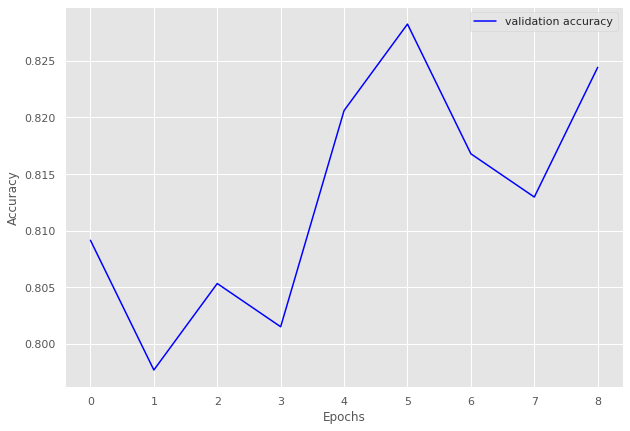

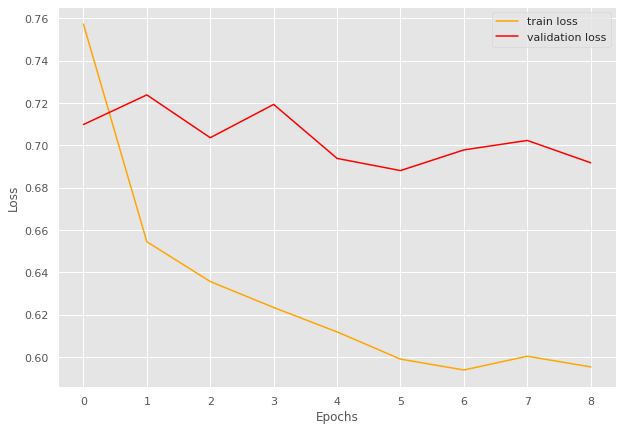

Done training of a fine model with test accuracy 0.967425431711146
Coarse label 17 Epoch 1
-------------------------------


100%|██████████| 48/48 [00:16<00:00,  2.89batch/s, loss=1.04]


train loss 1.0403232276439667, validation loss 0.9709375500679016, validation accuracy 0.7737704918032787
Coarse label 17 Epoch 2
-------------------------------


100%|██████████| 48/48 [00:16<00:00,  2.89batch/s, loss=0.904]


train loss 0.9044333187242349, validation loss 0.9681109070777894, validation accuracy 0.7737704918032787
Coarse label 17 Epoch 3
-------------------------------


100%|██████████| 48/48 [00:16<00:00,  2.92batch/s, loss=0.864]


train loss 0.8642524840931097, validation loss 0.9610149741172791, validation accuracy 0.7704918032786885
Coarse label 17 Epoch 4
-------------------------------


100%|██████████| 48/48 [00:16<00:00,  2.93batch/s, loss=0.846]


INFO: Early stopping counter 1 of 5
train loss 0.846136803428332, validation loss 0.961284601688385, validation accuracy 0.780327868852459
Coarse label 17 Epoch 5
-------------------------------


100%|██████████| 48/48 [00:16<00:00,  2.90batch/s, loss=0.834]


train loss 0.8344515562057495, validation loss 0.9498404860496521, validation accuracy 0.7967213114754098
Coarse label 17 Epoch 6
-------------------------------


100%|██████████| 48/48 [00:16<00:00,  2.92batch/s, loss=0.824]


INFO: Early stopping counter 2 of 5
train loss 0.8244641249378523, validation loss 0.9558090925216675, validation accuracy 0.7836065573770492
Coarse label 17 Epoch 7
-------------------------------


100%|██████████| 48/48 [00:16<00:00,  2.88batch/s, loss=0.822]


train loss 0.8217089076836904, validation loss 0.9424357533454895, validation accuracy 0.7967213114754098
Coarse label 17 Epoch 8
-------------------------------


100%|██████████| 48/48 [00:16<00:00,  2.90batch/s, loss=0.807]


train loss 0.8066566102206707, validation loss 0.9355792284011841, validation accuracy 0.8032786885245902
Coarse label 17 Epoch 9
-------------------------------


100%|██████████| 48/48 [00:16<00:00,  2.89batch/s, loss=0.804]


INFO: Early stopping counter 3 of 5
train loss 0.8041694561640421, validation loss 0.9409227132797241, validation accuracy 0.7967213114754098
Coarse label 17 Epoch 10
-------------------------------


100%|██████████| 48/48 [00:16<00:00,  2.90batch/s, loss=0.797]


INFO: Early stopping counter 4 of 5
train loss 0.796681847423315, validation loss 0.9434146642684936, validation accuracy 0.7934426229508197
Coarse label 17 Epoch 11
-------------------------------


100%|██████████| 48/48 [00:16<00:00,  2.90batch/s, loss=0.792]


INFO: Early stopping counter 5 of 5
INFO: Early stopping
Done! Saved model with test accuracy 0.9301575931232091 and loss 0.8132841979915445


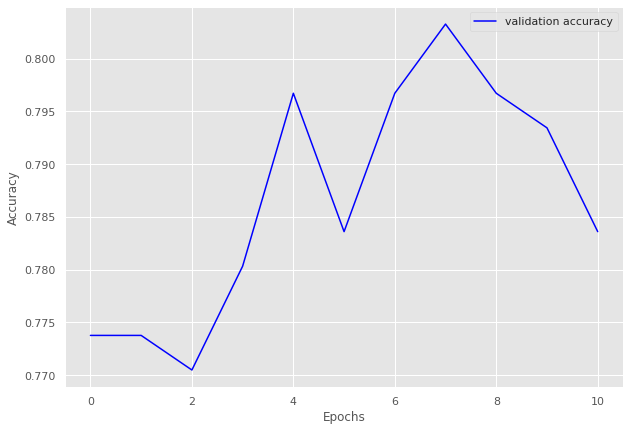

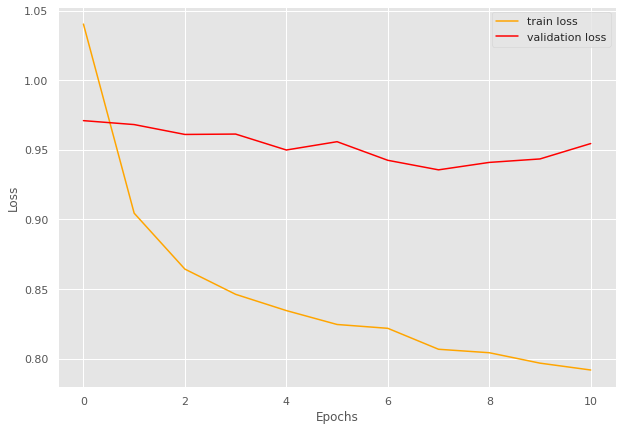

Done training of a fine model with test accuracy 0.9301575931232091
Coarse label 19 Epoch 1
-------------------------------


100%|██████████| 22/22 [00:07<00:00,  3.01batch/s, loss=1.19]


train loss 1.1920690726150165, validation loss 1.1746688882509868, validation accuracy 0.625
Coarse label 19 Epoch 2
-------------------------------


100%|██████████| 22/22 [00:07<00:00,  2.81batch/s, loss=0.989]


train loss 0.9894324188882654, validation loss 1.148890197277069, validation accuracy 0.6176470588235294
Coarse label 19 Epoch 3
-------------------------------


100%|██████████| 22/22 [00:07<00:00,  2.95batch/s, loss=0.892]


train loss 0.8917692303657532, validation loss 1.093275745709737, validation accuracy 0.6470588235294118
Coarse label 19 Epoch 4
-------------------------------


100%|██████████| 22/22 [00:07<00:00,  2.89batch/s, loss=0.837]


INFO: Early stopping counter 1 of 5
train loss 0.8371189046989788, validation loss 1.1377690037091572, validation accuracy 0.6617647058823529
Coarse label 19 Epoch 5
-------------------------------


100%|██████████| 22/22 [00:07<00:00,  2.92batch/s, loss=0.812]


INFO: Early stopping counter 2 of 5
train loss 0.8117448795925487, validation loss 1.1508410771687825, validation accuracy 0.6323529411764706
Coarse label 19 Epoch 6
-------------------------------


100%|██████████| 22/22 [00:07<00:00,  2.97batch/s, loss=0.805]


INFO: Early stopping counter 3 of 5
train loss 0.8050899695266377, validation loss 1.1725481748580933, validation accuracy 0.6029411764705882
Coarse label 19 Epoch 7
-------------------------------


100%|██████████| 22/22 [00:07<00:00,  2.95batch/s, loss=0.801]


INFO: Early stopping counter 4 of 5
train loss 0.8012258979407224, validation loss 1.1775091489156086, validation accuracy 0.6102941176470589
Coarse label 19 Epoch 8
-------------------------------


100%|██████████| 22/22 [00:07<00:00,  3.04batch/s, loss=0.794]


INFO: Early stopping counter 5 of 5
INFO: Early stopping
Done! Saved model with test accuracy 0.9230769230769231 and loss 0.8192931073052543


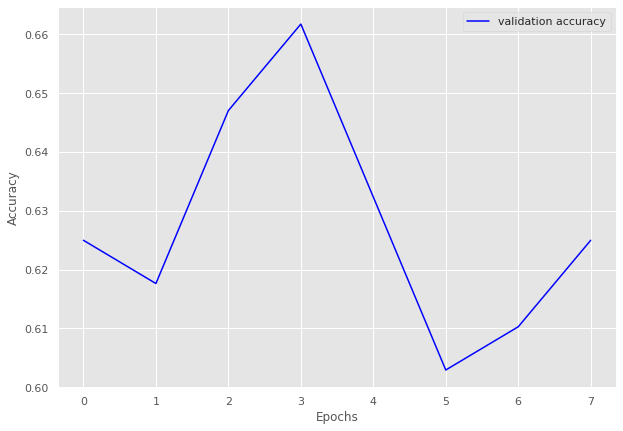

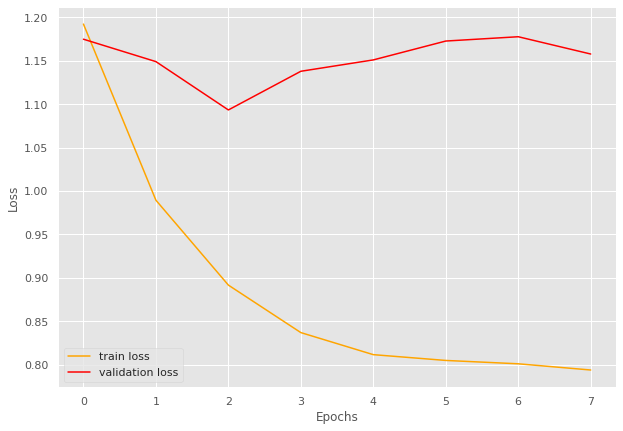

Done training of a fine model with test accuracy 0.9230769230769231
Starting model evaluation...
Evaluating fine model 0
Evaluating fine model 1
Evaluating fine model 2
Evaluating fine model 4
Evaluating fine model 5
Evaluating fine model 6
Evaluating fine model 7
Evaluating fine model 8
Evaluating fine model 9
Evaluating fine model 11
Evaluating fine model 12
Evaluating fine model 13
Evaluating fine model 14
Evaluating fine model 15
Evaluating fine model 16
Evaluating fine model 17
Evaluating fine model 19
overall accuracy  is 0.777702624676246
Calculating for volume 30
Start training a coarse model
Epoch 1
-------------------------------


100%|██████████| 1052/1052 [06:05<00:00,  2.87batch/s, loss=2.68]


train loss 2.6804291304526675, validation loss 2.6120216982705253, validation accuracy 0.4665171898355755
Epoch 2
-------------------------------


100%|██████████| 1052/1052 [07:52<00:00,  2.22batch/s, loss=2.6]


train loss 2.59853803318263, validation loss 2.5851632209051223, validation accuracy 0.49267563527653213
Epoch 3
-------------------------------


100%|██████████| 1052/1052 [06:05<00:00,  2.88batch/s, loss=2.57]


train loss 2.5663588314455272, validation loss 2.567217592965989, validation accuracy 0.5103139013452915
Epoch 4
-------------------------------


100%|██████████| 1052/1052 [06:06<00:00,  2.87batch/s, loss=2.56]


train loss 2.5555056637230935, validation loss 2.56036589940389, validation accuracy 0.5173393124065769
Epoch 5
-------------------------------


100%|██████████| 1052/1052 [06:05<00:00,  2.88batch/s, loss=2.55]


INFO: Early stopping counter 1 of 5
train loss 2.54638317284022, validation loss 2.562388413293021, validation accuracy 0.5155455904334828
Epoch 6
-------------------------------


100%|██████████| 1052/1052 [07:56<00:00,  2.21batch/s, loss=2.54]


train loss 2.538241967728836, validation loss 2.551332307997204, validation accuracy 0.5278026905829596
Epoch 7
-------------------------------


100%|██████████| 1052/1052 [06:06<00:00,  2.87batch/s, loss=2.53]


train loss 2.53226872632712, validation loss 2.54938117208935, validation accuracy 0.5288490284005979
Epoch 8
-------------------------------


100%|██████████| 1052/1052 [06:09<00:00,  2.84batch/s, loss=2.53]


INFO: Early stopping counter 2 of 5
train loss 2.5266005410440973, validation loss 2.5527576401120142, validation accuracy 0.5258594917787743
Epoch 9
-------------------------------


100%|██████████| 1052/1052 [06:05<00:00,  2.88batch/s, loss=2.52]


train loss 2.524917533189172, validation loss 2.5491033508664085, validation accuracy 0.5289985052316891
Epoch 10
-------------------------------


100%|██████████| 1052/1052 [06:36<00:00,  2.65batch/s, loss=2.52]


train loss 2.515497607876593, validation loss 2.528361938113258, validation accuracy 0.5508221225710015
Epoch 11
-------------------------------


100%|██████████| 1052/1052 [06:48<00:00,  2.58batch/s, loss=2.5]


train loss 2.4986544625387443, validation loss 2.5190258457547143, validation accuracy 0.558594917787743
Epoch 12
-------------------------------


100%|██████████| 1052/1052 [06:06<00:00,  2.87batch/s, loss=2.49]


train loss 2.491808436895958, validation loss 2.517311670666649, validation accuracy 0.5608370702541106
Epoch 13
-------------------------------


100%|██████████| 1052/1052 [06:05<00:00,  2.88batch/s, loss=2.49]


INFO: Early stopping counter 3 of 5
train loss 2.48597774578138, validation loss 2.51833758354187, validation accuracy 0.5602391629297458
Epoch 14
-------------------------------


100%|██████████| 1052/1052 [06:05<00:00,  2.88batch/s, loss=2.48]


train loss 2.4845805775529985, validation loss 2.515324444997878, validation accuracy 0.5624813153961136
Epoch 15
-------------------------------


100%|██████████| 1052/1052 [06:06<00:00,  2.87batch/s, loss=2.48]


train loss 2.475423991226878, validation loss 2.512074393317813, validation accuracy 0.5660687593423019
Epoch 16
-------------------------------


100%|██████████| 1052/1052 [07:53<00:00,  2.22batch/s, loss=2.47]


train loss 2.471497648115847, validation loss 2.5101404303596135, validation accuracy 0.5680119581464873
Epoch 17
-------------------------------


100%|██████████| 1052/1052 [06:08<00:00,  2.86batch/s, loss=2.47]


INFO: Early stopping counter 4 of 5
train loss 2.469279574577346, validation loss 2.512128530229841, validation accuracy 0.5665171898355755
Epoch 18
-------------------------------


100%|██████████| 1052/1052 [06:05<00:00,  2.88batch/s, loss=2.46]


train loss 2.4647682567513036, validation loss 2.508011681692941, validation accuracy 0.5713004484304933
Epoch 19
-------------------------------


100%|██████████| 1052/1052 [07:55<00:00,  2.21batch/s, loss=2.46]


train loss 2.4637059809590474, validation loss 2.503350814183553, validation accuracy 0.5756352765321375
Epoch 20
-------------------------------


100%|██████████| 1052/1052 [06:05<00:00,  2.88batch/s, loss=2.46]


train loss 2.462987641417935, validation loss 2.5027366683596655, validation accuracy 0.5769805680119582
Epoch 21
-------------------------------


100%|██████████| 1052/1052 [06:04<00:00,  2.88batch/s, loss=2.45]


train loss 2.453443482121587, validation loss 2.5017644337245395, validation accuracy 0.5780269058295964
Epoch 22
-------------------------------


100%|██████████| 1052/1052 [06:06<00:00,  2.87batch/s, loss=2.45]


INFO: Early stopping counter 5 of 5
INFO: Early stopping
Done! Saved model with test accuracy 0.8046092680271211 and loss 2.2734510730087507


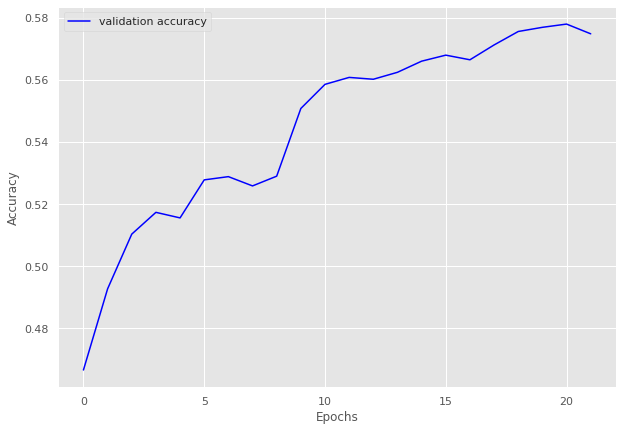

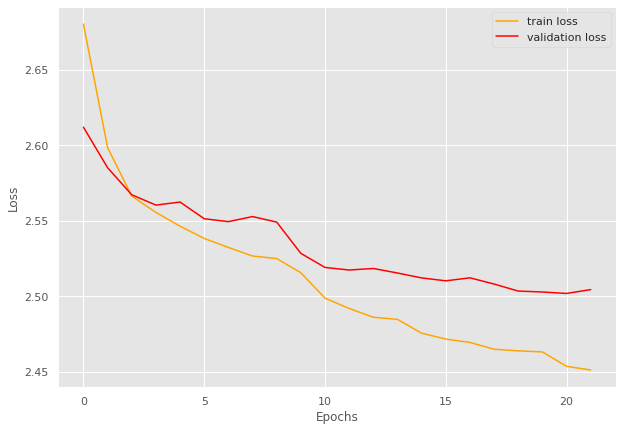

Done training of a coarse model with test accuracy 0.8046092680271211
Coarse label 0 Epoch 1
-------------------------------


100%|██████████| 64/64 [00:23<00:00,  2.78batch/s, loss=1.25]


train loss 1.2528669107705355, validation loss 1.2190684080123901, validation accuracy 0.7373737373737373
Coarse label 0 Epoch 2
-------------------------------


100%|██████████| 64/64 [00:22<00:00,  2.83batch/s, loss=1.12]


INFO: Early stopping counter 1 of 5
train loss 1.1190831642597914, validation loss 1.2194672993251257, validation accuracy 0.7525252525252525
Coarse label 0 Epoch 3
-------------------------------


100%|██████████| 64/64 [00:22<00:00,  2.88batch/s, loss=1.09]


train loss 1.0873499065637589, validation loss 1.219010489327567, validation accuracy 0.7449494949494949
Coarse label 0 Epoch 4
-------------------------------


100%|██████████| 64/64 [00:22<00:00,  2.91batch/s, loss=1.06]


INFO: Early stopping counter 2 of 5
train loss 1.0648882538080215, validation loss 1.244782873562404, validation accuracy 0.7247474747474747
Coarse label 0 Epoch 5
-------------------------------


100%|██████████| 64/64 [00:22<00:00,  2.88batch/s, loss=1.05]


train loss 1.0492669185623527, validation loss 1.2188025883265905, validation accuracy 0.7323232323232324
Coarse label 0 Epoch 6
-------------------------------


100%|██████████| 64/64 [00:22<00:00,  2.89batch/s, loss=1.04]


INFO: Early stopping counter 3 of 5
train loss 1.035094991326332, validation loss 1.2303070681435722, validation accuracy 0.7323232323232324
Coarse label 0 Epoch 7
-------------------------------


100%|██████████| 64/64 [00:22<00:00,  2.89batch/s, loss=1.03]


INFO: Early stopping counter 4 of 5
train loss 1.025256416760385, validation loss 1.2379391363688879, validation accuracy 0.7474747474747475
Coarse label 0 Epoch 8
-------------------------------


100%|██████████| 64/64 [00:22<00:00,  2.90batch/s, loss=1.01]


INFO: Early stopping counter 5 of 5
INFO: Early stopping
Done! Saved model with test accuracy 0.9450295402003597 and loss 0.9611275420814264


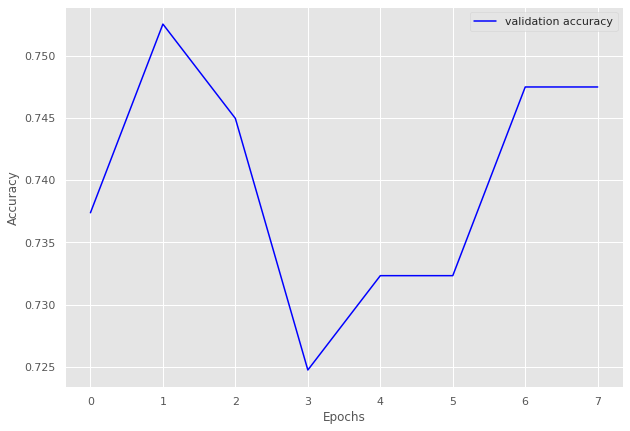

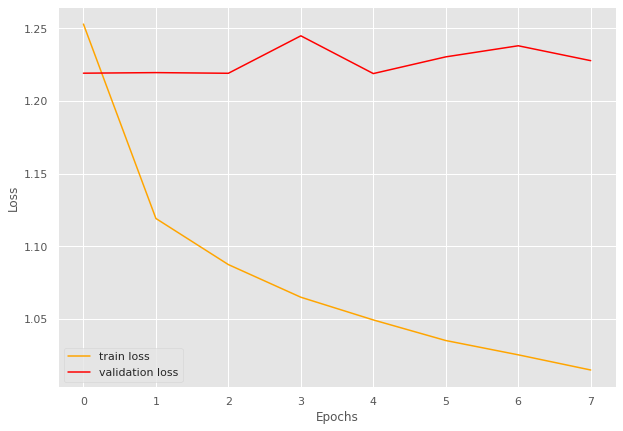

Done training of a fine model with test accuracy 0.9450295402003597
Coarse label 1 Epoch 1
-------------------------------


100%|██████████| 40/40 [00:13<00:00,  2.97batch/s, loss=1.55]


train loss 1.5547343820333481, validation loss 1.5272494316101075, validation accuracy 0.516728624535316
Coarse label 1 Epoch 2
-------------------------------


100%|██████████| 40/40 [00:13<00:00,  2.93batch/s, loss=1.42]


INFO: Early stopping counter 1 of 5
train loss 1.4192187875509261, validation loss 1.5467233180999755, validation accuracy 0.516728624535316
Coarse label 1 Epoch 3
-------------------------------


100%|██████████| 40/40 [00:13<00:00,  2.94batch/s, loss=1.33]


INFO: Early stopping counter 2 of 5
train loss 1.3335189789533615, validation loss 1.5433327674865722, validation accuracy 0.5315985130111525
Coarse label 1 Epoch 4
-------------------------------


100%|██████████| 40/40 [00:13<00:00,  2.95batch/s, loss=1.27]


INFO: Early stopping counter 3 of 5
train loss 1.2670286625623703, validation loss 1.5579079389572144, validation accuracy 0.5204460966542751
Coarse label 1 Epoch 5
-------------------------------


100%|██████████| 40/40 [00:13<00:00,  2.91batch/s, loss=1.22]


INFO: Early stopping counter 4 of 5
train loss 1.2183089047670363, validation loss 1.5554508447647095, validation accuracy 0.5353159851301115
Coarse label 1 Epoch 6
-------------------------------


100%|██████████| 40/40 [00:13<00:00,  2.86batch/s, loss=1.18]


INFO: Early stopping counter 5 of 5
INFO: Early stopping
Done! Saved model with test accuracy 0.9298349056603774 and loss 1.117147931346187


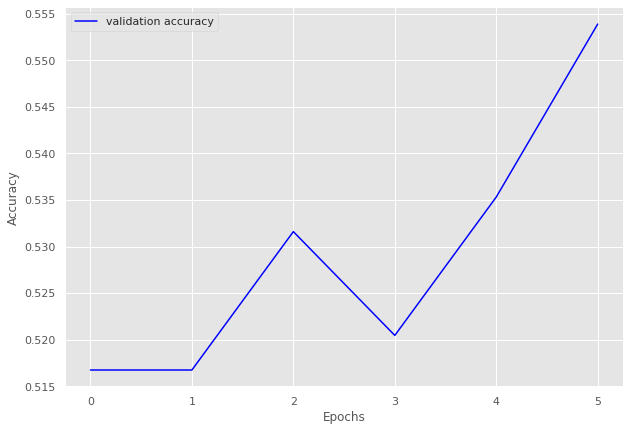

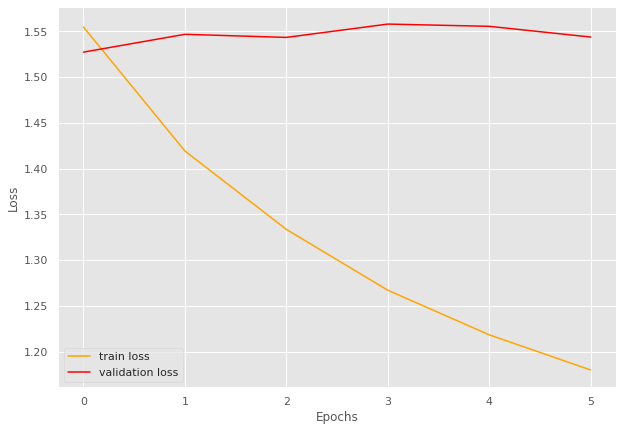

Done training of a fine model with test accuracy 0.9298349056603774
Coarse label 2 Epoch 1
-------------------------------


100%|██████████| 129/129 [01:08<00:00,  1.87batch/s, loss=1.86]


train loss 1.8572282144265582, validation loss 1.791027341570173, validation accuracy 0.6883886255924171
Coarse label 2 Epoch 2
-------------------------------


100%|██████████| 129/129 [01:42<00:00,  1.26batch/s, loss=1.74]


INFO: Early stopping counter 1 of 5
train loss 1.7390167787093525, validation loss 1.7935740947723389, validation accuracy 0.6883886255924171
Coarse label 2 Epoch 3
-------------------------------


100%|██████████| 129/129 [01:07<00:00,  1.92batch/s, loss=1.71]


train loss 1.7120915651321411, validation loss 1.7729893667357308, validation accuracy 0.6990521327014217
Coarse label 2 Epoch 4
-------------------------------


100%|██████████| 129/129 [00:45<00:00,  2.87batch/s, loss=1.69]


INFO: Early stopping counter 2 of 5
train loss 1.693597580111304, validation loss 1.7905218686376299, validation accuracy 0.6824644549763034
Coarse label 2 Epoch 5
-------------------------------


100%|██████████| 129/129 [00:45<00:00,  2.84batch/s, loss=1.69]


train loss 1.687277169190636, validation loss 1.7638307128633772, validation accuracy 0.7132701421800948
Coarse label 2 Epoch 6
-------------------------------


100%|██████████| 129/129 [00:44<00:00,  2.87batch/s, loss=1.68]


INFO: Early stopping counter 3 of 5
train loss 1.6790370821028717, validation loss 1.7721557787486486, validation accuracy 0.7014218009478673
Coarse label 2 Epoch 7
-------------------------------


100%|██████████| 129/129 [00:45<00:00,  2.86batch/s, loss=1.67]


INFO: Early stopping counter 4 of 5
train loss 1.670004320699115, validation loss 1.7649012889180864, validation accuracy 0.7097156398104265
Coarse label 2 Epoch 8
-------------------------------


100%|██████████| 129/129 [00:44<00:00,  2.88batch/s, loss=1.66]


INFO: Early stopping counter 5 of 5
INFO: Early stopping
Done! Saved model with test accuracy 0.9215760800709489 and loss 1.5420476428924068


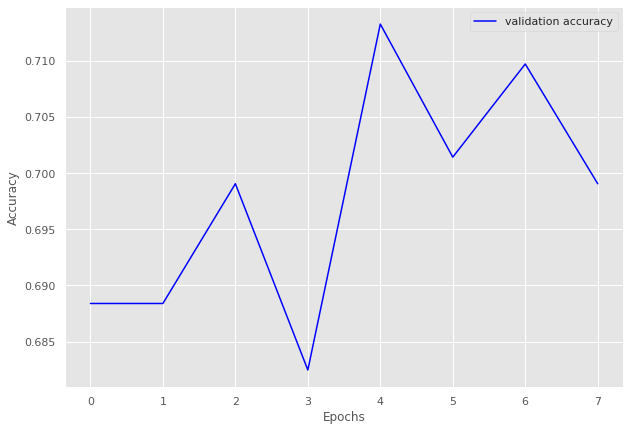

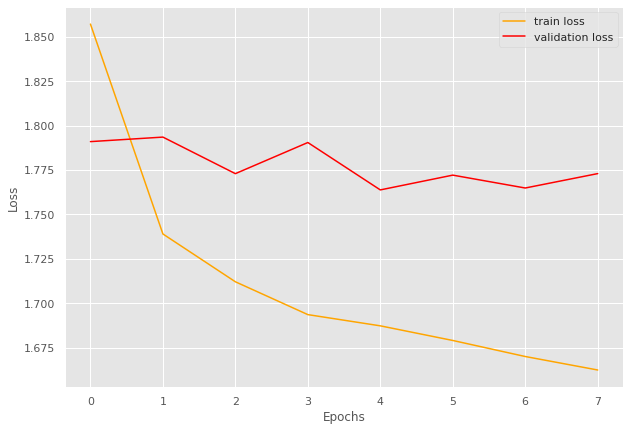

Done training of a fine model with test accuracy 0.9215760800709489
Coarse label 4 Epoch 1
-------------------------------


100%|██████████| 67/67 [00:23<00:00,  2.87batch/s, loss=1.45]


train loss 1.4517338186947268, validation loss 1.4390356029782976, validation accuracy 0.645320197044335
Coarse label 4 Epoch 2
-------------------------------


100%|██████████| 67/67 [00:24<00:00,  2.77batch/s, loss=1.31]


train loss 1.312645182680728, validation loss 1.4023951121738978, validation accuracy 0.6773399014778325
Coarse label 4 Epoch 3
-------------------------------


100%|██████████| 67/67 [00:22<00:00,  2.93batch/s, loss=1.26]


train loss 1.260355385381784, validation loss 1.3875470331736974, validation accuracy 0.7044334975369458
Coarse label 4 Epoch 4
-------------------------------


100%|██████████| 67/67 [00:22<00:00,  2.94batch/s, loss=1.24]


INFO: Early stopping counter 1 of 5
train loss 1.238748954303229, validation loss 1.3985843658447266, validation accuracy 0.6773399014778325
Coarse label 4 Epoch 5
-------------------------------


100%|██████████| 67/67 [00:23<00:00,  2.89batch/s, loss=1.22]


INFO: Early stopping counter 2 of 5
train loss 1.217765228072209, validation loss 1.397241575377328, validation accuracy 0.6847290640394089
Coarse label 4 Epoch 6
-------------------------------


100%|██████████| 67/67 [00:22<00:00,  2.95batch/s, loss=1.2] 


INFO: Early stopping counter 3 of 5
train loss 1.1962532997131348, validation loss 1.4080323491777693, validation accuracy 0.6773399014778325
Coarse label 4 Epoch 7
-------------------------------


100%|██████████| 67/67 [00:23<00:00,  2.91batch/s, loss=1.18]


INFO: Early stopping counter 4 of 5
train loss 1.1783757530041594, validation loss 1.4023960317884172, validation accuracy 0.6822660098522167
Coarse label 4 Epoch 8
-------------------------------


100%|██████████| 67/67 [00:22<00:00,  2.93batch/s, loss=1.17]


INFO: Early stopping counter 5 of 5
INFO: Early stopping
Done! Saved model with test accuracy 0.9176281191306681 and loss 1.1267643924486839


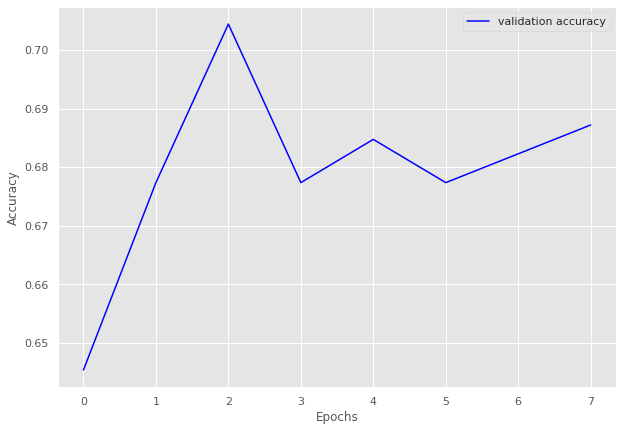

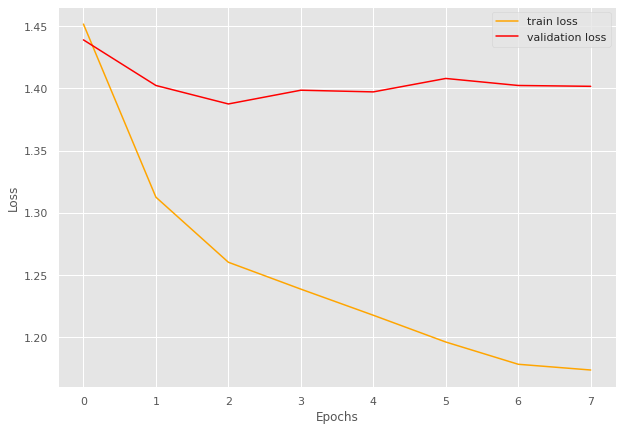

Done training of a fine model with test accuracy 0.9176281191306681
Coarse label 5 Epoch 1
-------------------------------


100%|██████████| 25/25 [00:08<00:00,  3.00batch/s, loss=0.514]


train loss 0.5135380125045776, validation loss 0.45138176282246906, validation accuracy 0.8466257668711656
Coarse label 5 Epoch 2
-------------------------------


100%|██████████| 25/25 [00:08<00:00,  2.97batch/s, loss=0.392]


INFO: Early stopping counter 1 of 5
train loss 0.39205484867095947, validation loss 0.5014897982279459, validation accuracy 0.7975460122699386
Coarse label 5 Epoch 3
-------------------------------


100%|██████████| 25/25 [00:08<00:00,  2.95batch/s, loss=0.354]


INFO: Early stopping counter 2 of 5
train loss 0.3544425868988037, validation loss 0.523791124423345, validation accuracy 0.7852760736196319
Coarse label 5 Epoch 4
-------------------------------


100%|██████████| 25/25 [00:08<00:00,  2.96batch/s, loss=0.351]


INFO: Early stopping counter 3 of 5
train loss 0.35086777687072757, validation loss 0.49244306484858197, validation accuracy 0.7914110429447853
Coarse label 5 Epoch 5
-------------------------------


100%|██████████| 25/25 [00:08<00:00,  2.92batch/s, loss=0.349]


INFO: Early stopping counter 4 of 5
train loss 0.3486878407001495, validation loss 0.48018425703048706, validation accuracy 0.8343558282208589
Coarse label 5 Epoch 6
-------------------------------


100%|██████████| 25/25 [00:08<00:00,  2.95batch/s, loss=0.353]


INFO: Early stopping counter 5 of 5
INFO: Early stopping
Done! Saved model with test accuracy 0.965948575399583 and loss 0.3469406159027763


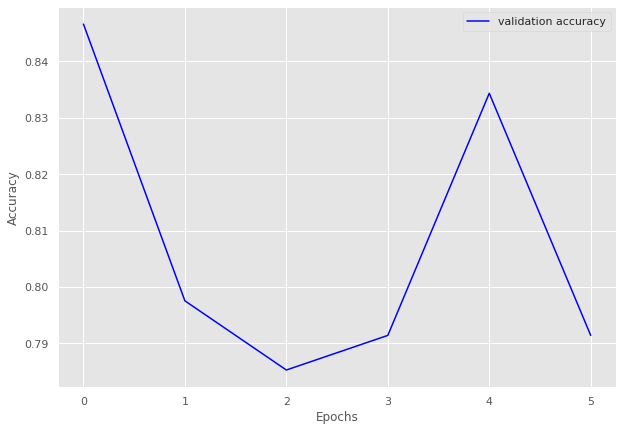

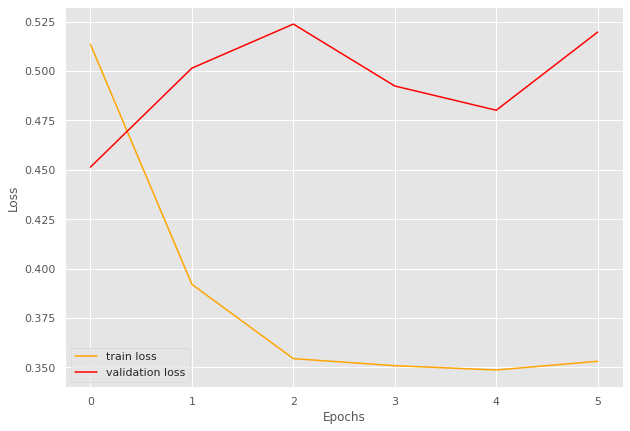

Done training of a fine model with test accuracy 0.965948575399583
Coarse label 6 Epoch 1
-------------------------------


100%|██████████| 75/75 [00:26<00:00,  2.85batch/s, loss=1.56]


train loss 1.560120299657186, validation loss 1.4713980640683855, validation accuracy 0.6931818181818182
Coarse label 6 Epoch 2
-------------------------------


100%|██████████| 75/75 [00:25<00:00,  2.89batch/s, loss=1.44]


train loss 1.442751661936442, validation loss 1.4536199740001134, validation accuracy 0.7113636363636363
Coarse label 6 Epoch 3
-------------------------------


100%|██████████| 75/75 [00:27<00:00,  2.69batch/s, loss=1.41]


INFO: Early stopping counter 1 of 5
train loss 1.4136917034784953, validation loss 1.4708513872964042, validation accuracy 0.6931818181818182
Coarse label 6 Epoch 4
-------------------------------


100%|██████████| 75/75 [00:25<00:00,  2.90batch/s, loss=1.39]


INFO: Early stopping counter 2 of 5
train loss 1.3889472198486328, validation loss 1.4842334134238107, validation accuracy 0.6795454545454546
Coarse label 6 Epoch 5
-------------------------------


100%|██████████| 75/75 [00:26<00:00,  2.83batch/s, loss=1.37]


INFO: Early stopping counter 3 of 5
train loss 1.3665403906504314, validation loss 1.4628480332238334, validation accuracy 0.7068181818181818
Coarse label 6 Epoch 6
-------------------------------


100%|██████████| 75/75 [00:26<00:00,  2.88batch/s, loss=1.34]


INFO: Early stopping counter 4 of 5
train loss 1.3427420234680176, validation loss 1.4682646138327462, validation accuracy 0.7045454545454546
Coarse label 6 Epoch 7
-------------------------------


100%|██████████| 75/75 [00:25<00:00,  2.89batch/s, loss=1.34]


INFO: Early stopping counter 5 of 5
INFO: Early stopping
Done! Saved model with test accuracy 0.9326991676575506 and loss 1.233887089021278


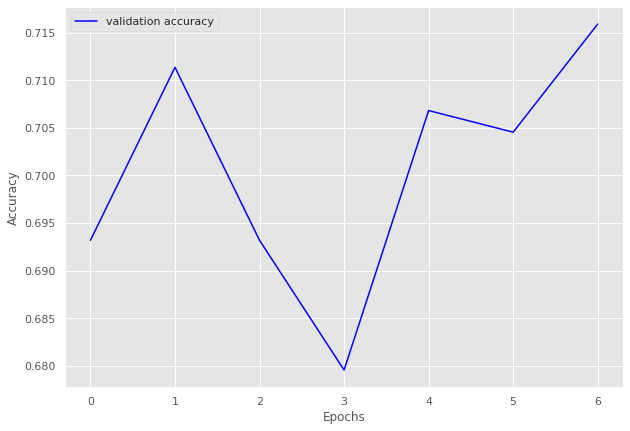

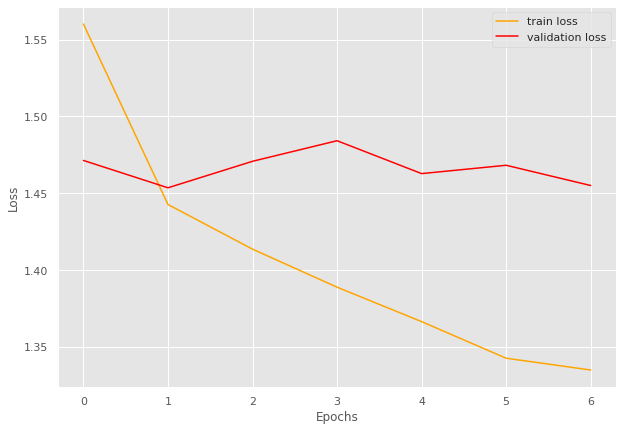

Done training of a fine model with test accuracy 0.9326991676575506
Coarse label 7 Epoch 1
-------------------------------


100%|██████████| 54/54 [00:18<00:00,  2.86batch/s, loss=1.02]


train loss 1.0240667716220573, validation loss 0.9654628932476044, validation accuracy 0.7869318181818182
Coarse label 7 Epoch 2
-------------------------------


100%|██████████| 54/54 [00:18<00:00,  2.85batch/s, loss=0.924]


train loss 0.9243892839661351, validation loss 0.9555206994215647, validation accuracy 0.8096590909090909
Coarse label 7 Epoch 3
-------------------------------


100%|██████████| 54/54 [00:19<00:00,  2.83batch/s, loss=0.886]


INFO: Early stopping counter 1 of 5
train loss 0.8858259518941244, validation loss 0.959578295548757, validation accuracy 0.7982954545454546
Coarse label 7 Epoch 4
-------------------------------


100%|██████████| 54/54 [00:18<00:00,  2.92batch/s, loss=0.866]


INFO: Early stopping counter 2 of 5
train loss 0.8656957966310007, validation loss 0.9648774464925131, validation accuracy 0.7982954545454546
Coarse label 7 Epoch 5
-------------------------------


100%|██████████| 54/54 [00:18<00:00,  2.92batch/s, loss=0.847]


INFO: Early stopping counter 3 of 5
train loss 0.8465885012238114, validation loss 0.9630140662193298, validation accuracy 0.8096590909090909
Coarse label 7 Epoch 6
-------------------------------


100%|██████████| 54/54 [00:19<00:00,  2.84batch/s, loss=0.831]


train loss 0.8309572305944231, validation loss 0.945247600475947, validation accuracy 0.8181818181818182
Coarse label 7 Epoch 7
-------------------------------


100%|██████████| 54/54 [00:18<00:00,  2.90batch/s, loss=0.821]


INFO: Early stopping counter 4 of 5
train loss 0.8214526386172684, validation loss 0.965415358543396, validation accuracy 0.7926136363636364
Coarse label 7 Epoch 8
-------------------------------


100%|██████████| 54/54 [00:18<00:00,  2.91batch/s, loss=0.824]


INFO: Early stopping counter 5 of 5
INFO: Early stopping
Done! Saved model with test accuracy 0.9556500607533415 and loss 0.7874682224713839


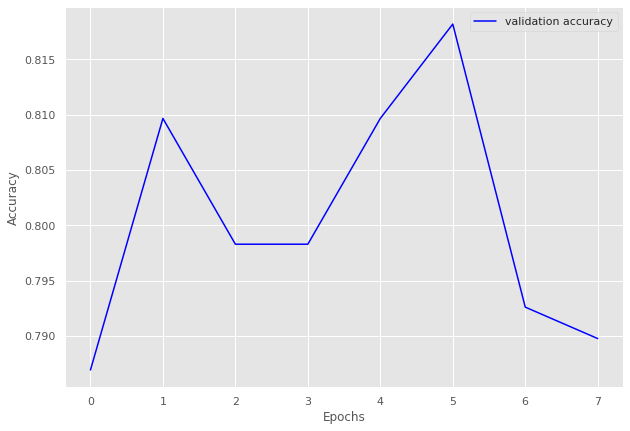

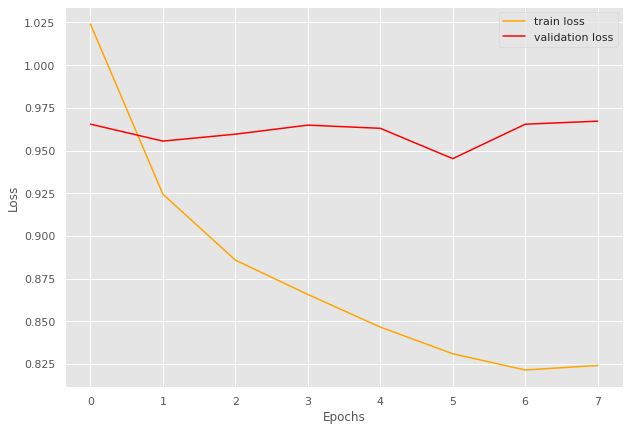

Done training of a fine model with test accuracy 0.9556500607533415
Coarse label 8 Epoch 1
-------------------------------


100%|██████████| 81/81 [00:27<00:00,  2.92batch/s, loss=1.56]


train loss 1.5627770291434393, validation loss 1.4806443899869919, validation accuracy 0.6771037181996086
Coarse label 8 Epoch 2
-------------------------------


100%|██████████| 81/81 [00:27<00:00,  2.91batch/s, loss=1.44]


INFO: Early stopping counter 1 of 5
train loss 1.4400154808421193, validation loss 1.4853972047567368, validation accuracy 0.6673189823874756
Coarse label 8 Epoch 3
-------------------------------


100%|██████████| 81/81 [00:27<00:00,  2.91batch/s, loss=1.4] 


train loss 1.4041523300571206, validation loss 1.4730199128389359, validation accuracy 0.684931506849315
Coarse label 8 Epoch 4
-------------------------------


100%|██████████| 81/81 [00:28<00:00,  2.82batch/s, loss=1.38]


INFO: Early stopping counter 2 of 5
train loss 1.379403508739707, validation loss 1.4792181551456451, validation accuracy 0.6790606653620352
Coarse label 8 Epoch 5
-------------------------------


100%|██████████| 81/81 [00:28<00:00,  2.88batch/s, loss=1.36]


INFO: Early stopping counter 3 of 5
train loss 1.3643176938280648, validation loss 1.4955118298530579, validation accuracy 0.6614481409001957
Coarse label 8 Epoch 6
-------------------------------


100%|██████████| 81/81 [00:28<00:00,  2.84batch/s, loss=1.34]


INFO: Early stopping counter 4 of 5
train loss 1.3374411309206928, validation loss 1.4967908710241318, validation accuracy 0.6653620352250489
Coarse label 8 Epoch 7
-------------------------------


100%|██████████| 81/81 [00:27<00:00,  2.90batch/s, loss=1.33]


INFO: Early stopping counter 5 of 5
INFO: Early stopping
Done! Saved model with test accuracy 0.9184688581314879 and loss 1.2483098408947253


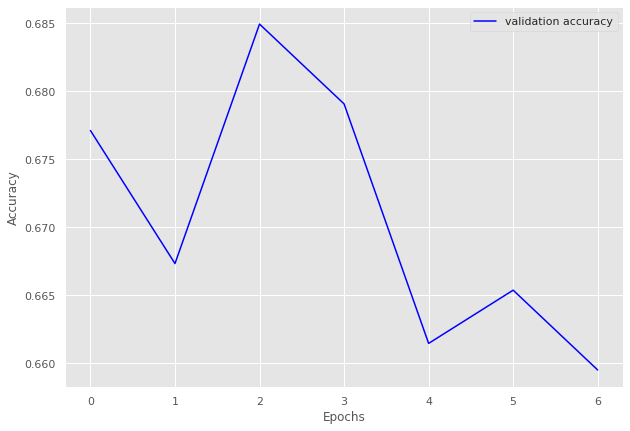

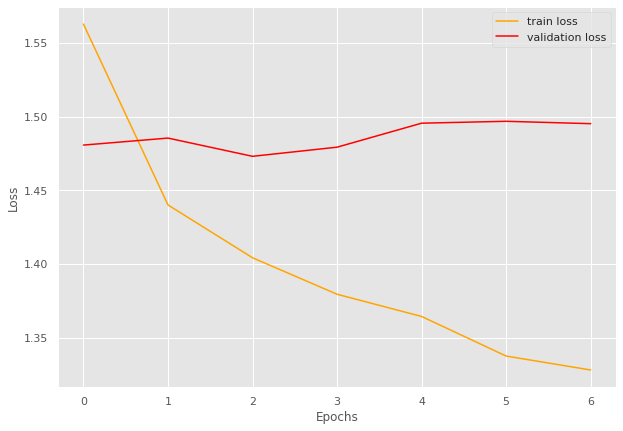

Done training of a fine model with test accuracy 0.9184688581314879
Coarse label 9 Epoch 1
-------------------------------


100%|██████████| 104/104 [00:35<00:00,  2.89batch/s, loss=1.89]


train loss 1.8886810369216478, validation loss 1.785646070133556, validation accuracy 0.6782477341389728
Coarse label 9 Epoch 2
-------------------------------


100%|██████████| 104/104 [00:36<00:00,  2.88batch/s, loss=1.78]


train loss 1.783158695468536, validation loss 1.77155263857408, validation accuracy 0.6873111782477341
Coarse label 9 Epoch 3
-------------------------------


100%|██████████| 104/104 [00:36<00:00,  2.86batch/s, loss=1.75]


train loss 1.7521606500332172, validation loss 1.7691885124553333, validation accuracy 0.6933534743202417
Coarse label 9 Epoch 4
-------------------------------


100%|██████████| 104/104 [00:36<00:00,  2.87batch/s, loss=1.74]


train loss 1.7356349929020956, validation loss 1.7647134824232622, validation accuracy 0.6903323262839879
Coarse label 9 Epoch 5
-------------------------------


100%|██████████| 104/104 [00:35<00:00,  2.89batch/s, loss=1.72]


INFO: Early stopping counter 1 of 5
train loss 1.7229708043428569, validation loss 1.7772081982005725, validation accuracy 0.6842900302114804
Coarse label 9 Epoch 6
-------------------------------


100%|██████████| 104/104 [00:36<00:00,  2.89batch/s, loss=1.71]


train loss 1.7055020148937519, validation loss 1.7511643171310425, validation accuracy 0.7039274924471299
Coarse label 9 Epoch 7
-------------------------------


100%|██████████| 104/104 [00:36<00:00,  2.86batch/s, loss=1.69]


INFO: Early stopping counter 2 of 5
train loss 1.6944262717778866, validation loss 1.768169023773887, validation accuracy 0.6888217522658611
Coarse label 9 Epoch 8
-------------------------------


100%|██████████| 104/104 [00:36<00:00,  2.85batch/s, loss=1.68]


INFO: Early stopping counter 3 of 5
train loss 1.6831087045944655, validation loss 1.7727143331007524, validation accuracy 0.6858006042296072
Coarse label 9 Epoch 9
-------------------------------


100%|██████████| 104/104 [00:35<00:00,  2.89batch/s, loss=1.67]


INFO: Early stopping counter 4 of 5
train loss 1.6746974621827786, validation loss 1.7659253965724597, validation accuracy 0.6873111782477341
Coarse label 9 Epoch 10
-------------------------------


100%|██████████| 104/104 [00:36<00:00,  2.89batch/s, loss=1.66]


INFO: Early stopping counter 5 of 5
INFO: Early stopping
Done! Saved model with test accuracy 0.9274248633879781 and loss 1.534370095833488


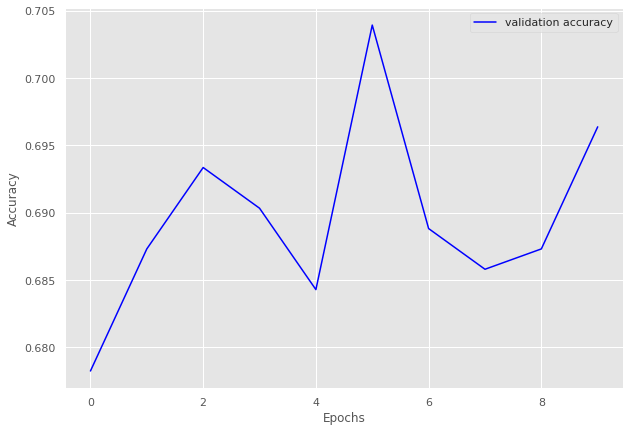

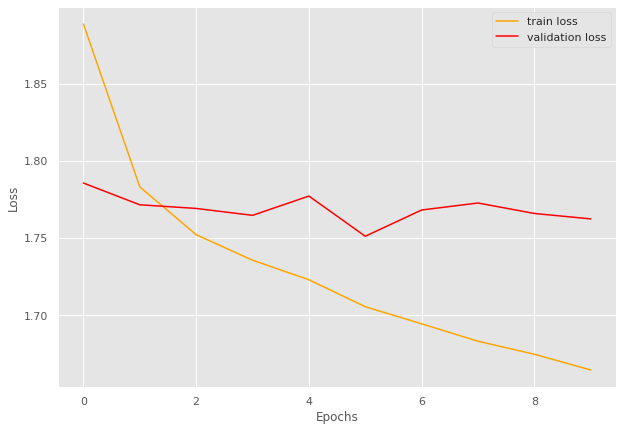

Done training of a fine model with test accuracy 0.9274248633879781
Coarse label 11 Epoch 1
-------------------------------


100%|██████████| 48/48 [00:16<00:00,  2.94batch/s, loss=1.05]


train loss 1.0481874893109004, validation loss 1.0176655650138855, validation accuracy 0.7242524916943521
Coarse label 11 Epoch 2
-------------------------------


100%|██████████| 48/48 [00:16<00:00,  2.93batch/s, loss=0.937]


train loss 0.937336441129446, validation loss 0.9890989542007447, validation accuracy 0.7541528239202658
Coarse label 11 Epoch 3
-------------------------------


100%|██████████| 48/48 [00:16<00:00,  2.93batch/s, loss=0.9]  


INFO: Early stopping counter 1 of 5
train loss 0.8996141999959946, validation loss 1.0043910622596741, validation accuracy 0.7275747508305648
Coarse label 11 Epoch 4
-------------------------------


100%|██████████| 48/48 [00:16<00:00,  2.93batch/s, loss=0.878]


INFO: Early stopping counter 2 of 5
train loss 0.8783825635910034, validation loss 1.0033175945281982, validation accuracy 0.7375415282392026
Coarse label 11 Epoch 5
-------------------------------


100%|██████████| 48/48 [00:18<00:00,  2.60batch/s, loss=0.867]


INFO: Early stopping counter 3 of 5
train loss 0.8668608802060286, validation loss 0.9972068905830384, validation accuracy 0.7508305647840532
Coarse label 11 Epoch 6
-------------------------------


100%|██████████| 48/48 [00:32<00:00,  1.50batch/s, loss=0.862]


INFO: Early stopping counter 4 of 5
train loss 0.8619076025982698, validation loss 1.0005035877227784, validation accuracy 0.7408637873754153
Coarse label 11 Epoch 7
-------------------------------


100%|██████████| 48/48 [00:35<00:00,  1.34batch/s, loss=0.83] 


train loss 0.8298124360541502, validation loss 0.9848713636398315, validation accuracy 0.770764119601329
Coarse label 11 Epoch 8
-------------------------------


100%|██████████| 48/48 [00:38<00:00,  1.26batch/s, loss=0.834]


INFO: Early stopping counter 5 of 5
INFO: Early stopping
Done! Saved model with test accuracy 0.9710144927536232 and loss 0.7742804505608298


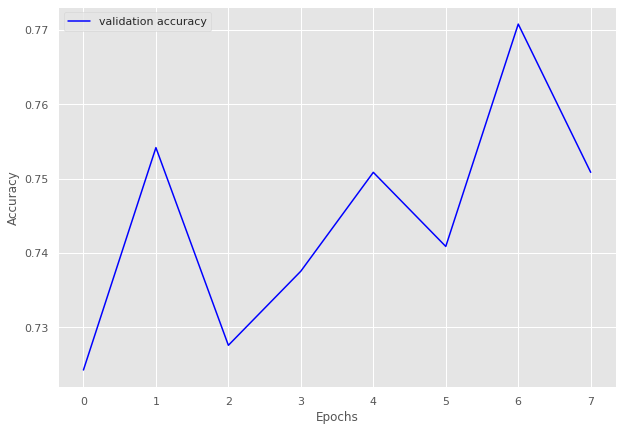

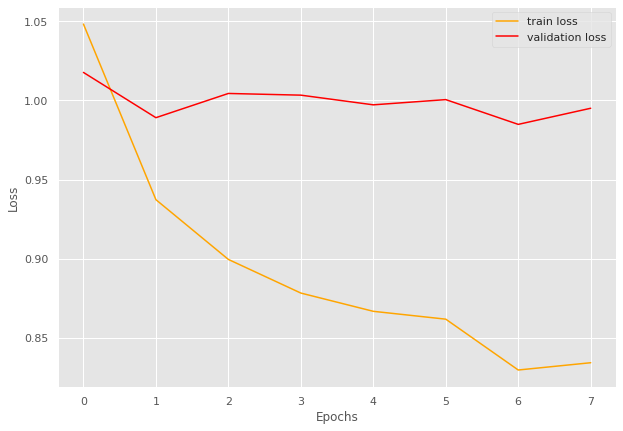

Done training of a fine model with test accuracy 0.9710144927536232
Coarse label 12 Epoch 1
-------------------------------


100%|██████████| 53/53 [00:41<00:00,  1.28batch/s, loss=1.52]


train loss 1.522707052950589, validation loss 1.3648675282796223, validation accuracy 0.6269113149847095
Coarse label 12 Epoch 2
-------------------------------


100%|██████████| 53/53 [00:25<00:00,  2.05batch/s, loss=1.37]


INFO: Early stopping counter 1 of 5
train loss 1.374844323914006, validation loss 1.3692681789398193, validation accuracy 0.6422018348623854
Coarse label 12 Epoch 3
-------------------------------


100%|██████████| 53/53 [00:19<00:00,  2.79batch/s, loss=1.3] 


INFO: Early stopping counter 2 of 5
train loss 1.3009057269906097, validation loss 1.3672053813934326, validation accuracy 0.6422018348623854
Coarse label 12 Epoch 4
-------------------------------


100%|██████████| 53/53 [00:18<00:00,  2.90batch/s, loss=1.26]


train loss 1.2567308646328044, validation loss 1.3628837863604228, validation accuracy 0.6605504587155964
Coarse label 12 Epoch 5
-------------------------------


100%|██████████| 53/53 [00:18<00:00,  2.91batch/s, loss=1.24]


INFO: Early stopping counter 3 of 5
train loss 1.2355515372078374, validation loss 1.3694491187731426, validation accuracy 0.6299694189602446
Coarse label 12 Epoch 6
-------------------------------


100%|██████████| 53/53 [00:18<00:00,  2.88batch/s, loss=1.21]


train loss 1.2105001750982032, validation loss 1.3620508710543315, validation accuracy 0.6299694189602446
Coarse label 12 Epoch 7
-------------------------------


100%|██████████| 53/53 [00:18<00:00,  2.89batch/s, loss=1.18]


train loss 1.1842683441234085, validation loss 1.3489369948705037, validation accuracy 0.654434250764526
Coarse label 12 Epoch 8
-------------------------------


100%|██████████| 53/53 [00:18<00:00,  2.92batch/s, loss=1.16]


INFO: Early stopping counter 4 of 5
train loss 1.1644751575757872, validation loss 1.3613649606704712, validation accuracy 0.6391437308868502
Coarse label 12 Epoch 9
-------------------------------


100%|██████████| 53/53 [00:18<00:00,  2.90batch/s, loss=1.16]


INFO: Early stopping counter 5 of 5
INFO: Early stopping
Done! Saved model with test accuracy 0.9045454545454545 and loss 1.1389387136413938


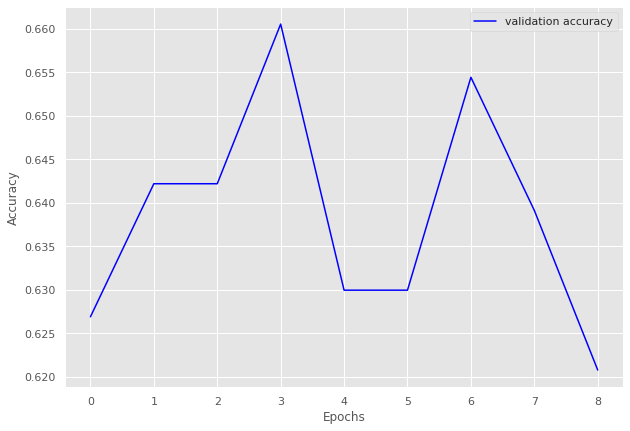

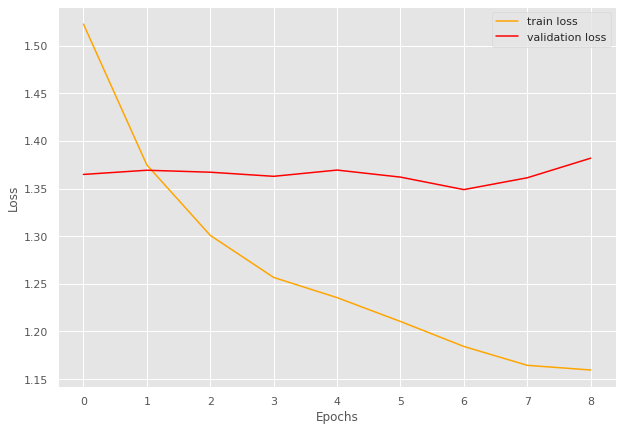

Done training of a fine model with test accuracy 0.9045454545454545
Coarse label 13 Epoch 1
-------------------------------


100%|██████████| 38/38 [00:13<00:00,  2.92batch/s, loss=0.807]


train loss 0.8072833058081175, validation loss 0.7619576305150986, validation accuracy 0.7816593886462883
Coarse label 13 Epoch 2
-------------------------------


100%|██████████| 38/38 [00:13<00:00,  2.83batch/s, loss=0.697]


INFO: Early stopping counter 1 of 5
train loss 0.6965426520297402, validation loss 0.7644505202770233, validation accuracy 0.7729257641921398
Coarse label 13 Epoch 3
-------------------------------


100%|██████████| 38/38 [00:12<00:00,  2.93batch/s, loss=0.657]


train loss 0.6568757797542372, validation loss 0.7438697665929794, validation accuracy 0.7860262008733624
Coarse label 13 Epoch 4
-------------------------------


100%|██████████| 38/38 [00:13<00:00,  2.92batch/s, loss=0.637]


train loss 0.6369544471565046, validation loss 0.7270824760198593, validation accuracy 0.8165938864628821
Coarse label 13 Epoch 5
-------------------------------


100%|██████████| 38/38 [00:13<00:00,  2.90batch/s, loss=0.618]


INFO: Early stopping counter 2 of 5
train loss 0.6181273679984244, validation loss 0.7387775778770447, validation accuracy 0.8253275109170306
Coarse label 13 Epoch 6
-------------------------------


100%|██████████| 38/38 [00:13<00:00,  2.92batch/s, loss=0.612]


INFO: Early stopping counter 3 of 5
train loss 0.6115951977278057, validation loss 0.7322506308555603, validation accuracy 0.8209606986899564
Coarse label 13 Epoch 7
-------------------------------


100%|██████████| 38/38 [00:13<00:00,  2.84batch/s, loss=0.598]


INFO: Early stopping counter 4 of 5
train loss 0.5982723439994612, validation loss 0.7456586062908173, validation accuracy 0.8078602620087336
Coarse label 13 Epoch 8
-------------------------------


100%|██████████| 38/38 [00:12<00:00,  2.95batch/s, loss=0.59] 


INFO: Early stopping counter 5 of 5
INFO: Early stopping
Done! Saved model with test accuracy 0.9410508329773601 and loss 0.6098716259002686


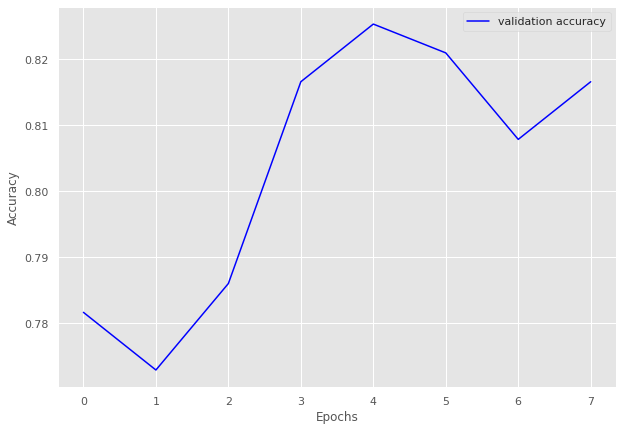

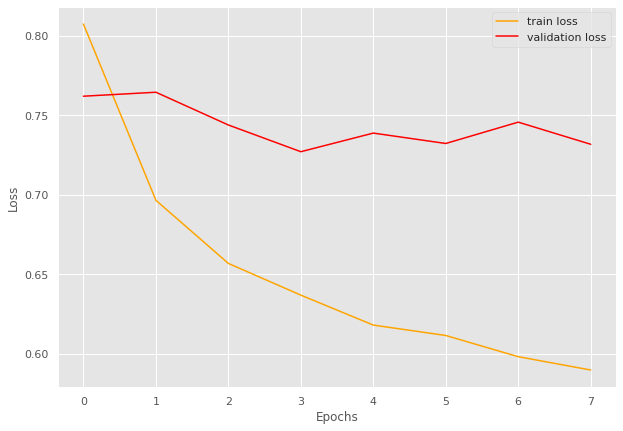

Done training of a fine model with test accuracy 0.9410508329773601
Coarse label 14 Epoch 1
-------------------------------


100%|██████████| 85/85 [00:29<00:00,  2.87batch/s, loss=1.34]


train loss 1.340440614083234, validation loss 1.2911921342213948, validation accuracy 0.7312614259597806
Coarse label 14 Epoch 2
-------------------------------


100%|██████████| 85/85 [00:29<00:00,  2.90batch/s, loss=1.24]


INFO: Early stopping counter 1 of 5
train loss 1.2432853376164157, validation loss 1.293748590681288, validation accuracy 0.7385740402193784
Coarse label 14 Epoch 3
-------------------------------


100%|██████████| 85/85 [00:29<00:00,  2.87batch/s, loss=1.22]


INFO: Early stopping counter 2 of 5
train loss 1.2237244002959307, validation loss 1.2939400143093533, validation accuracy 0.7477148080438757
Coarse label 14 Epoch 4
-------------------------------


100%|██████████| 85/85 [00:29<00:00,  2.85batch/s, loss=1.2] 


train loss 1.2048326590481926, validation loss 1.2802440987692938, validation accuracy 0.7605118829981719
Coarse label 14 Epoch 5
-------------------------------


100%|██████████| 85/85 [00:29<00:00,  2.91batch/s, loss=1.19]


train loss 1.1922892570495605, validation loss 1.2746035787794325, validation accuracy 0.7623400365630713
Coarse label 14 Epoch 6
-------------------------------


100%|██████████| 85/85 [00:29<00:00,  2.89batch/s, loss=1.17]


INFO: Early stopping counter 3 of 5
train loss 1.1743752872242648, validation loss 1.2908114989598591, validation accuracy 0.7422303473491774
Coarse label 14 Epoch 7
-------------------------------


100%|██████████| 85/85 [00:29<00:00,  2.89batch/s, loss=1.17]


INFO: Early stopping counter 4 of 5
train loss 1.170347370820887, validation loss 1.2811031606462266, validation accuracy 0.7550274223034735
Coarse label 14 Epoch 8
-------------------------------


100%|██████████| 85/85 [00:29<00:00,  2.88batch/s, loss=1.16]


INFO: Early stopping counter 5 of 5
INFO: Early stopping
Done! Saved model with test accuracy 0.9508837209302325 and loss 1.0936942781720842


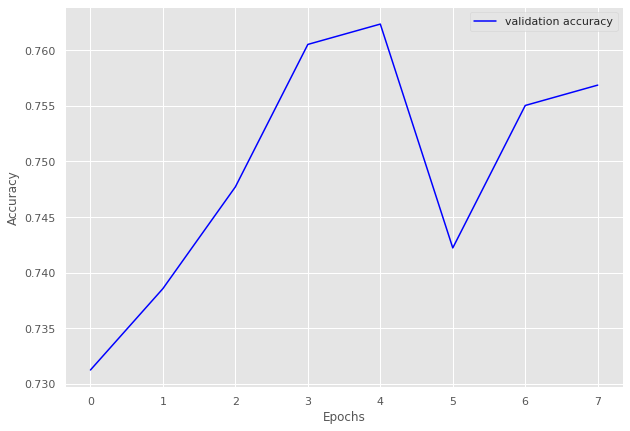

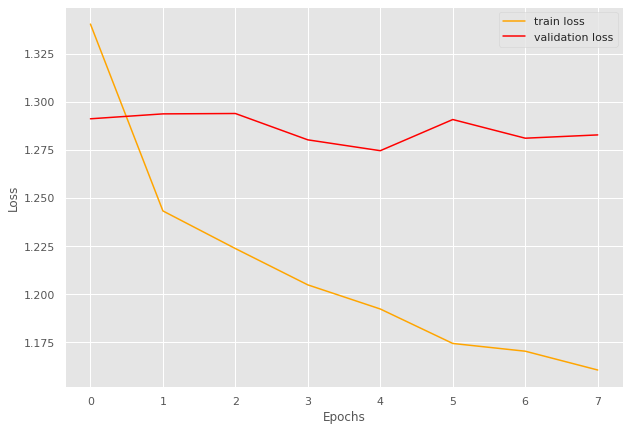

Done training of a fine model with test accuracy 0.9508837209302325
Coarse label 15 Epoch 1
-------------------------------


100%|██████████| 47/47 [00:15<00:00,  2.96batch/s, loss=1.07]


train loss 1.0669066779156948, validation loss 1.0460888028144837, validation accuracy 0.7285223367697594
Coarse label 15 Epoch 2
-------------------------------


100%|██████████| 47/47 [00:16<00:00,  2.92batch/s, loss=0.934]


INFO: Early stopping counter 1 of 5
train loss 0.9343305737414258, validation loss 1.0520307779312135, validation accuracy 0.711340206185567
Coarse label 15 Epoch 3
-------------------------------


100%|██████████| 47/47 [00:15<00:00,  2.94batch/s, loss=0.895]


INFO: Early stopping counter 2 of 5
train loss 0.8948229855679452, validation loss 1.0603339552879334, validation accuracy 0.6941580756013745
Coarse label 15 Epoch 4
-------------------------------


100%|██████████| 47/47 [00:16<00:00,  2.84batch/s, loss=0.857]


INFO: Early stopping counter 3 of 5
train loss 0.8572961015904204, validation loss 1.0715843200683595, validation accuracy 0.6907216494845361
Coarse label 15 Epoch 5
-------------------------------


100%|██████████| 47/47 [00:16<00:00,  2.82batch/s, loss=0.843]


INFO: Early stopping counter 4 of 5
train loss 0.8428686920632708, validation loss 1.060544490814209, validation accuracy 0.7010309278350515
Coarse label 15 Epoch 6
-------------------------------


100%|██████████| 47/47 [00:15<00:00,  2.95batch/s, loss=0.854]


INFO: Early stopping counter 5 of 5
INFO: Early stopping
Done! Saved model with test accuracy 0.9412207987942728 and loss 0.802405670994804


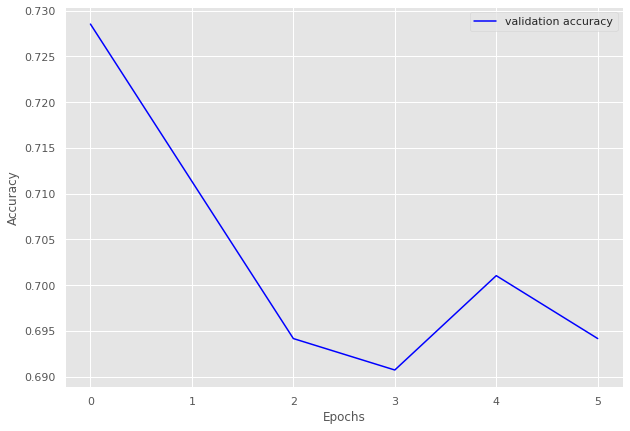

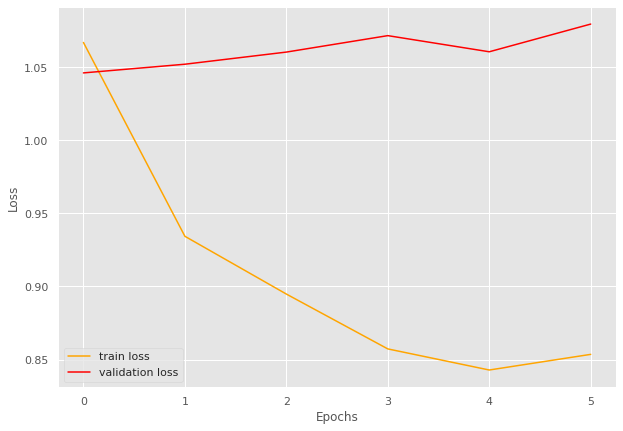

Done training of a fine model with test accuracy 0.9412207987942728
Coarse label 16 Epoch 1
-------------------------------


100%|██████████| 43/43 [00:14<00:00,  2.95batch/s, loss=0.808]


train loss 0.8076552318972211, validation loss 0.9153251409530639, validation accuracy 0.7346153846153847
Coarse label 16 Epoch 2
-------------------------------


100%|██████████| 43/43 [00:14<00:00,  2.98batch/s, loss=0.696]


train loss 0.6962960417880568, validation loss 0.9012526750564576, validation accuracy 0.7423076923076923
Coarse label 16 Epoch 3
-------------------------------


100%|██████████| 43/43 [00:14<00:00,  2.97batch/s, loss=0.648]


train loss 0.6479837464731794, validation loss 0.868613886833191, validation accuracy 0.7384615384615385
Coarse label 16 Epoch 4
-------------------------------


100%|██████████| 43/43 [00:14<00:00,  2.96batch/s, loss=0.624]


INFO: Early stopping counter 1 of 5
train loss 0.6241410859795504, validation loss 0.8768644213676453, validation accuracy 0.7730769230769231
Coarse label 16 Epoch 5
-------------------------------


100%|██████████| 43/43 [00:14<00:00,  2.91batch/s, loss=0.609]


INFO: Early stopping counter 2 of 5
train loss 0.6085713935452838, validation loss 0.9023912429809571, validation accuracy 0.7384615384615385
Coarse label 16 Epoch 6
-------------------------------


100%|██████████| 43/43 [00:14<00:00,  2.95batch/s, loss=0.609]


INFO: Early stopping counter 3 of 5
train loss 0.6093111703562182, validation loss 0.8923536777496338, validation accuracy 0.7461538461538462
Coarse label 16 Epoch 7
-------------------------------


100%|██████████| 43/43 [00:14<00:00,  2.98batch/s, loss=0.621]


train loss 0.6211948228436847, validation loss 0.8487073421478272, validation accuracy 0.7615384615384615
Coarse label 16 Epoch 8
-------------------------------


100%|██████████| 43/43 [00:14<00:00,  2.94batch/s, loss=0.602]


INFO: Early stopping counter 4 of 5
train loss 0.6016478829605635, validation loss 0.8970263600349426, validation accuracy 0.7615384615384615
Coarse label 16 Epoch 9
-------------------------------


100%|██████████| 43/43 [00:14<00:00,  2.96batch/s, loss=0.598]


INFO: Early stopping counter 5 of 5
INFO: Early stopping
Done! Saved model with test accuracy 0.9360282574568289 and loss 0.6124356925487519


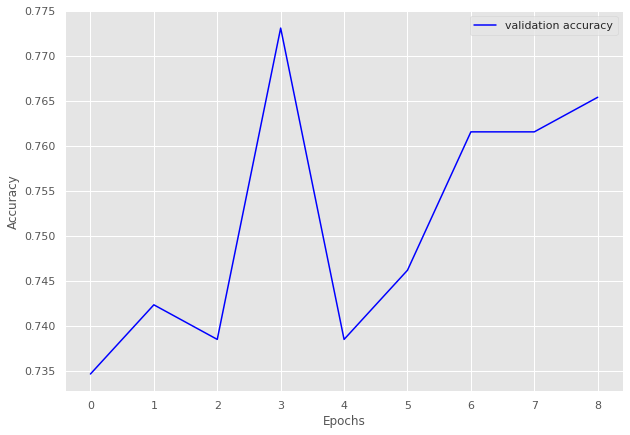

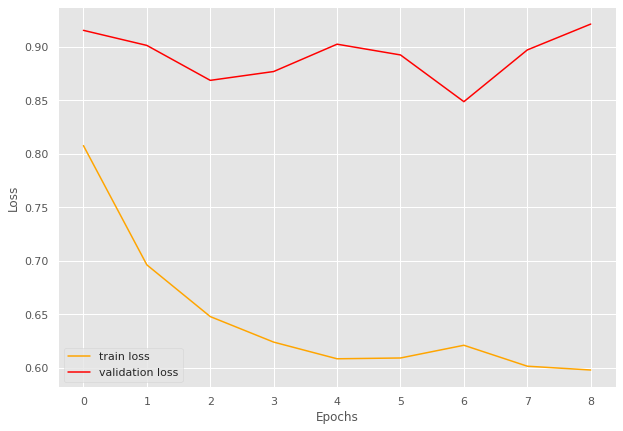

Done training of a fine model with test accuracy 0.9360282574568289
Coarse label 17 Epoch 1
-------------------------------


100%|██████████| 47/47 [00:16<00:00,  2.90batch/s, loss=1.1] 


train loss 1.0978817318348175, validation loss 1.030179464817047, validation accuracy 0.6925566343042071
Coarse label 17 Epoch 2
-------------------------------


100%|██████████| 47/47 [00:16<00:00,  2.88batch/s, loss=0.954]


train loss 0.954037680270824, validation loss 1.0011462092399597, validation accuracy 0.7281553398058253
Coarse label 17 Epoch 3
-------------------------------


100%|██████████| 47/47 [00:16<00:00,  2.91batch/s, loss=0.894]


INFO: Early stopping counter 1 of 5
train loss 0.8938600953589094, validation loss 1.026616060733795, validation accuracy 0.686084142394822
Coarse label 17 Epoch 4
-------------------------------


100%|██████████| 47/47 [00:16<00:00,  2.90batch/s, loss=0.863]


INFO: Early stopping counter 2 of 5
train loss 0.8629552404931251, validation loss 1.0282277822494508, validation accuracy 0.6990291262135923
Coarse label 17 Epoch 5
-------------------------------


100%|██████████| 47/47 [00:16<00:00,  2.91batch/s, loss=0.84] 


INFO: Early stopping counter 3 of 5
train loss 0.8396892712471333, validation loss 1.040984845161438, validation accuracy 0.6828478964401294
Coarse label 17 Epoch 6
-------------------------------


100%|██████████| 47/47 [00:16<00:00,  2.92batch/s, loss=0.826]


INFO: Early stopping counter 4 of 5
train loss 0.8258545119711693, validation loss 1.0442395448684691, validation accuracy 0.6957928802588996
Coarse label 17 Epoch 7
-------------------------------


100%|██████████| 47/47 [00:16<00:00,  2.89batch/s, loss=0.824]


INFO: Early stopping counter 5 of 5
INFO: Early stopping
Done! Saved model with test accuracy 0.9215616045845272 and loss 0.8211253028024327


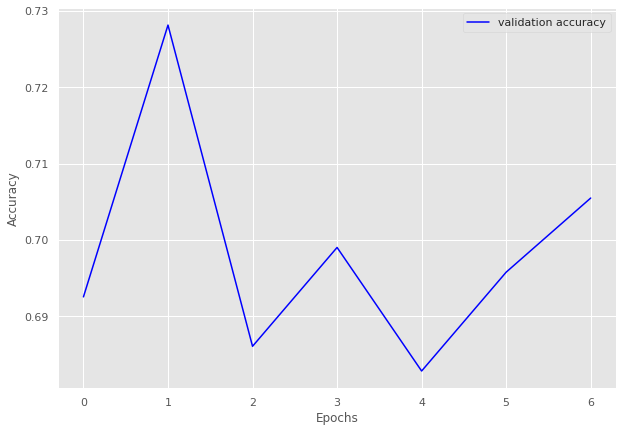

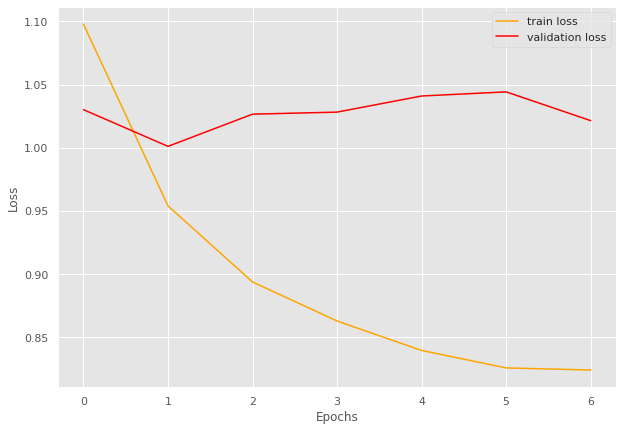

Done training of a fine model with test accuracy 0.9215616045845272
Coarse label 19 Epoch 1
-------------------------------


100%|██████████| 24/24 [00:08<00:00,  2.92batch/s, loss=1.25]


train loss 1.2501718153556187, validation loss 1.181692123413086, validation accuracy 0.5087719298245614
Coarse label 19 Epoch 2
-------------------------------


100%|██████████| 24/24 [00:08<00:00,  2.83batch/s, loss=1.05]


train loss 1.0494574805100758, validation loss 1.1367243925730388, validation accuracy 0.5321637426900585
Coarse label 19 Epoch 3
-------------------------------


100%|██████████| 24/24 [00:08<00:00,  2.89batch/s, loss=0.909]


INFO: Early stopping counter 1 of 5
train loss 0.9094952096541723, validation loss 1.150173286596934, validation accuracy 0.5321637426900585
Coarse label 19 Epoch 4
-------------------------------


100%|██████████| 24/24 [00:08<00:00,  2.76batch/s, loss=0.844]


INFO: Early stopping counter 2 of 5
train loss 0.8435551648338636, validation loss 1.176688055197398, validation accuracy 0.5029239766081871
Coarse label 19 Epoch 5
-------------------------------


100%|██████████| 24/24 [00:08<00:00,  2.80batch/s, loss=0.81] 


INFO: Early stopping counter 3 of 5
train loss 0.8095707222819328, validation loss 1.16976002852122, validation accuracy 0.5380116959064327
Coarse label 19 Epoch 6
-------------------------------


100%|██████████| 24/24 [00:08<00:00,  2.86batch/s, loss=0.788]


INFO: Early stopping counter 4 of 5
train loss 0.788049412270387, validation loss 1.171529491742452, validation accuracy 0.5146198830409356
Coarse label 19 Epoch 7
-------------------------------


100%|██████████| 24/24 [00:08<00:00,  2.89batch/s, loss=0.783]


INFO: Early stopping counter 5 of 5
INFO: Early stopping
Done! Saved model with test accuracy 0.9083710407239819 and loss 0.8384733923843929


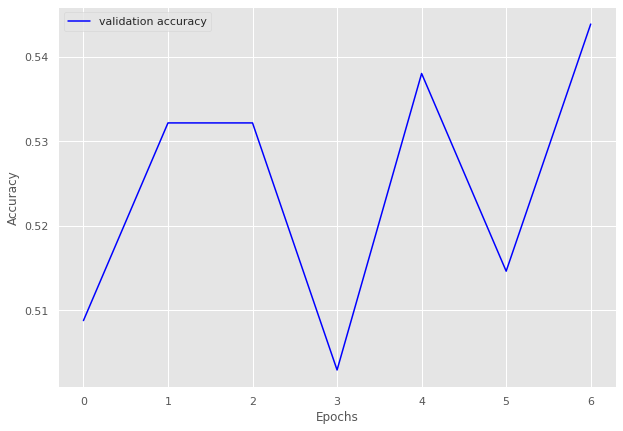

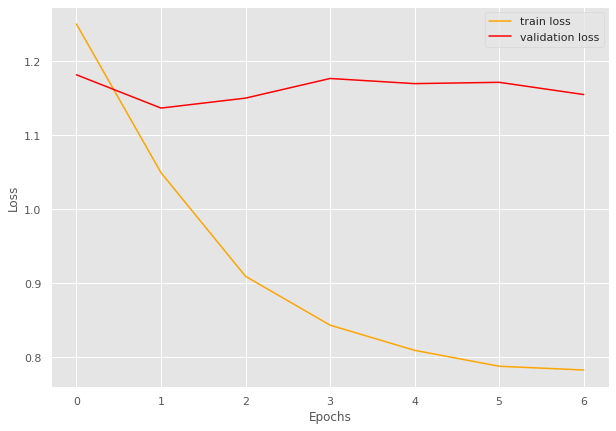

Done training of a fine model with test accuracy 0.9083710407239819
Starting model evaluation...
Evaluating fine model 0
Evaluating fine model 1
Evaluating fine model 2
Evaluating fine model 4
Evaluating fine model 5
Evaluating fine model 6
Evaluating fine model 7
Evaluating fine model 8
Evaluating fine model 9
Evaluating fine model 11
Evaluating fine model 12
Evaluating fine model 13
Evaluating fine model 14
Evaluating fine model 15
Evaluating fine model 16
Evaluating fine model 17
Evaluating fine model 19
overall accuracy  is 0.7872379035584077
Calculating for volume 50
Start training a coarse model
Epoch 1
-------------------------------


100%|██████████| 1052/1052 [06:06<00:00,  2.87batch/s, loss=2.81]


train loss 2.810101586376306, validation loss 2.783227062225342, validation accuracy 0.29476831091180866
Epoch 2
-------------------------------


100%|██████████| 1052/1052 [07:56<00:00,  2.21batch/s, loss=2.75]


train loss 2.752692184520765, validation loss 2.749617526644752, validation accuracy 0.3279521674140508
Epoch 3
-------------------------------


100%|██████████| 1052/1052 [06:07<00:00,  2.86batch/s, loss=2.73]


train loss 2.7326068714997613, validation loss 2.735864748273577, validation accuracy 0.34185351270553066
Epoch 4
-------------------------------


100%|██████████| 1052/1052 [06:05<00:00,  2.88batch/s, loss=2.73]


train loss 2.725523833312916, validation loss 2.734477143060593, validation accuracy 0.3436472346786248
Epoch 5
-------------------------------


100%|██████████| 1052/1052 [06:09<00:00,  2.85batch/s, loss=2.72]


train loss 2.715578494869711, validation loss 2.7342141560145787, validation accuracy 0.34334828101644244
Epoch 6
-------------------------------


100%|██████████| 1052/1052 [06:05<00:00,  2.88batch/s, loss=2.71]


train loss 2.708741105554675, validation loss 2.726111130487351, validation accuracy 0.35112107623318384
Epoch 7
-------------------------------


100%|██████████| 1052/1052 [06:06<00:00,  2.87batch/s, loss=2.71]


train loss 2.7057956552324187, validation loss 2.722210320972261, validation accuracy 0.35650224215246634
Epoch 8
-------------------------------


100%|██████████| 1052/1052 [06:24<00:00,  2.73batch/s, loss=2.7]


train loss 2.6996747423034204, validation loss 2.7185865629286994, validation accuracy 0.3593423019431988
Epoch 9
-------------------------------


  8%|▊         | 85/1052 [01:05<09:17,  1.73batch/s, loss=2.68]

In [ ]:
for run, seed in enumerate(seeds):
    print('Starting run %s' %run)
    #set manual seed
    torch.manual_seed(seed)
    np.random.seed(seed)

    accuracies['%s' %run] = {'coarse':{}, 'fine':{}, 'whole':{}}

    #load clusters data
    tasksim_clusters = pickle.load(open(teamdrive_root +'icons_experiment/generated_clusters/rf_tasksim_clusters_00_2.p', 'rb'))
    fine_to_coarse, coarse_to_fine = create_label_dictionaries(tasksim_clusters)
    print(coarse_to_fine)

    number_of_clusters = len(coarse_to_fine.keys())
    stacked_fine_labels = []
    for i in range(0, number_of_clusters):
        stacked_fine_labels +=coarse_to_fine[i]

    #prepare data
    train_df = df[df['split_%s' %(run)] == 'train']
    test_df = df[df['split_%s' %(run)] == 'test']
    valid_df = df[df['split_%s' %(run)] == 'valid']
    
    for volume in label_noises:
        print('Calculating for volume %s' %volume)

        # prepare dataloaders
        batch_size = 64
        epochs= 40

        test_dataset = IconDataset(test_df, test_transform, "", run, volume)
        train_dataset = IconDataset(train_df, train_transform, "", run, volume)
        validation_dataset = IconDataset(valid_df, test_transform, "", run, volume)

        dl_train = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        dl_test = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
        dl_valid = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False)

        # train coarse model 
        print('Start training a coarse model')
        gc.collect() 
        torch.cuda.empty_cache()
        #Load fine tuned model 
        model = Resnext50(number_of_clusters, name="coarse_model_Resnext50_icons_noise_50_training_%s_%s" %(volume, run))
        model.state_dict(torch.load(fine_tuned_model_path))
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
        model.to(device)
        loss_fn = torch.nn.CrossEntropyLoss().to(device)

        test_accuracy =train_and_validate(epochs, model, loss_fn, optimizer, 
                                                            dl_train, dl_test, dl_valid,
                                                            mode="coarse", fine_to_coarse=fine_to_coarse,
                                                            model_path = teamdrive_root+'models/hierarchical/%s.pth' %model.name )
        accuracies['%s' %run]['coarse']['%s' %volume] = test_accuracy
        with open(teamdrive_root + 'icons_experiment/noise_50_hierarchical_accuracies.p', 'wb') as handle:
            pickle.dump(accuracies, handle)
        print("Done training of a coarse model with test accuracy %s" %test_accuracy)

        #fine classifiers training
        accuracies['%s' %run]['fine']['%s' % volume] = {}
        for coarse_label in range(0, number_of_clusters):
            if len(coarse_to_fine[coarse_label])>1:
                gc.collect() 
                torch.cuda.empty_cache()
                dl_train, dl_valid, dl_test =  filter_data(train_dataset, test_dataset, validation_dataset, 
                                                           filter_by_coarse=True, coarse_label=coarse_label, 
                                                           coarse_to_fine=coarse_to_fine, batch_size=batch_size)

                # Initialize the model
                #Load fine tuned model
                model = Resnext50(len(coarse_to_fine[coarse_label]),name="fine_model_coarse_label_%s_icons_noise_50_training_%s_%s" %(coarse_label,volume, run))
                model.state_dict(torch.load(fine_tuned_model_path))
                optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)             
                model.to(device)
                loss_fn = torch.nn.CrossEntropyLoss().to(device)
                test_accuracy =train_and_validate(epochs, model, loss_fn, optimizer,
                                                  dl_train, dl_test, dl_valid, 
                                                  mode="fine", coarse_label=coarse_label,
                                                  lookup=coarse_to_fine[coarse_label],
                                                  model_path = teamdrive_root+'models/hierarchical/%s.pth' %model.name )
                accuracies['%s' %run]['fine']['%s' %volume]['%s' %coarse_label] = test_accuracy
                with open(teamdrive_root + 'icons_experiment/noise_50_hierarchical_accuracies.p', 'wb') as handle:
                    pickle.dump(accuracies, handle)
                print("Done training of a fine model with test accuracy %s" %test_accuracy)

        #whole model evaluation
        print('Starting model evaluation...')
        dl_test = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

        #loading models
        gc.collect() 
        torch.cuda.empty_cache()
        model_coarse = torch.load(teamdrive_root+'models/hierarchical/coarse_model_Resnext50_icons_noise_50_training_%s_%s.pth' %(volume, run))
        fine_models = {}
        for i in range(0,number_of_clusters):
            if len(coarse_to_fine[i])>1:
                fine_models['fine_model_' + str(i)] = torch.load(teamdrive_root+'models/hierarchical/fine_model_coarse_label_%s_icons_noise_50_training_%s_%s.pth' %(i, volume, run))

        coarse_predicts = []
        targets = []
        model_coarse.to(device)
        model_coarse.eval()
        for counter, (images, labels) in enumerate(dl_test):
            imageGPU = images.to(device)
            outputs = torch.Tensor.cpu(model_coarse(imageGPU))
            coarse_predicts.append(outputs.detach().numpy())
            targets.append(labels)
        targets = np.hstack(targets)  


        #reformat coarse prediction
        coarse_prediction = np.vstack(coarse_predicts)
        column_num = 0
        for i in range(0, number_of_clusters):
            cluster_len = len(coarse_to_fine[i])
            for rep in range(cluster_len-1):
                coarse_prediction = np.insert(coarse_prediction, column_num, coarse_prediction[:,column_num], axis=1)
            column_num +=cluster_len
        fine_prediction= []

        for i in range(0,number_of_clusters):
            gc.collect() 
            torch.cuda.empty_cache()
            if len(coarse_to_fine[i]) == 1:
                fine_prediction.append(np.ones((len(coarse_prediction),1)))
            else:
                predicts = []
                print("Evaluating fine model %s" %i)
                fine_model = fine_models['fine_model_%s' %i]
                fine_model.to(device)
                fine_model.eval()
                for counter, (images, labels) in enumerate(dl_test):
                    imageGPU = images.to(device)
                    outputs = torch.Tensor.cpu(fine_model(imageGPU))
                    predicts.append(outputs.detach().numpy())   
                predicts = np.vstack(predicts)
                fine_prediction.append(predicts)                          

        #reformat fine_prediction
        fine_prediction = np.hstack(fine_prediction)
        result = np.multiply(fine_prediction, coarse_prediction)
        result = np.argmax(result, axis=1)
        result_decoded = [stacked_fine_labels[i] for i in result]   
        final_acc = accuracy_score(targets, result_decoded) 
        print("overall accuracy  is %s" %final_acc)
        accuracies['%s' %run]['whole']['%s' %volume] = final_acc
        with open(teamdrive_root + 'icons_experiment/noise_50_hierarchical_accuracies.p', 'wb') as handle:
            pickle.dump(accuracies, handle)




In [7]:
accuracies

{'0': {'coarse': {}, 'fine': {}, 'whole': {}}}